# Annual temperature anomalies relative to the pre-industrial period

## Imports

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pmdarima.arima import nsdiffs, ndiffs

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.ar_model import AutoReg
import scipy.stats as stats
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import Holt


import warnings
warnings.filterwarnings('ignore')


## EDA


### Reading the Data and creating Time Series


In [16]:
db = pd.read_csv("temperature-anomaly.csv")
db = db[["Year","Global average temperature anomaly relative to 1861-1890","Lower bound of the annual temperature anomaly (95% confidence interval)","Upper bound of the annual temperature anomaly (95% confidence interval)"]]
db = db.rename(columns={
    "Global average temperature anomaly relative to 1861-1890" : "Anomaly",
    "Lower bound of the annual temperature anomaly (95% confidence interval)" : "Lower Bound",
    "Upper bound of the annual temperature anomaly (95% confidence interval)" : "Upper Bound"
})
print(db.head())

   Year   Anomaly  Lower Bound  Upper Bound
0  1850 -0.055414    -0.226959     0.116131
1  1851  0.128948    -0.049570     0.307466
2  1852  0.132899    -0.047085     0.312882
3  1853  0.091943    -0.067712     0.251598
4  1854  0.070777    -0.070414     0.211968


In [17]:
dates = pd.date_range(start='1850', periods=len(db), freq='YE')
mytimeseries = pd.DataFrame(db.iloc[:, 1:].values, index=dates, columns=db.columns[1:])

print("\nTime series info:")
print(mytimeseries.info())
print(mytimeseries.head())


Time series info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 176 entries, 1850-12-31 to 2025-12-31
Freq: YE-DEC
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Anomaly      176 non-null    float64
 1   Lower Bound  176 non-null    float64
 2   Upper Bound  176 non-null    float64
dtypes: float64(3)
memory usage: 5.5 KB
None
             Anomaly  Lower Bound  Upper Bound
1850-12-31 -0.055414    -0.226959     0.116131
1851-12-31  0.128948    -0.049570     0.307466
1852-12-31  0.132899    -0.047085     0.312882
1853-12-31  0.091943    -0.067712     0.251598
1854-12-31  0.070777    -0.070414     0.211968


For this analysis, the primary focus is on the global average temperature anomaly, for which our dataset has data with anual frequency from the Industrial Revolution to the present day (1850-2025, 175 years). While the dataset provides upper and lower bounds to indicate uncertainty, these values are not essential for understanding the overall trend. The average anomaly alone captures how much the Earth's surface temperature has deviated from pre-industrial levels each year, which is why only the average anomaly will be used from here on out.

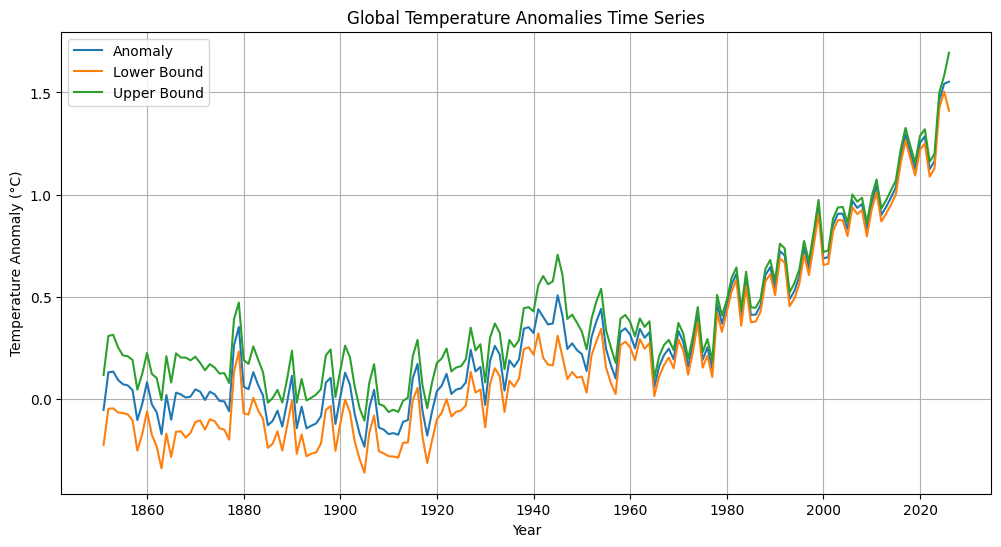

In [18]:
plt.figure(figsize=(12, 6))
for col in mytimeseries.columns:
    plt.plot(mytimeseries.index, mytimeseries[col], label=col)

plt.title("Global Temperature Anomalies Time Series")
plt.xlabel("Year")
plt.ylabel("Temperature Anomaly (°C)")
plt.grid(True)
plt.legend()
plt.show()

By concentrating on the average, we can clearly observe the long-term warming trend without the distraction of additional columns. This simplification makes the analysis cleaner, easier to interpret, and directly highlights the magnitude of global temperature changes over time.

### Descriptive Analysis of the Time Series

The series shows a clear upward trend over the past 170+ years, indicating a gradual increase in global temperatures relative to
   pre-industrial levels.

Although there is a general warming trend, the anomalies fluctuate from year to year, with some years being cooler or warmer than the previous year.

The early 20th century shows relatively small deviations, while the late 20th and early 21st centuries exhibit larger positive anomalies, with record highs in recent decades.

The warming trend is gradual over decades, rather than abrupt jumps, although occasional short-term dips are visible due to natural variability.


### Time Series Components

In this section, we analyze the main components of the dataset before applying a formal time series decomposition.

#### 1. Trend
The series shows a **clear upward trend** in global temperature anomalies.
The trend is not perfectly linear: warming is modest before the mid-20th century and accelerates strongly in recent decades.

#### 2. Seasonality

Since the data is **annual** and aggregated at the **global level**, no intra-year seasonal pattern can be observed.
- Hemispheric seasons cancel each other out (summer in one hemisphere corresponds to winter in the other).
- Furthermore, the anomaly calculation is performed relative to a baseline climatology, which already removes the average seasonal cycle.

As a result, this dataset only reflects **long-term trend** and **year-to-year variability**, but not seasonal fluctuations.


#### 3. Variance and Heteroscedasticity
Some evidence of heteroscedasticity is present. In earlier decades (late 19th and early 20th century), the spread of anomalies appears wider. Over time, the range between upper and lower fluctuations narrows.

This narrowing is largely due to **improvements in scientific measurement and global coverage** rather than a real change in climate variability. As more weather stations, ocean buoys, and later satellites were incorporated, the estimates of global temperature anomalies became more precise, reducing uncertainty.

Thus, while the variance of the series shows modest changes, these are best interpreted as **data quality effects** rather than fundamental changes in climate dynamics.

#### 4. Additive vs Multiplicative Structure
Despite small changes in variance, the dataset is best represented by an **additive model**:


$$y_t=T_t + R_t$$


- The **trend** captures the long-term warming signal.
- The **noise** represents short-term variability .
- A multiplicative model is not appropriate, since fluctuations do not scale with the level of the series.



### Time Series Decomposition

In this section we separate the series into its core parts to understand what drives the behavior: a smooth trend (long-run warming) and a remainder (short-run fluctuations). Annual data have no within-year seasonality, so a seasonal component is not modeled.

#### Method (additive, annual)

#### 1. Smoothing for Trend
- **LOWESS:** a locally weighted smoother that traces the central path while ignoring year-to-year noise.

#### 2. Remainder
We define the remainder as the observed anomaly minus the smooth trend:
$$
\mathrm{Remainder}_t \;=\; \mathrm{Anomaly}_t \;-\; \widehat{\mathrm{Trend}}_t
$$

We analyze the remainder to check **serial correlation** (persistence) and **variance changes** (heteroscedasticity).

#### 3. Uncertainty
We visualize the **95% confidence band** (*Lower Bound* / *Upper Bound*) around the anomaly to communicate **estimation uncertainty**.


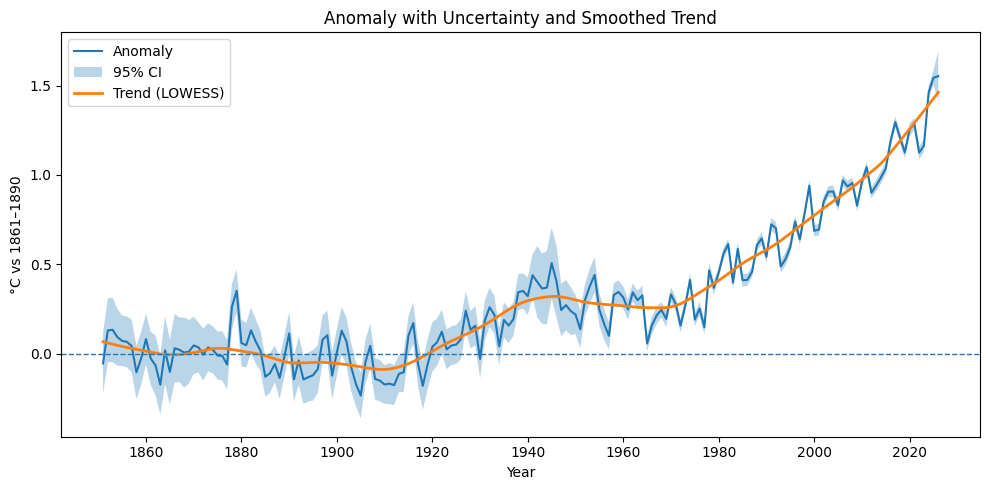

In [19]:
ts = mytimeseries[['Anomaly','Lower Bound','Upper Bound']].sort_index()
x      = np.arange(len(ts))                            
years  = ts.index.to_pydatetime()                         
an     = ts['Anomaly'].to_numpy(dtype=float)
lo_ci  = ts['Lower Bound'].to_numpy(dtype=float)
hi_ci  = ts['Upper Bound'].to_numpy(dtype=float)


low = lowess(an, x, frac=0.15, return_sorted=False)      
remainder = an - low

plt.figure(figsize=(10,5))
plt.plot(years, an, label='Anomaly')
plt.fill_between(years, lo_ci, hi_ci, alpha=0.3, label='95% CI')
plt.plot(years, low, linewidth=2, label='Trend (LOWESS)')
plt.axhline(0, linestyle='--', linewidth=1)
plt.title('Anomaly with Uncertainty and Smoothed Trend')
plt.xlabel('Year'); plt.ylabel('°C vs 1861–1890'); plt.legend()
plt.tight_layout(); plt.show()

The LOWESS smoother isolates the underlying signal from the annual noise, revealing a persistent long-run warming trend. While the early decades hover near the baseline, the trendline exhibits a distinct upward inflection moving into the 20th century and rises more sharply in recent decades, which is consistent with the acceleration of global warming.

#### **Remainder**

We observed the remainder to look for the following:
- Is it centered around 0 (no lingering trend)?
- Is the variance roughly stable or does it change over time?
- Is there serial correlation (do changes cluster from year to year)?


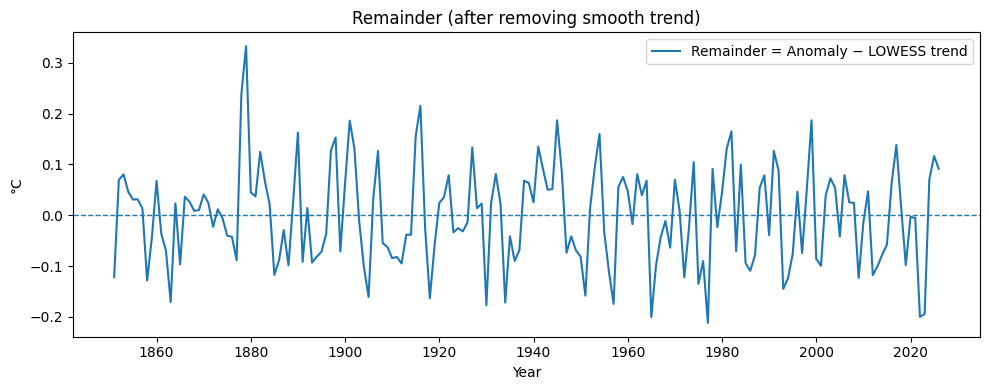

In [20]:
plt.figure(figsize=(10,4))
plt.plot(years, remainder, label='Remainder = Anomaly − LOWESS trend')
plt.axhline(0, linestyle='--', linewidth=1)
plt.title('Remainder (after removing smooth trend)')
plt.xlabel('Year'); plt.ylabel('°C'); plt.legend()
plt.tight_layout(); plt.show()


After extracting a smooth trend, the remainder is approximately mean-zero, indicating the trend captures the long-run warming. The remainder exhibits brief runs and a few spikes, consistent with short-run variability. Year-to-year changes (first differences) fluctuate around zero but occur in bursts, suggesting short-run persistence rather than pure white noise. The amplitude of deviations is generally modest (≈ ±0.1 °C, with occasional ±0.2–0.3 °C), and the spread appears to vary somewhat across periods, hinting at heteroscedasticity.

- **Centered at zero:** Year-to-year changes bounce around 0 → no leftover trend in the differences.
- **Bursts of larger moves:** Periods with consecutive positive or negative changes indicate **persistence** (changes aren’t purely random).
- **Magnitude:** Typical fluctuations are small (a few hundredths of a degree), with occasional years showing jumps near **±0.2–0.3 °C**.

**Conclusion:** ΔAnomaly shows **non-random clustering** of annual changes, suggesting some **serial dependence** in the short run (common in climate time series).


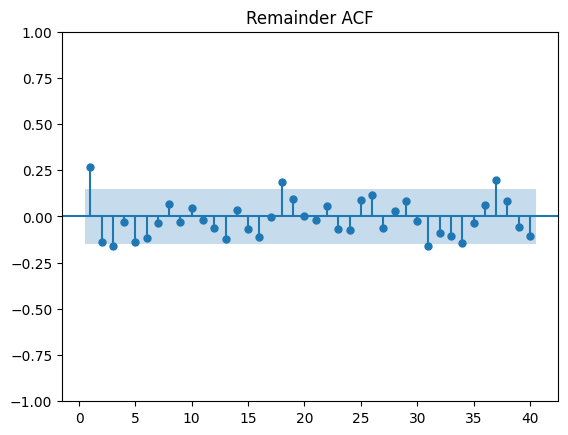

In [21]:
acf = plot_acf(remainder, bartlett_confint=False, lags=40, zero=False, title="Remainder ACF")

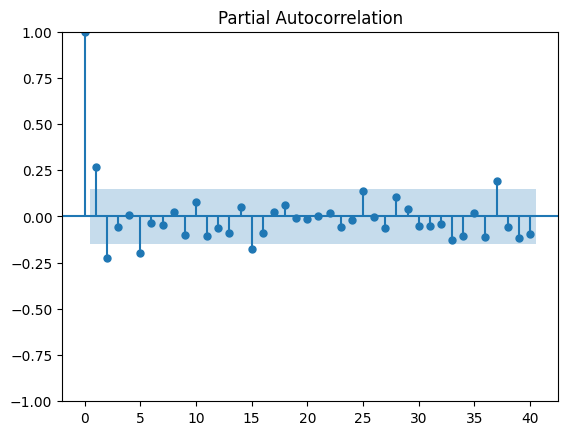

In [22]:
plot_pacf(remainder, lags=40, method='ywm');

In [23]:
df_remainder = pd.DataFrame({
    'Year': years,
    'Remainder': remainder
})
df_remainder['Year'] = df_remainder['Year'].dt.year

In [24]:
temptrain=df_remainder[df_remainder['Year']<=1990]
temptest=df_remainder[df_remainder['Year']>1990]
print ("Treino: ", temptrain.shape)
print ("Teste: ",temptest.shape)

Treino:  (141, 2)
Teste:  (35, 2)


In [25]:
train_series = temptrain.set_index('Year')['Remainder']
test_series = temptest.set_index('Year')['Remainder']

In [26]:
D = nsdiffs(df_remainder['Remainder'], m=12, test='ocsb')

print(f"Seasonal Differences required (D): {D}")

Seasonal Differences required (D): 0


In [27]:
ND=ndiffs(df_remainder['Remainder'])

print(f"Non-Seasonal Differences required (ND): {ND}")

Non-Seasonal Differences required (ND): 0


Based on the plots and the calculated value ND=0, the analysis confirms that the long-term trend has been effectively removed from the data. The Autocorrelation Function (ACF) plot shows a quick drop-off to near zero, which indicates that the warming trend is no longer dominating the series and the data is now stationary with a constant mean. There is a significant spike at Lag 1, suggesting that while the long-term trend is gone, there is still some short-term memory or persistence where an abnormally hot year tends to be followed by another somewhat hotter-than-average year.

Regarding seasonality, the visual evidence from the ACF plot aligns with the statistical test result of D=0. The ACF plot displays no repeating rhythmic spikes at intervals like 12, 24, or 36, which you would expect if there were a seasonal cycle. This confirms that the data is non-seasonal, which makes sense for annual global anomalies where seasonal weather differences are averaged out.

## Modeling  
Considering that in our data there is no seasonality, we will focus on models without any seasonal component.

### AR Model

In order to figure the adequate order for our AR model, we will need to analyse the PACF. There is an evident cut-off in lag 3, which indicates that our AR model should have an order of 3. However, we will test AR models with order 1, 2 and 3 to reach a definite conclusion.

                               SARIMAX Results                                
Dep. Variable:              Remainder   No. Observations:                  141
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 135.188
Date:                Tue, 16 Dec 2025   AIC                           -264.375
Time:                        17:58:15   BIC                           -255.529
Sample:                             0   HQIC                          -260.780
                                - 141                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.011      0.093      0.926      -0.020       0.022
ar.L1          0.2712      0.076      3.583      0.000       0.123       0.420
sigma2         0.0086      0.001      7.918      0.0

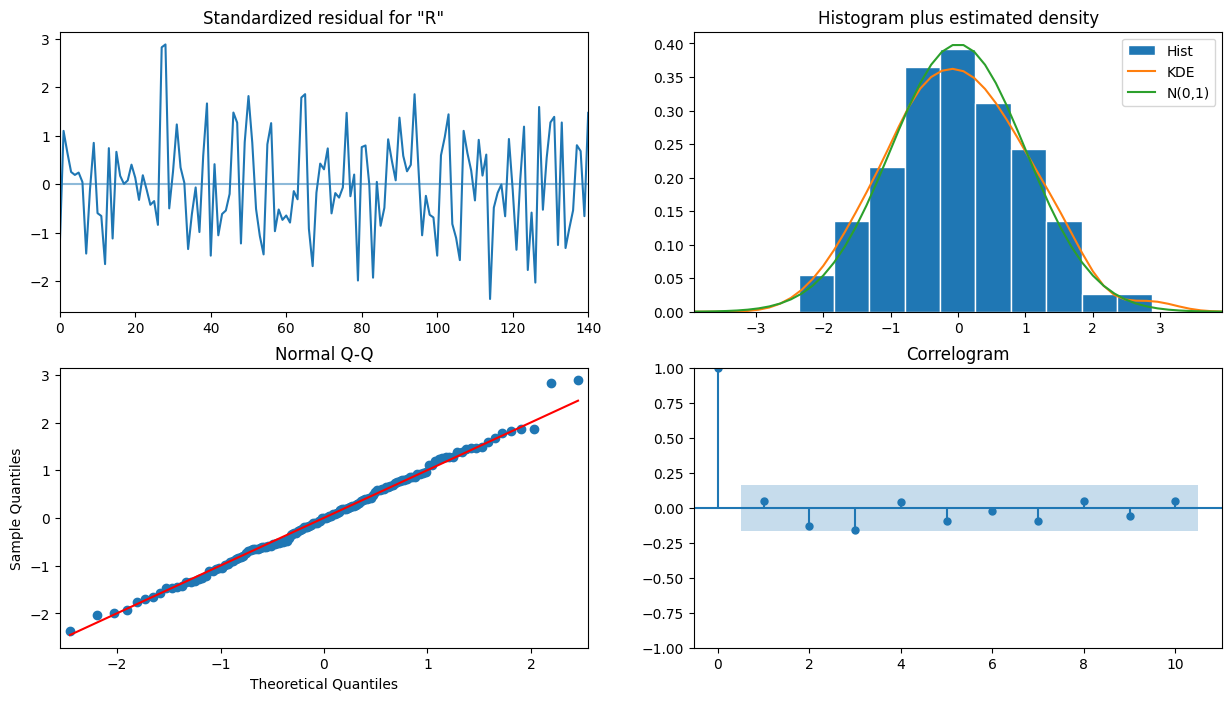

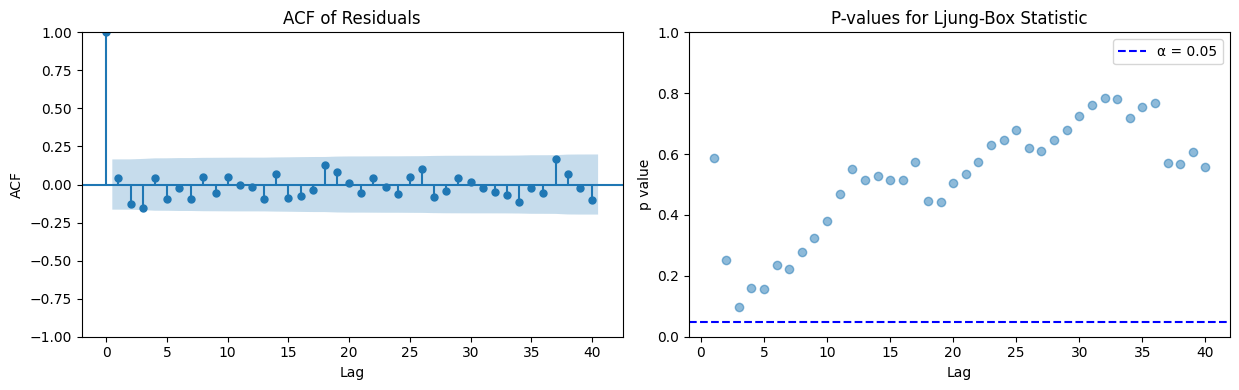

In [28]:
modelAR1 = ARIMA(train_series, order=(1,0,0)).fit()
print(modelAR1.summary())

modelAR1_residuos = modelAR1.resid
modelAR1.plot_diagnostics(figsize=(15, 8))
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12.5, 4))
plot_acf(modelAR1_residuos, lags=40, ax=axes[0])
axes[0].set_title('ACF of Residuals')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('ACF')
# plot pvalues for Ljung-Box Statictic 
lb_test = acorr_ljungbox(modelAR1_residuos, lags=40, return_df=True)
axes[1].scatter(lb_test.index, lb_test['lb_pvalue'], alpha=0.5)
axes[1].axhline(y=0.05, color='blue', linestyle='--', label='α = 0.05')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('p value')
axes[1].set_title('P-values for Ljung-Box Statistic')
axes[1].legend()
axes[1].set_ylim([0, 1])
plt.tight_layout()
plt.show()

                               SARIMAX Results                                
Dep. Variable:              Remainder   No. Observations:                  141
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 137.417
Date:                Tue, 16 Dec 2025   AIC                           -266.834
Time:                        17:58:16   BIC                           -255.039
Sample:                             0   HQIC                          -262.041
                                - 141                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.009      0.106      0.915      -0.017       0.019
ar.L1          0.3221      0.077      4.164      0.000       0.171       0.474
ar.L2         -0.1784      0.087     -2.044      0.0

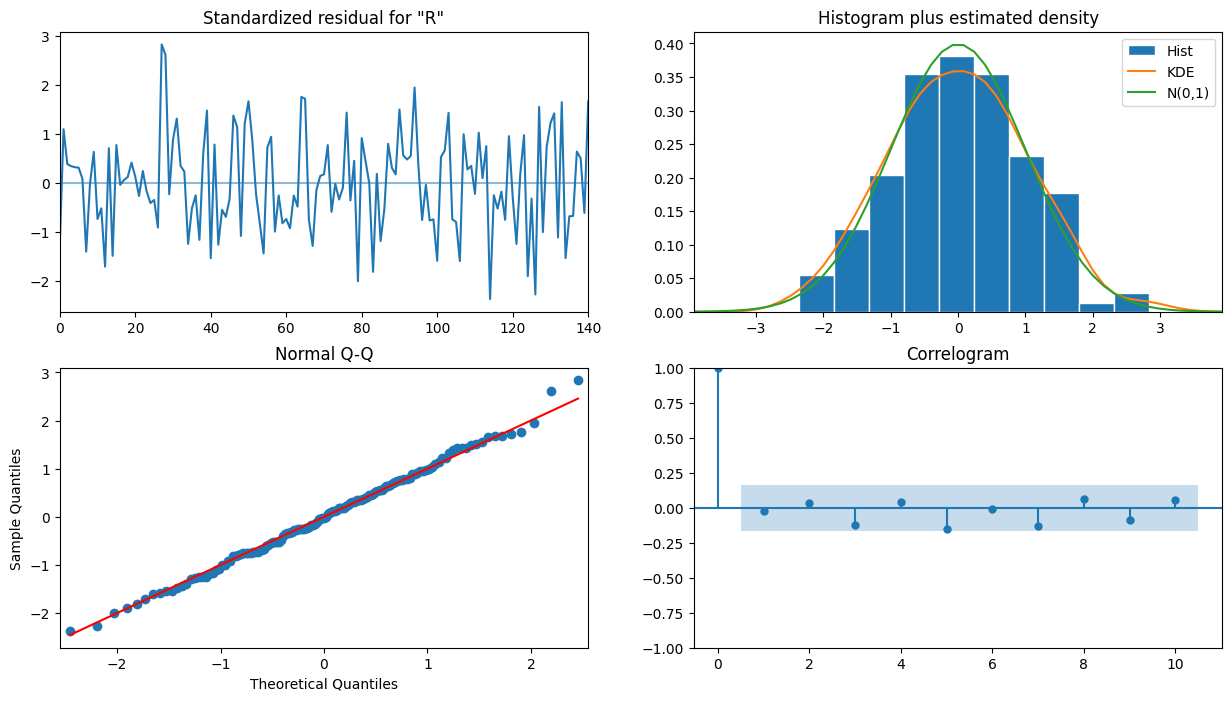

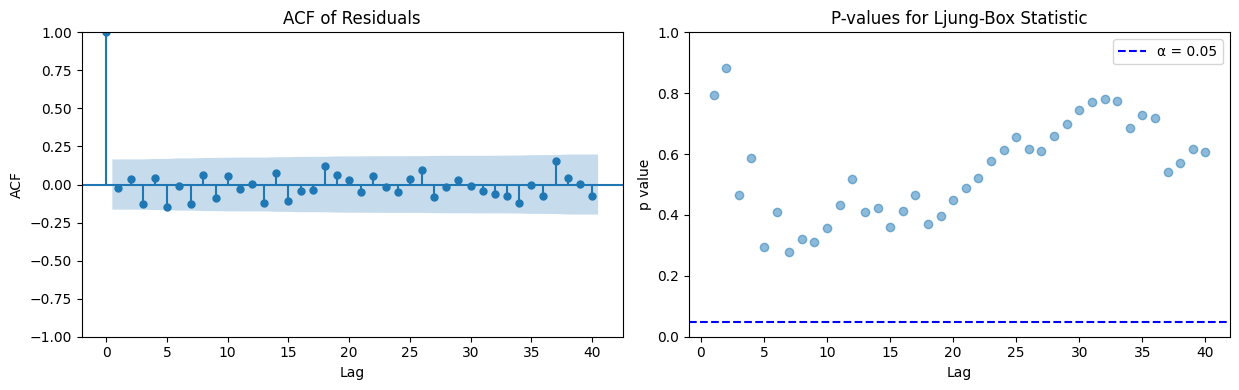

In [29]:
modelAR2 = ARIMA(train_series, order=(2,0,0)).fit()
print(modelAR2.summary())

modelAR2_residuos = modelAR2.resid
modelAR2.plot_diagnostics(figsize=(15, 8))
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12.5, 4))
plot_acf(modelAR2_residuos, lags=40, ax=axes[0])
axes[0].set_title('ACF of Residuals')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('ACF')
# plot pvalues for Ljung-Box Statictic 
lb_test = acorr_ljungbox(modelAR2_residuos, lags=40, return_df=True)
axes[1].scatter(lb_test.index, lb_test['lb_pvalue'], alpha=0.5)
axes[1].axhline(y=0.05, color='blue', linestyle='--', label='α = 0.05')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('p value')
axes[1].set_title('P-values for Ljung-Box Statistic')
axes[1].legend()
axes[1].set_ylim([0, 1])
plt.tight_layout()
plt.show()

                               SARIMAX Results                                
Dep. Variable:              Remainder   No. Observations:                  141
Model:                 ARIMA(3, 0, 0)   Log Likelihood                 138.133
Date:                Tue, 16 Dec 2025   AIC                           -266.266
Time:                        17:58:18   BIC                           -251.522
Sample:                             0   HQIC                          -260.274
                                - 141                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.009      0.098      0.922      -0.016       0.017
ar.L1          0.3032      0.078      3.884      0.000       0.150       0.456
ar.L2         -0.1440      0.091     -1.576      0.1

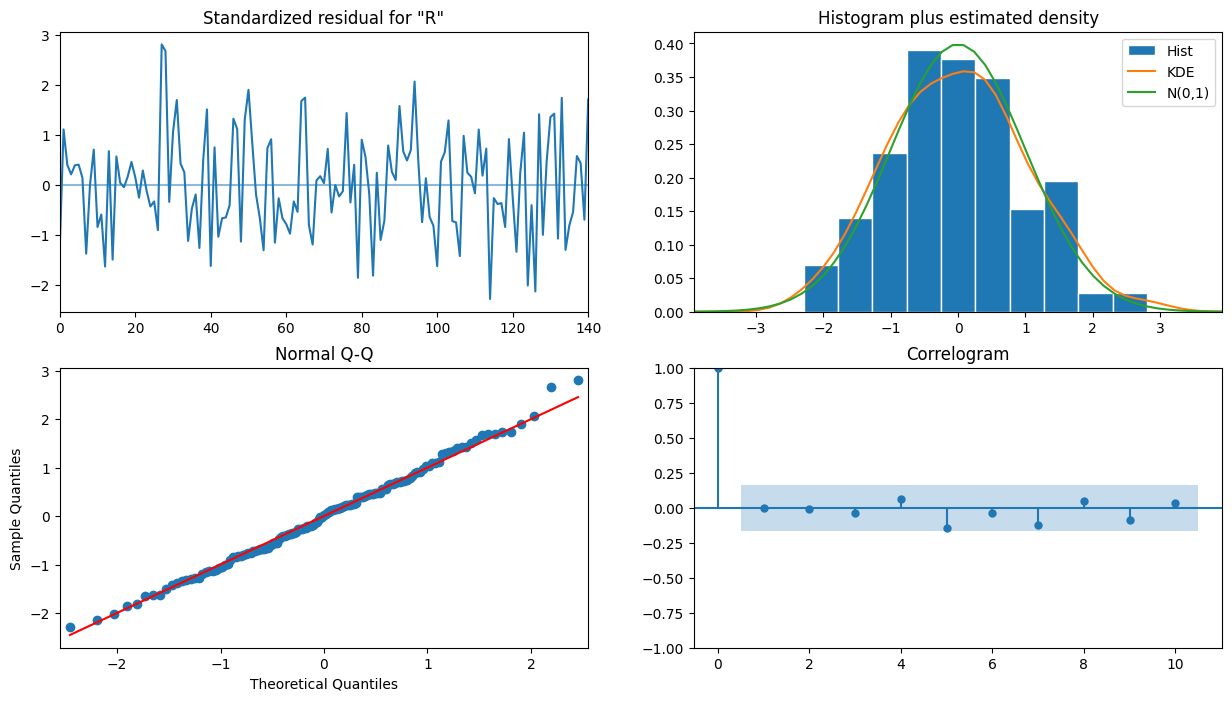

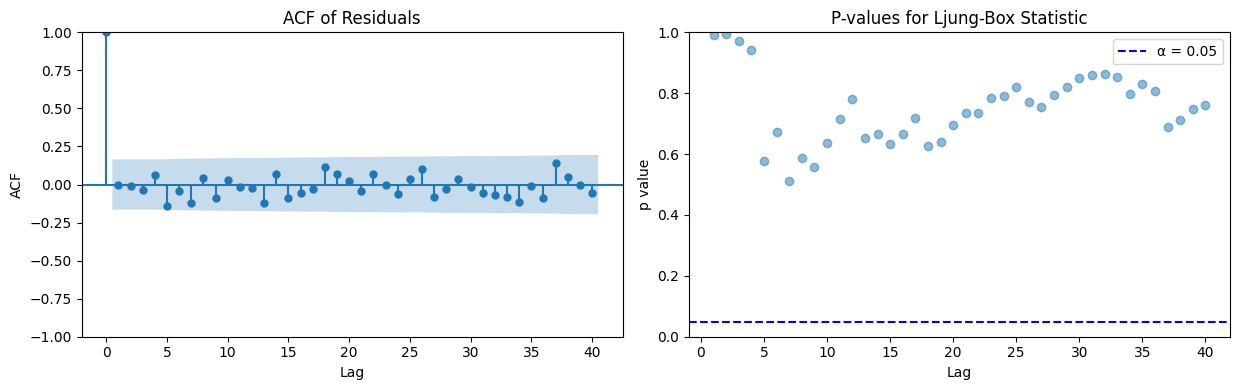

In [30]:
modelAR3 = ARIMA(train_series, order=(3,0,0)).fit()
print(modelAR3.summary())

modelAR3_residuos = modelAR3.resid
modelAR3.plot_diagnostics(figsize=(15, 8))
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12.5, 4))
plot_acf(modelAR3_residuos, lags=40, ax=axes[0])
axes[0].set_title('ACF of Residuals')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('ACF')
# plot pvalues for Ljung-Box Statictic 
lb_test = acorr_ljungbox(modelAR3_residuos, lags=40, return_df=True)
axes[1].scatter(lb_test.index, lb_test['lb_pvalue'], alpha=0.5)
axes[1].axhline(y=0.05, color='blue', linestyle='--', label='α = 0.05')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('p value')
axes[1].set_title('P-values for Ljung-Box Statistic')
axes[1].legend()
axes[1].set_ylim([0, 1])
plt.tight_layout()
plt.show()

In [31]:
ar_report = f"""
|   Model   |    BIC    |    AIC    |    AICc   |
|-----------|-----------|-----------|-----------|
|   AR(1)   | {(modelAR1.bic/len(temptrain)):.6f} | {(modelAR1.aic/len(temptrain)):.6f} | {(modelAR1.aicc/len(temptrain)):.6f} |
|   AR(2)   | {(modelAR2.bic/len(temptrain)):.6f} | {(modelAR2.aic/len(temptrain)):.6f} | {(modelAR2.aicc/len(temptrain)):.6f} |
|   AR(3)   | {(modelAR3.bic/len(temptrain)):.6f} | {(modelAR3.aic/len(temptrain)):.6f} | {(modelAR3.aicc/len(temptrain)):.6f} |
"""
print(ar_report)


|   Model   |    BIC    |    AIC    |    AICc   |
|-----------|-----------|-----------|-----------|
|   AR(1)   | -1.812261 | -1.875001 | -1.873758 |
|   AR(2)   | -1.808786 | -1.892439 | -1.890353 |
|   AR(3)   | -1.783844 | -1.888410 | -1.885257 |



For all 3 parameters, the AR model seems to be an adequate model since the residuals are never correlated or with p-values below 0.05. If we take into account the AIC, AICc and BIC results, the best model would be AR(2). However, on all 3 models there is always at least one coefficient that is not statistically significant, thus implying that the AR models are not the best fit.  
Let's then try the MA models. We must figure the q periods to use on the MA(q) model. By looking at our original residual ACF, there is an evident cut-off on lag 2, which might indicate MA(2) as the model to use. However, just like with AR models, we will try MA(1), MA(2) and MA(3).

                               SARIMAX Results                                
Dep. Variable:              Remainder   No. Observations:                  141
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 136.278
Date:                Tue, 16 Dec 2025   AIC                           -266.556
Time:                        17:58:19   BIC                           -257.709
Sample:                             0   HQIC                          -262.961
                                - 141                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.010      0.099      0.921      -0.019       0.021
ma.L1          0.3071      0.072      4.241      0.000       0.165       0.449
sigma2         0.0085      0.001      7.937      0.0

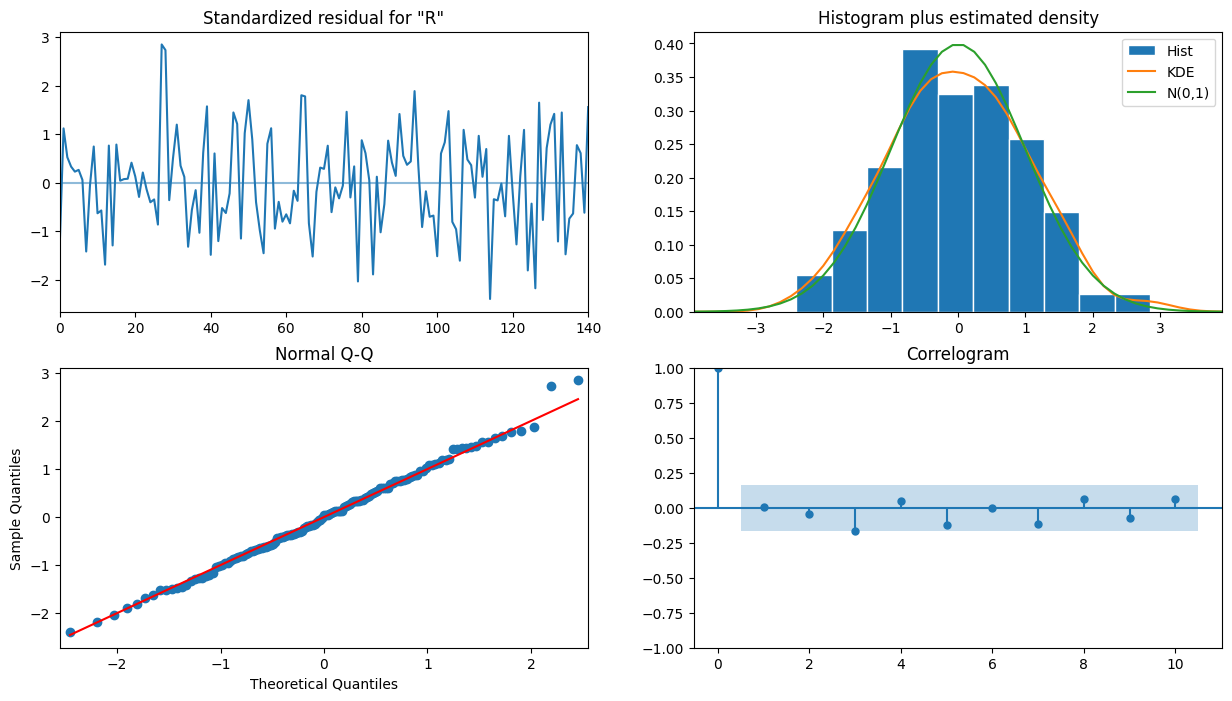

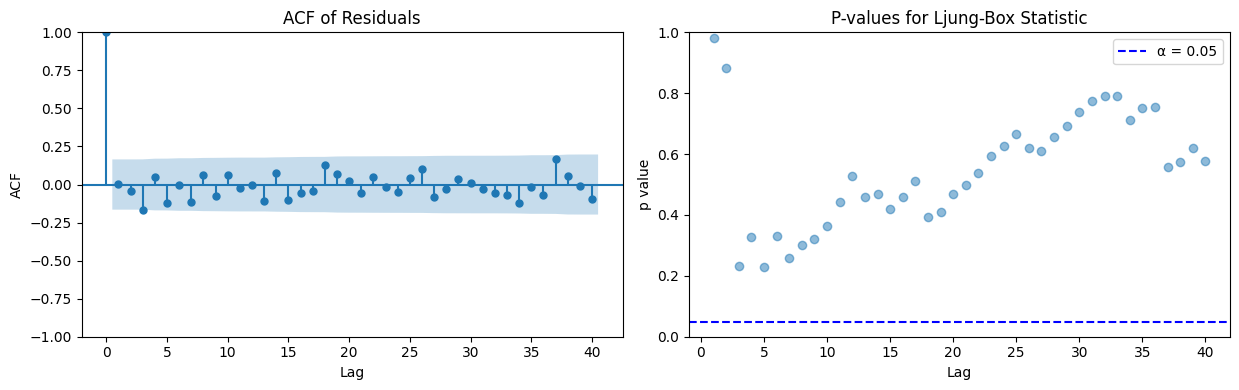

In [32]:
modelMA1 = ARIMA(train_series, order=(0,0,1)).fit()
print(modelMA1.summary())

modelMA1_residuos = modelMA1.resid
modelMA1.plot_diagnostics(figsize=(15, 8))
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12.5, 4))
plot_acf(modelMA1_residuos, lags=40, ax=axes[0])
axes[0].set_title('ACF of Residuals')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('ACF')
# plot pvalues for Ljung-Box Statictic 
lb_test = acorr_ljungbox(modelMA1_residuos, lags=40, return_df=True)
axes[1].scatter(lb_test.index, lb_test['lb_pvalue'], alpha=0.5)
axes[1].axhline(y=0.05, color='blue', linestyle='--', label='α = 0.05')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('p value')
axes[1].set_title('P-values for Ljung-Box Statistic')
axes[1].legend()
axes[1].set_ylim([0, 1])
plt.tight_layout()
plt.show()

                               SARIMAX Results                                
Dep. Variable:              Remainder   No. Observations:                  141
Model:                 ARIMA(0, 0, 2)   Log Likelihood                 136.299
Date:                Tue, 16 Dec 2025   AIC                           -264.599
Time:                        17:58:21   BIC                           -252.804
Sample:                             0   HQIC                          -259.806
                                - 141                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.011      0.095      0.925      -0.020       0.022
ma.L1          0.3192      0.076      4.174      0.000       0.169       0.469
ma.L2          0.0190      0.094      0.201      0.8

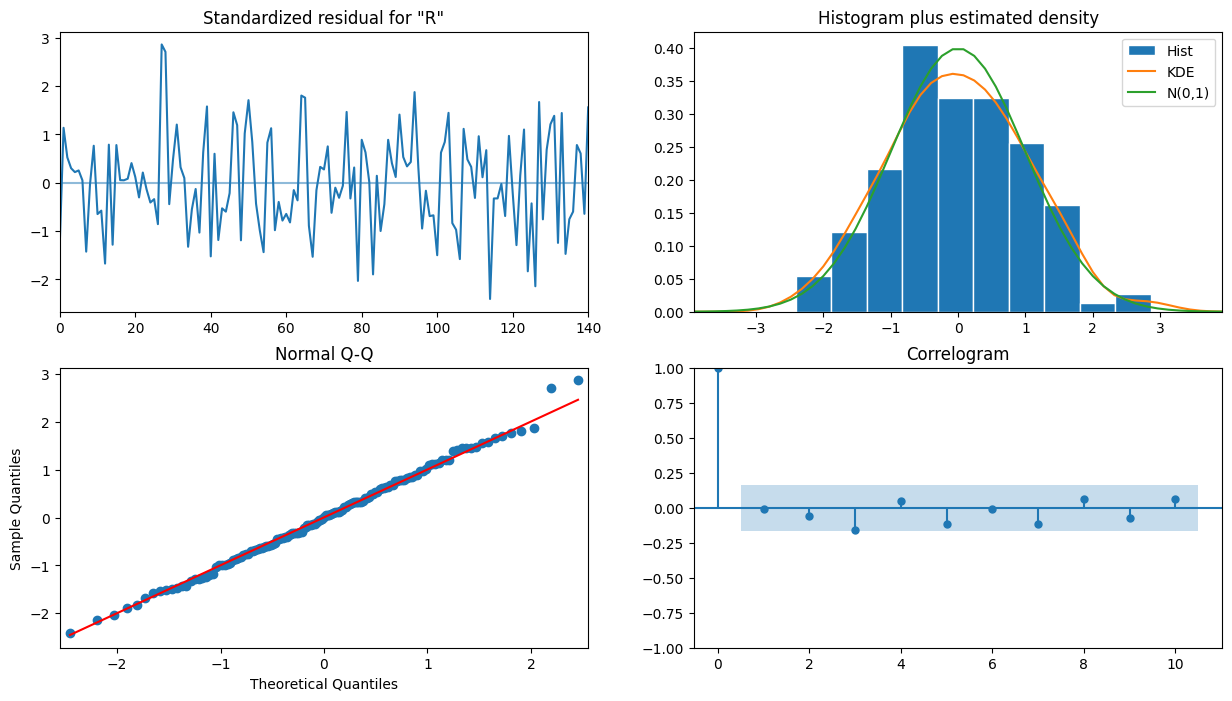

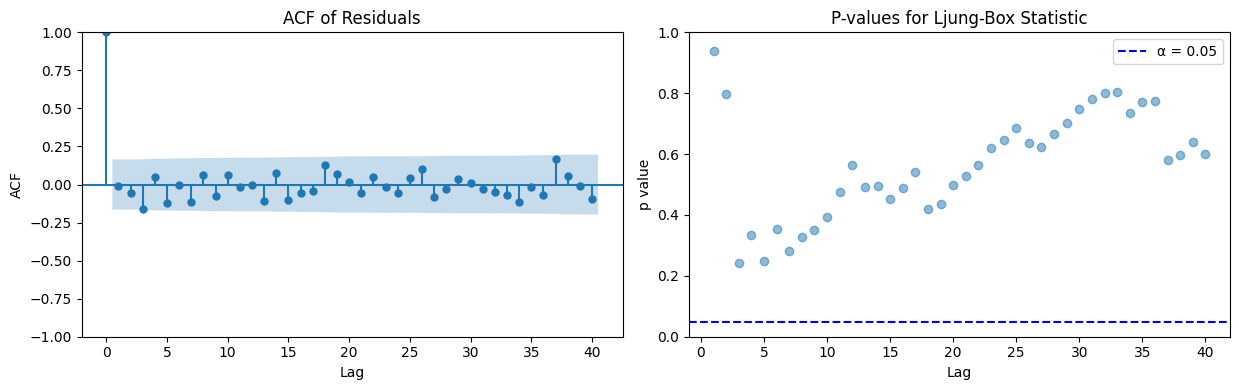

In [33]:
modelMA2 = ARIMA(train_series, order=(0,0,2)).fit()
print(modelMA2.summary())

modelMA2_residuos = modelMA2.resid
modelMA2.plot_diagnostics(figsize=(15, 8))
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12.5, 4))
plot_acf(modelMA2_residuos, lags=40, ax=axes[0])
axes[0].set_title('ACF of Residuals')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('ACF')
# plot pvalues for Ljung-Box Statictic 
lb_test = acorr_ljungbox(modelMA2_residuos, lags=40, return_df=True)
axes[1].scatter(lb_test.index, lb_test['lb_pvalue'], alpha=0.5)
axes[1].axhline(y=0.05, color='blue', linestyle='--', label='α = 0.05')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('p value')
axes[1].set_title('P-values for Ljung-Box Statistic')
axes[1].legend()
axes[1].set_ylim([0, 1])
plt.tight_layout()
plt.show()

                               SARIMAX Results                                
Dep. Variable:              Remainder   No. Observations:                  141
Model:                 ARIMA(0, 0, 3)   Log Likelihood                 139.109
Date:                Tue, 16 Dec 2025   AIC                           -268.219
Time:                        17:58:22   BIC                           -253.475
Sample:                             0   HQIC                          -262.227
                                - 141                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.008      0.105      0.916      -0.015       0.017
ma.L1          0.3078      0.076      4.028      0.000       0.158       0.457
ma.L2         -0.0936      0.095     -0.990      0.3

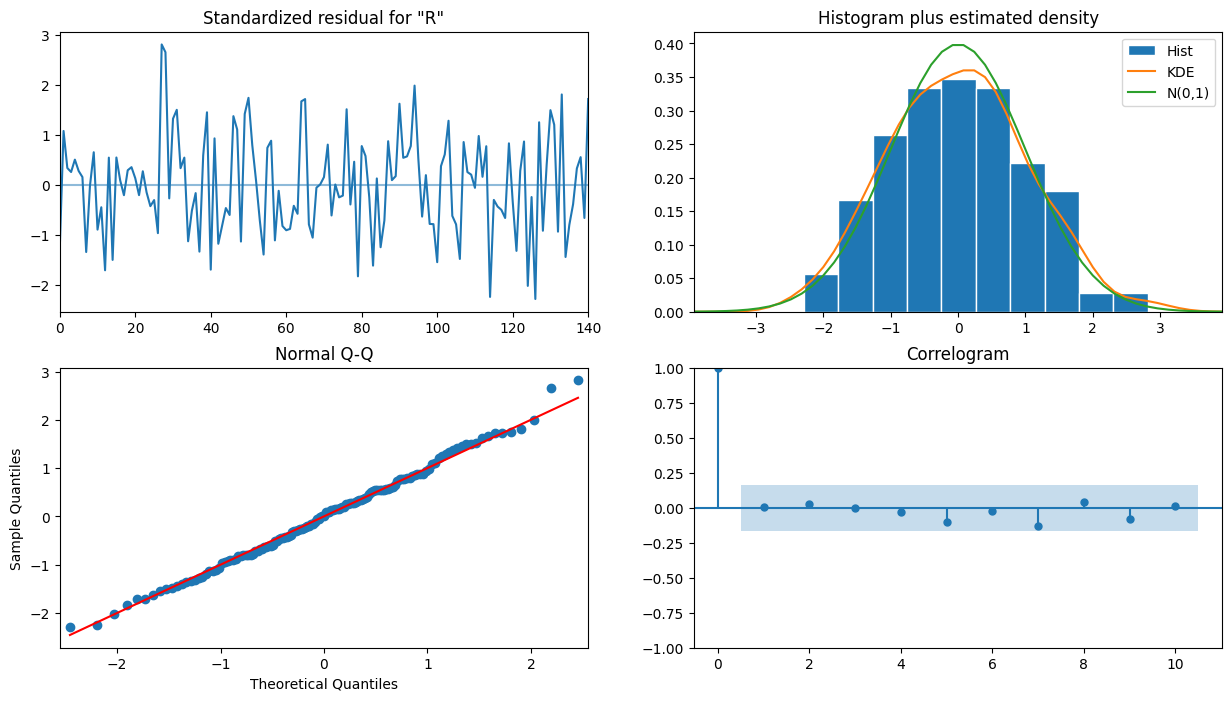

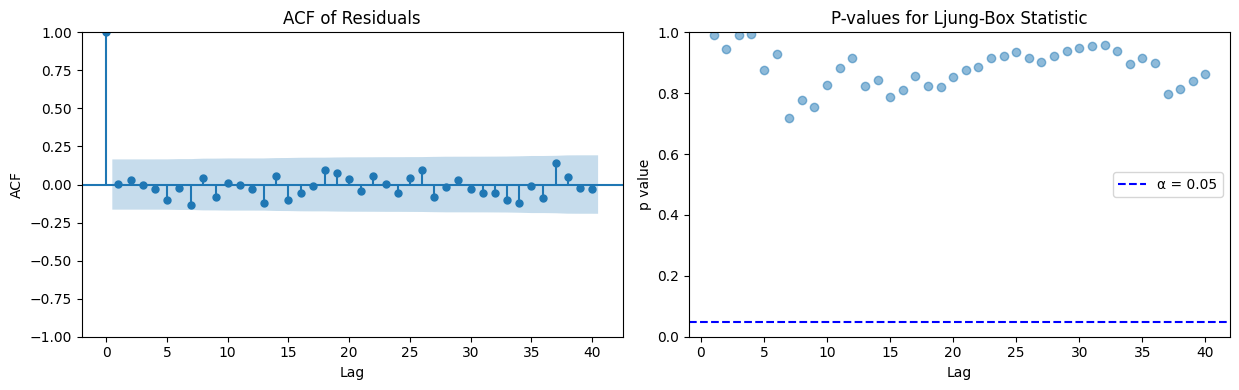

In [34]:
modelMA3 = ARIMA(train_series, order=(0,0,3)).fit()
print(modelMA3.summary())

modelMA3_residuos = modelMA3.resid
modelMA3.plot_diagnostics(figsize=(15, 8))
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12.5, 4))
plot_acf(modelMA3_residuos, lags=40, ax=axes[0])
axes[0].set_title('ACF of Residuals')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('ACF')
# plot pvalues for Ljung-Box Statictic 
lb_test = acorr_ljungbox(modelMA3_residuos, lags=40, return_df=True)
axes[1].scatter(lb_test.index, lb_test['lb_pvalue'], alpha=0.5)
axes[1].axhline(y=0.05, color='blue', linestyle='--', label='α = 0.05')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('p value')
axes[1].set_title('P-values for Ljung-Box Statistic')
axes[1].legend()
axes[1].set_ylim([0, 1])
plt.tight_layout()
plt.show()

In [35]:
ma_report = f"""
|   Model   |    BIC    |    AIC    |    AICc   |
|-----------|-----------|-----------|-----------|
|   MA(1)   | {(modelMA1.bic/len(temptrain)):.6f} | {(modelMA1.aic/len(temptrain)):.6f} | {(modelMA1.aicc/len(temptrain)):.6f} |
|   MA(2)   | {(modelMA2.bic/len(temptrain)):.6f} | {(modelMA2.aic/len(temptrain)):.6f} | {(modelMA2.aicc/len(temptrain)):.6f} |
|   MA(3)   | {(modelMA3.bic/len(temptrain)):.6f} | {(modelMA3.aic/len(temptrain)):.6f} | {(modelMA3.aicc/len(temptrain)):.6f} |
"""
print(ma_report)


|   Model   |    BIC    |    AIC    |    AICc   |
|-----------|-----------|-----------|-----------|
|   MA(1)   | -1.827727 | -1.890466 | -1.889224 |
|   MA(2)   | -1.792933 | -1.876586 | -1.874500 |
|   MA(3)   | -1.797693 | -1.902259 | -1.899107 |



Again, looking at the 3 models, all show uncorrelated residuals and with p-values for the Ljung-Box test above 0.05, thus none is automatically excluded. If we take into account the measures  AIC, BIC and AICc then the best model is the MA(3). However, similar to what happened with the AR models, there's always one coefficient that is not statistically significant.
Let's then try an ARMA model with the best parameters identified above for each of the AR and MA models, ARMA(2,3).

                               SARIMAX Results                                
Dep. Variable:              Remainder   No. Observations:                  141
Model:                 ARIMA(2, 0, 3)   Log Likelihood                 143.425
Date:                Tue, 16 Dec 2025   AIC                           -272.849
Time:                        17:58:24   BIC                           -252.208
Sample:                             0   HQIC                          -264.461
                                - 141                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.002      0.601      0.548      -0.003       0.006
ar.L1         -0.0821      0.113     -0.729      0.466      -0.303       0.139
ar.L2          0.7845      0.112      7.021      0.0

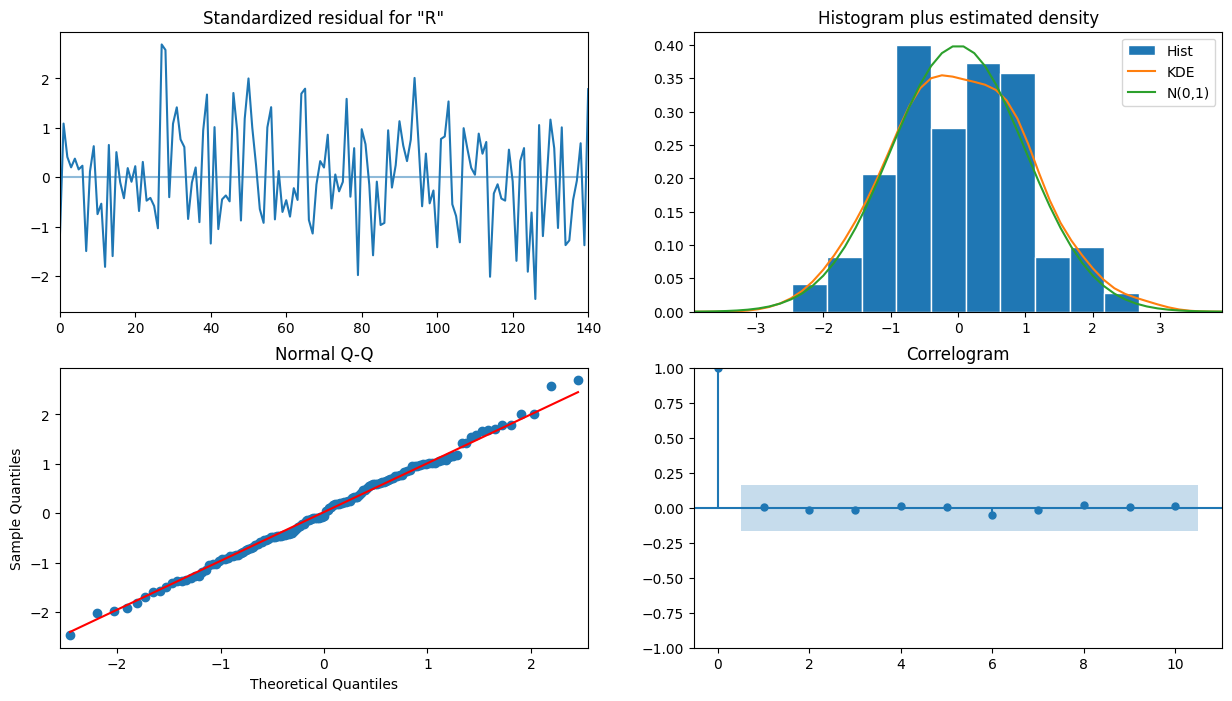

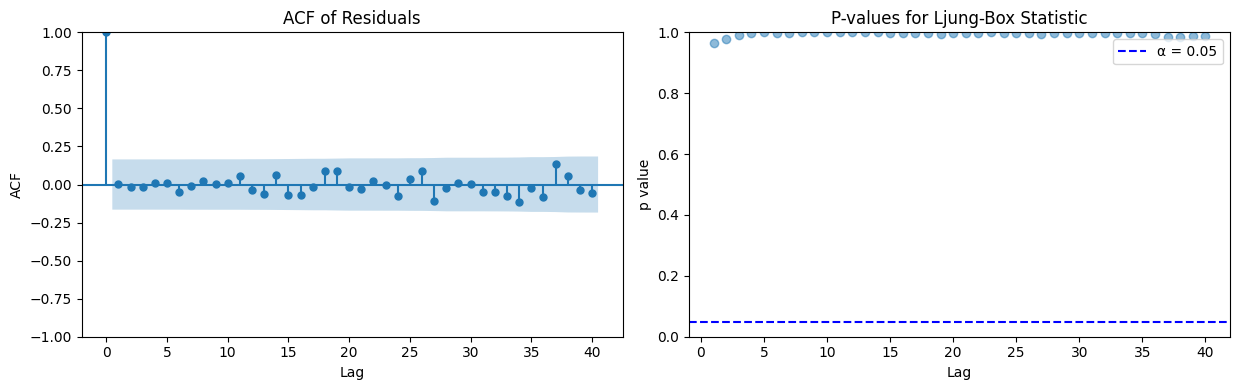

In [36]:
modelARMA = ARIMA(train_series, order=(2,0,3)).fit()
print(modelARMA.summary())

modelARMA_residuos = modelARMA.resid
modelARMA.plot_diagnostics(figsize=(15, 8))
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12.5, 4))
plot_acf(modelARMA_residuos, lags=40, ax=axes[0])
axes[0].set_title('ACF of Residuals')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('ACF')
# plot pvalues for Ljung-Box Statictic 
lb_test = acorr_ljungbox(modelARMA_residuos, lags=40, return_df=True)
axes[1].scatter(lb_test.index, lb_test['lb_pvalue'], alpha=0.5)
axes[1].axhline(y=0.05, color='blue', linestyle='--', label='α = 0.05')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('p value')
axes[1].set_title('P-values for Ljung-Box Statistic')
axes[1].legend()
axes[1].set_ylim([0, 1])
plt.tight_layout()
plt.show()

With the ARMA(2,3) model the residuals are not correlated, the p-values for the Ljung-Box test show that for all lags the residuals are statistically significant and all the residuals have a symmetric distribution with slightly heavier tails than the Gaussian. When it comes to the coefficients, all are statistically significant (with the constant being a bit above 0.05, which will not be considered).
Now that the best model for our data is found, it's time to forecast.

## Forecasting

In [37]:
y = ts["Anomaly"].astype(float).sort_index()

train_end = pd.Timestamp("1990-12-31")
test_start = pd.Timestamp("1991-12-31")
test_end   = pd.Timestamp("2025-12-31")

y_train = y.loc[:train_end]
y_test  = y.loc[test_start:test_end]

print("Train:", y_train.index.min(), "->", y_train.index.max(), "n=", len(y_train))
print("Test: ", y_test.index.min(),  "->", y_test.index.max(),  "n=", len(y_test))

Train: 1850-12-31 00:00:00 -> 1990-12-31 00:00:00 n= 141
Test:  1991-12-31 00:00:00 -> 2025-12-31 00:00:00 n= 35


### Let's look at simple methods to test if other forecasts can beat simple methods

In [38]:
def _mae_rmse(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse

def plot_rolling_full(y, pred, lo, hi, title):
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(y.index, y.values, linewidth=1.5, label="Observed (full series)")
    ax.plot(pred.index, pred.values, linewidth=2, marker="o", markersize=3,
            label=f"Rolling 1-step forecast ({pred.name})")
    ax.fill_between(pred.index, lo.values, hi.values, alpha=0.22,
                    label="95% prediction interval (approx)")

    # Optional: mark test start if variable exists
    try:
        ax.axvline(test_start, linestyle="--", alpha=0.6, label="Test start")
    except NameError:
        pass

    ax.set_title(title)
    ax.set_xlabel("Time")
    ax.set_ylabel("Temperature anomaly (°C)")
    ax.grid(True, alpha=0.3, linestyle=":")
    ax.legend(frameon=False, loc="lower right")
    plt.tight_layout()
    plt.show()


First: what these 3 methods are (super simple)

- Naïve: “Next year = last year.”
Good baseline for many time series.

- Drift: “Next year = last year + average long-term yearly increase.”
Great baseline when there’s a trend (like temperature anomalies).

- Holt (linear trend): Like drift, but the trend is smoothed and updated over time (more flexible than a single average slope).

##### Holt

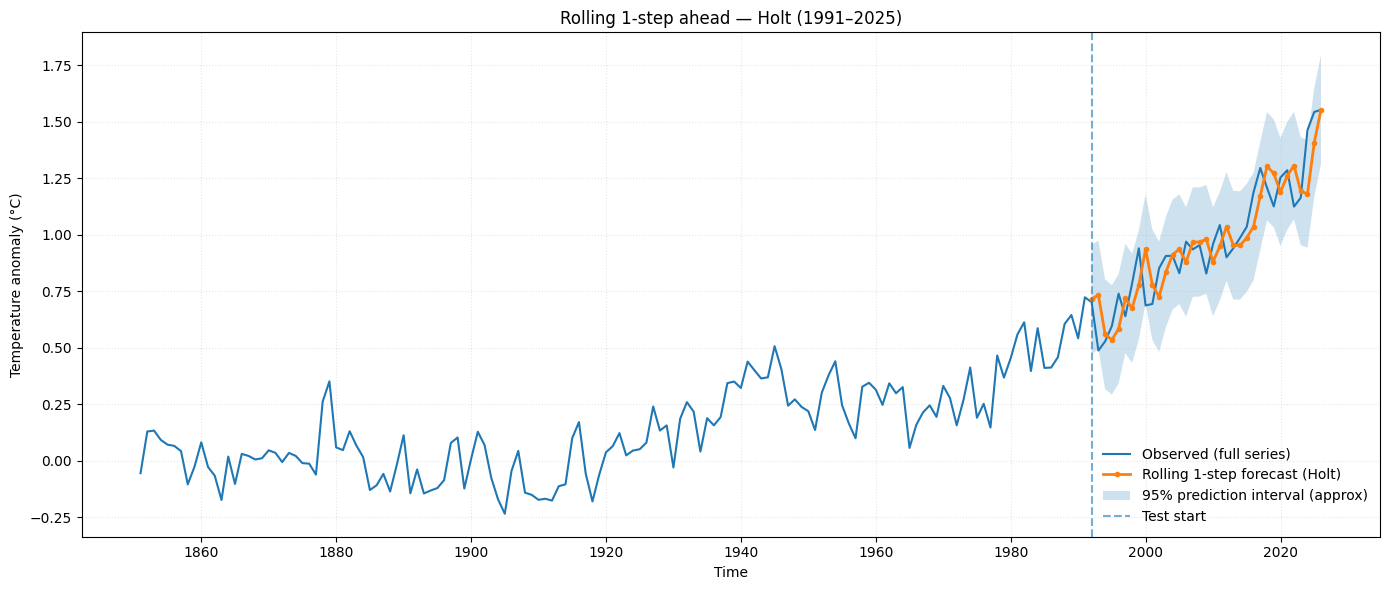

Holt -> MAE=0.0981, RMSE=0.1210, approx 95% coverage=0.914


In [39]:
preds, lo, hi = [], [], []

for t in y_test.index:
    train = y.loc[:t].iloc[:-1]

    fit = Holt(train, damped_trend=False).fit(optimized=True)
    yhat = fit.forecast(1).iloc[0]

    resid = (train - fit.fittedvalues).dropna()
    s = resid.std(ddof=1) if len(resid) > 2 else 0.0

    preds.append(yhat)
    lo.append(yhat - 1.96*s)
    hi.append(yhat + 1.96*s)

holt_pred = pd.Series(preds, index=y_test.index, name="Holt")
holt_lo   = pd.Series(lo,    index=y_test.index, name="PI lower 95%")
holt_hi   = pd.Series(hi,    index=y_test.index, name="PI upper 95%")

plot_rolling_full(y, holt_pred, holt_lo, holt_hi,
                  "Rolling 1-step ahead — Holt (1991–2025)")

mae, rmse = _mae_rmse(y_test, holt_pred)
coverage = ((y_test >= holt_lo) & (y_test <= holt_hi)).mean()
print(f"Holt -> MAE={mae:.4f}, RMSE={rmse:.4f}, approx 95% coverage={coverage:.3f}")


Holt:
Holt  -> MAE=0.0981, RMSE=0.1210, approx. 95% coverage=0.914

#### Naive

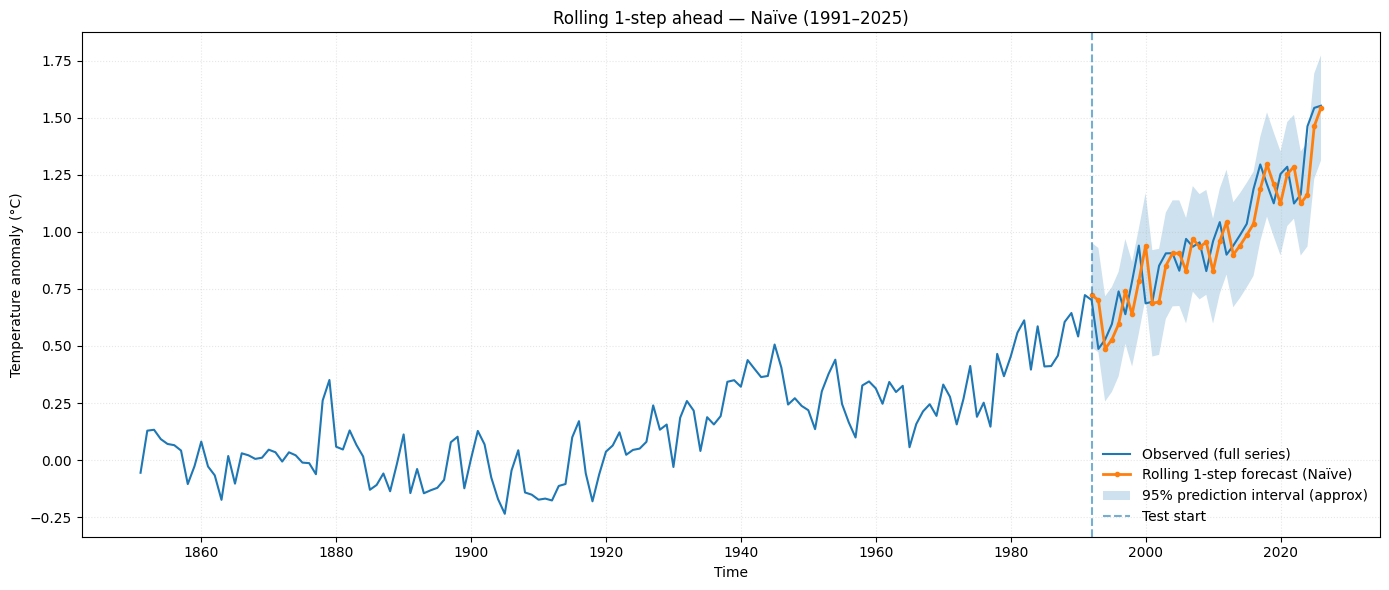

Naïve -> MAE=0.0980, RMSE=0.1200, approx 95% coverage=0.943


In [40]:
preds, lo, hi = [], [], []

for t in y_test.index:
    train = y.loc[:t].iloc[:-1]      # strictly before t
    yhat = train.iloc[-1]            # naive forecast

    diffs = train.diff().dropna()    # 1-step naive errors
    s = diffs.std(ddof=1) if len(diffs) > 2 else 0.0

    preds.append(yhat)
    lo.append(yhat - 1.96*s)
    hi.append(yhat + 1.96*s)

naive_pred = pd.Series(preds, index=y_test.index, name="Naïve")
naive_lo   = pd.Series(lo,    index=y_test.index, name="PI lower 95%")
naive_hi   = pd.Series(hi,    index=y_test.index, name="PI upper 95%")

plot_rolling_full(y, naive_pred, naive_lo, naive_hi,
                  "Rolling 1-step ahead — Naïve (1991–2025)")

mae, rmse = _mae_rmse(y_test, naive_pred)
coverage = ((y_test >= naive_lo) & (y_test <= naive_hi)).mean()
print(f"Naïve -> MAE={mae:.4f}, RMSE={rmse:.4f}, approx 95% coverage={coverage:.3f}")


#### Drift

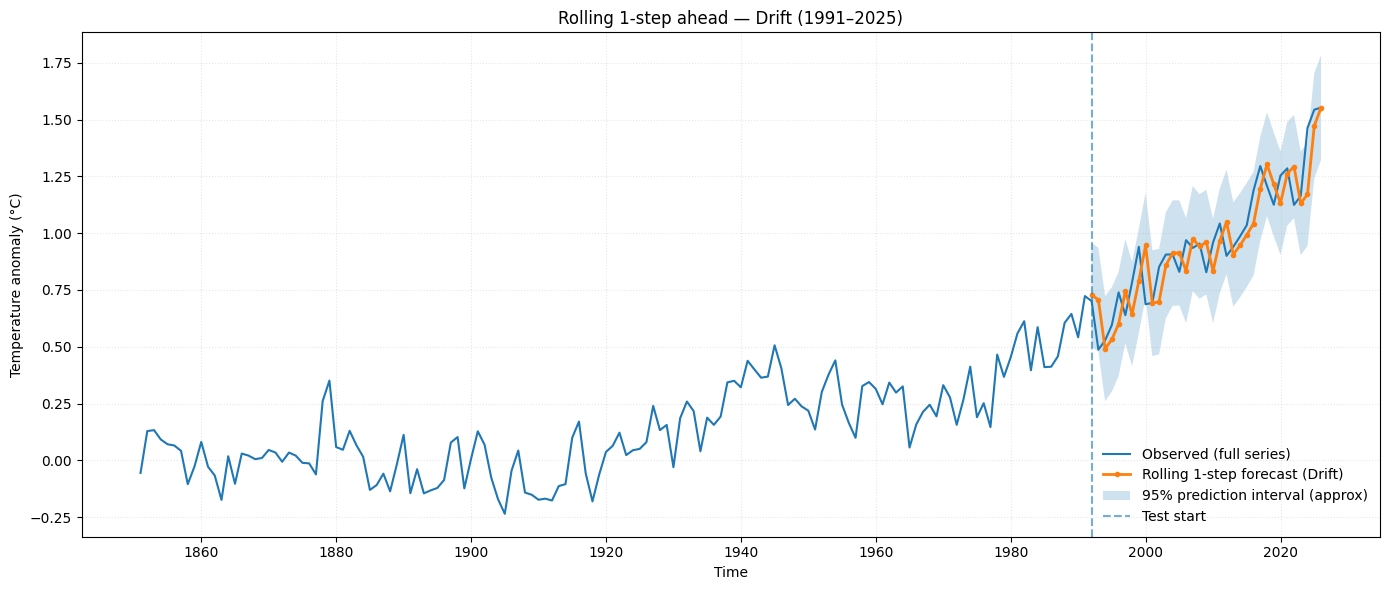

Drift -> MAE=0.0961, RMSE=0.1191, approx 95% coverage=0.943


In [41]:
preds, lo, hi = [], [], []

for t in y_test.index:
    train = y.loc[:t].iloc[:-1]
    n = len(train)

    slope = (train.iloc[-1] - train.iloc[0]) / max(n - 1, 1)
    yhat = train.iloc[-1] + slope

    resid = (train - (train.shift(1) + slope)).iloc[1:].dropna()
    s = resid.std(ddof=1) if len(resid) > 2 else 0.0

    preds.append(yhat)
    lo.append(yhat - 1.96*s)
    hi.append(yhat + 1.96*s)

drift_pred = pd.Series(preds, index=y_test.index, name="Drift")
drift_lo   = pd.Series(lo,    index=y_test.index, name="PI lower 95%")
drift_hi   = pd.Series(hi,    index=y_test.index, name="PI upper 95%")

plot_rolling_full(y, drift_pred, drift_lo, drift_hi,
                  "Rolling 1-step ahead — Drift (1991–2025)")

mae, rmse = _mae_rmse(y_test, drift_pred)
coverage = ((y_test >= drift_lo) & (y_test <= drift_hi)).mean()
print(f"Drift -> MAE={mae:.4f}, RMSE={rmse:.4f}, approx 95% coverage={coverage:.3f}")


### Forecast 1 year at a time (example forecast 1991 using real data, then wait to get 1991 real data and use it to forecast 1992)

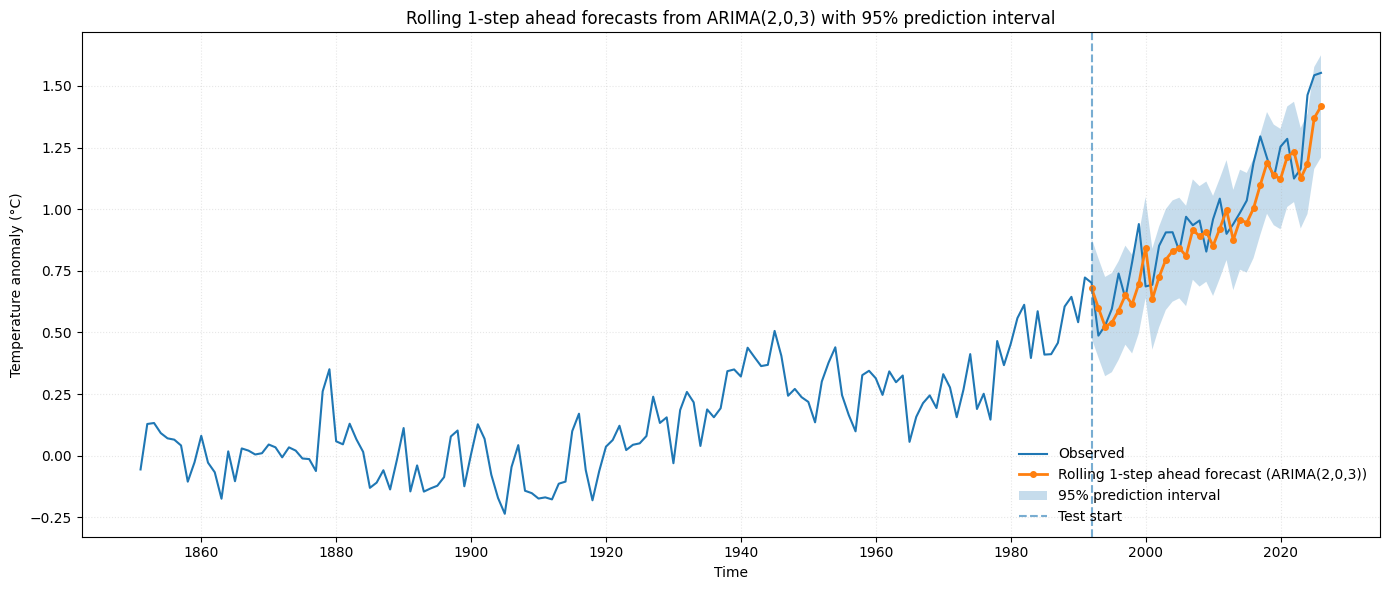


Rolling 1-step ahead forecasts (with 95% PI):
            forecast  pi_lower_95  pi_upper_95
1991-12-31  0.679910     0.477859     0.881960
1992-12-31  0.599720     0.398416     0.801023
1993-12-31  0.523998     0.322770     0.725226
1994-12-31  0.539722     0.338775     0.740670
1995-12-31  0.588826     0.388777     0.788876
1996-12-31  0.651179     0.450327     0.852030
1997-12-31  0.615067     0.414907     0.815227
1998-12-31  0.697510     0.496309     0.898711
1999-12-31  0.844457     0.639708     1.049207
2000-12-31  0.635059     0.430282     0.839835
2001-12-31  0.724763     0.520517     0.929009
2002-12-31  0.795510     0.590888     1.000131
2003-12-31  0.830110     0.624772     1.035449
2004-12-31  0.842498     0.638419     1.046577
2005-12-31  0.810362     0.606810     1.013915
2006-12-31  0.917279     0.713706     1.120852
2007-12-31  0.889776     0.686019     1.093532
2008-12-31  0.908832     0.705661     1.112002
2009-12-31  0.851040     0.648089     1.053990
2010-12-31  0

In [42]:
pred_dates = []
pred_values = []
lower_95, upper_95 = [], []

for t in y_test.index:
    # Expanding training: all observations strictly before t
    train_series = y.loc[:t].iloc[:-1]

    # sanity check: train must end before the target date
    assert train_series.index.max() < t

    fit = ARIMA(train_series, order=(2, 0, 3)).fit()

    fc = fit.get_forecast(steps=1)
    yhat = fc.predicted_mean.iloc[0]
    ci = fc.conf_int(alpha=0.05).iloc[0]   # 95% PI

    pred_dates.append(t)
    pred_values.append(yhat)
    lower_95.append(ci[0])
    upper_95.append(ci[1])

ARIMA_1step = pd.Series(pred_values, index=pd.DatetimeIndex(pred_dates), name="1-step ahead forecast")
PI_lower    = pd.Series(lower_95,    index=pd.DatetimeIndex(pred_dates), name="PI lower 95%")
PI_upper    = pd.Series(upper_95,    index=pd.DatetimeIndex(pred_dates), name="PI upper 95%")

# --- Plot (full series + test forecasts)
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(y.index, y.values, linewidth=1.5, label="Observed")

ax.plot(ARIMA_1step.index, ARIMA_1step.values,
        linewidth=2, marker="o", markersize=4,
        label="Rolling 1-step ahead forecast (ARIMA(2,0,3))")

ax.fill_between(ARIMA_1step.index, PI_lower.values, PI_upper.values,
                alpha=0.25, label="95% prediction interval")

try:
    ax.axvline(test_start, linestyle="--", alpha=0.6, label="Test start")
except NameError:
    pass

ax.set_title("Rolling 1-step ahead forecasts from ARIMA(2,0,3) with 95% prediction interval")
ax.set_xlabel("Time")
ax.set_ylabel("Temperature anomaly (°C)")
ax.grid(True, alpha=0.3, linestyle=":")
ax.legend(loc="lower right", frameon=False)

plt.tight_layout()
plt.show()

# --- Table
results = pd.DataFrame({
    "forecast": ARIMA_1step,
    "pi_lower_95": PI_lower,
    "pi_upper_95": PI_upper
})
print("\nRolling 1-step ahead forecasts (with 95% PI):")
print(results)

# --- Accuracy on test window
mae = mean_absolute_error(y_test, ARIMA_1step)
rmse = np.sqrt(mean_squared_error(y_test, ARIMA_1step))
print(f"\nMAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


In [43]:
rows = []

rows.append(["ARIMA(2,0,3)", mae, rmse, coverage])  

def row_for(name, y_true, y_pred, lo, hi):
    mae_b = mean_absolute_error(y_true, y_pred)
    rmse_b = np.sqrt(mean_squared_error(y_true, y_pred))
    cov_b = ((y_true >= lo) & (y_true <= hi)).mean()
    return [name, mae_b, rmse_b, cov_b]

rows.append(row_for("Naïve", y_test, naive_pred, naive_lo, naive_hi))
rows.append(row_for("Drift", y_test, drift_pred, drift_lo, drift_hi))
rows.append(row_for("Holt (approx PI)", y_test, holt_pred, holt_lo, holt_hi))

compare_all = pd.DataFrame(rows, columns=["Model","MAE","RMSE","95%_PI_Coverage"]).sort_values("RMSE")
print(compare_all)



              Model       MAE      RMSE  95%_PI_Coverage
2             Drift  0.096140  0.119133         0.942857
1             Naïve  0.097982  0.120003         0.942857
0      ARIMA(2,0,3)  0.099869  0.120650         0.942857
3  Holt (approx PI)  0.098073  0.120975         0.914286


In the rolling 1-step ahead evaluation (1991–2025), the Drift baseline achieved the best performance (MAE=0.0961, RMSE=0.1191). The Naïve method was a close second. ARIMA(2,0,3) did not outperform the baselines, suggesting that most forecast skill comes from the underlying trend rather than additional ARMA dynamics. The 95% prediction intervals were well calibrated for Drift/Naïve/ARIMA (coverage ≈ 0.94), while Holt’s approximate intervals under-covered (≈0.91).

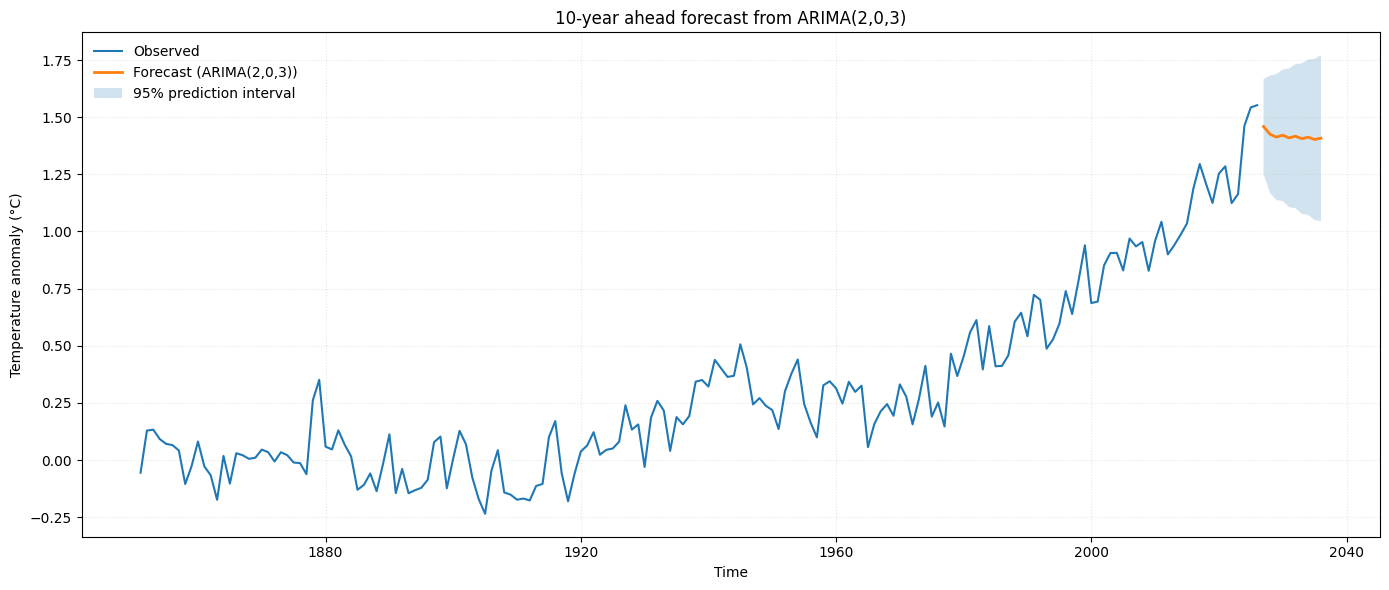

In [44]:
H = 10  # forecast horizon in years

fit_full = ARIMA(ts["Anomaly"], order=(2,0,3)).fit()
fc_full = fit_full.get_forecast(steps=H)
mean_fc = fc_full.predicted_mean
ci_fc = fc_full.conf_int(alpha=0.05)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(ts.index, ts["Anomaly"], linewidth=1.5, label="Observed")
ax.plot(mean_fc.index, mean_fc.values, linewidth=2, label="Forecast (ARIMA(2,0,3))")
ax.fill_between(mean_fc.index, ci_fc.iloc[:,0].values, ci_fc.iloc[:,1].values, alpha=0.2, label="95% prediction interval")

ax.set_title(f"{H}-year ahead forecast from ARIMA(2,0,3)")
ax.set_xlabel("Time")
ax.set_ylabel("Temperature anomaly (°C)")
ax.grid(True, alpha=0.3, linestyle=":")
ax.legend(frameon=False)
plt.tight_layout()
plt.show()


**We didn't have the trend in consideration**


ARIMA(2, 1, 3) -> MAE=0.0955, RMSE=0.1172, 95% PI coverage=0.885714
Inside count: 31 / 35


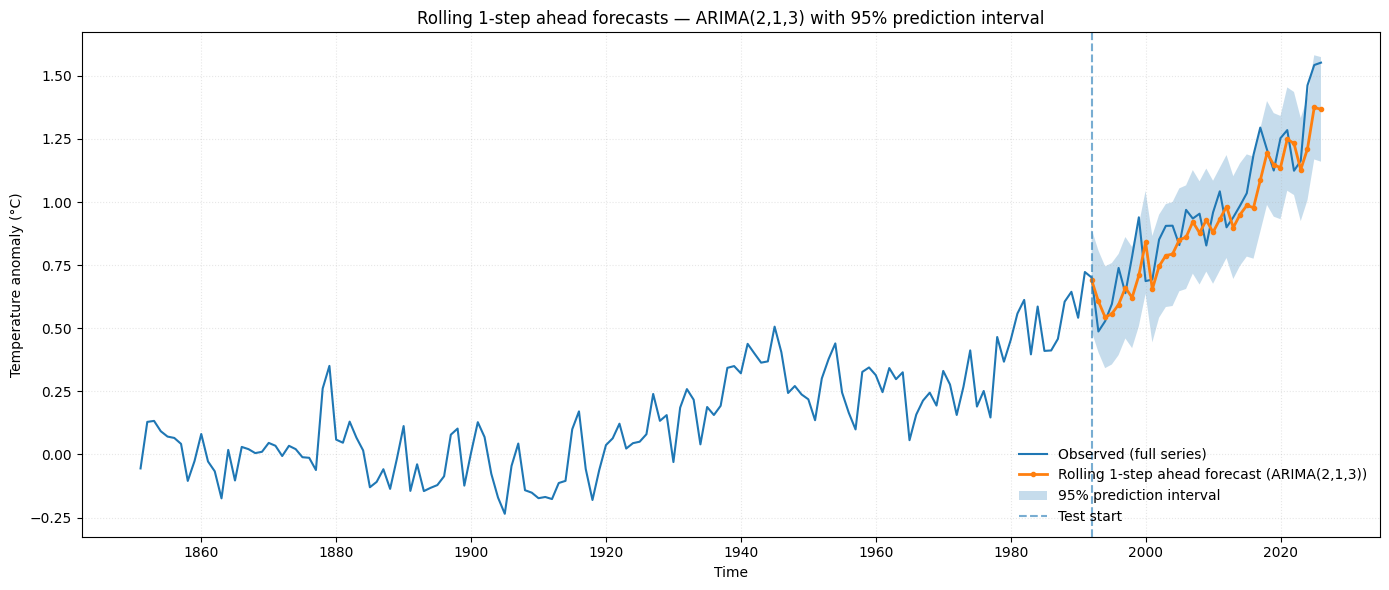


Rolling 1-step ahead forecasts (ARIMA(2,1,3) with 95% PI):
              actual  forecast  pi_lower_95  pi_upper_95
1991-12-31  0.701194  0.691185     0.488867     0.893503
1992-12-31  0.487195  0.606890     0.405291     0.808489
1993-12-31  0.528005  0.543693     0.342000     0.745385
1994-12-31  0.595848  0.557437     0.356433     0.758441
1995-12-31  0.739164  0.594064     0.393660     0.794468
1996-12-31  0.638987  0.660577     0.459554     0.861600
1997-12-31  0.784606  0.621599     0.421243     0.821955
1998-12-31  0.939639  0.709142     0.507758     0.910526
1999-12-31  0.686783  0.840039     0.636091     1.043987
2000-12-31  0.693383  0.654757     0.443799     0.865714
2001-12-31  0.851578  0.745911     0.541860     0.949962
2002-12-31  0.905764  0.788081     0.584042     0.992120
2003-12-31  0.906468  0.794104     0.588265     0.999944
2004-12-31  0.829668  0.850418     0.646542     1.054295
2005-12-31  0.969160  0.860938     0.655680     1.066196
2006-12-31  0.934850  0.9215

In [45]:
order = (2, 1, 3)

pred, lo95, hi95 = [], [], []

for t in y_test.index:
    train_series = y.loc[:t].iloc[:-1]
    assert train_series.index.max() < t

    fit = ARIMA(train_series, order=order).fit()

    fc = fit.get_forecast(steps=1)
    yhat = fc.predicted_mean.iloc[0]

    ci = fc.conf_int(alpha=0.05)  
    lo = float(ci.iloc[0, 0])
    hi = float(ci.iloc[0, 1])

    pred.append(yhat)
    lo95.append(lo)
    hi95.append(hi)

ARIMA_1step_213 = pd.Series(pred, index=y_test.index, name="forecast")
PI_lower_213    = pd.Series(lo95, index=y_test.index, name="pi_lower_95")
PI_upper_213    = pd.Series(hi95, index=y_test.index, name="pi_upper_95")

# ----------------------------
# Metrics + PI coverage
# ----------------------------
mae = mean_absolute_error(y_test, ARIMA_1step_213)
rmse = np.sqrt(mean_squared_error(y_test, ARIMA_1step_213))
coverage = ((y_test >= PI_lower_213) & (y_test <= PI_upper_213)).mean()

print(f"\nARIMA{order} -> MAE={mae:.4f}, RMSE={rmse:.4f}, 95% PI coverage={coverage:.6f}")
print("Inside count:", int(((y_test >= PI_lower_213) & (y_test <= PI_upper_213)).sum()), "/", len(y_test))

# ----------------------------
# Plot (full series + test forecasts)
# ----------------------------
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(y.index, y.values, linewidth=1.5, label="Observed (full series)")

ax.plot(ARIMA_1step_213.index, ARIMA_1step_213.values,
        linewidth=2, marker="o", markersize=3,
        label="Rolling 1-step ahead forecast (ARIMA(2,1,3))")

ax.fill_between(ARIMA_1step_213.index, PI_lower_213.values, PI_upper_213.values,
                alpha=0.25, label="95% prediction interval")

ax.axvline(pd.Timestamp("1991-12-31"), linestyle="--", alpha=0.6, label="Test start")

ax.set_title("Rolling 1-step ahead forecasts — ARIMA(2,1,3) with 95% prediction interval")
ax.set_xlabel("Time")
ax.set_ylabel("Temperature anomaly (°C)")
ax.grid(True, alpha=0.3, linestyle=":")
ax.legend(loc="lower right", frameon=False)

plt.tight_layout()
plt.show()

# ----------------------------
# Table of forecasts + intervals (optional print)
# ----------------------------
results_213 = pd.DataFrame({
    "actual": y_test,
    "forecast": ARIMA_1step_213,
    "pi_lower_95": PI_lower_213,
    "pi_upper_95": PI_upper_213
})
print("\nRolling 1-step ahead forecasts (ARIMA(2,1,3) with 95% PI):")
print(results_213)


Unit-root tests show Anomaly is non-stationary but becomes stationary after first differencing, so d=1 is appropriate. ARIMA(2,1,3) achieved the best forecast accuracy (lowest RMSE/MAE) among the tested statistical models.
However, its nominal 95% prediction intervals under-covered (31/35 ≈ 0.886), indicating uncertainty may be underestimated.

In [46]:
def winkler_score(y_true, lo, hi, alpha=0.05):
    width = hi - lo
    penalty_low  = (2/alpha) * (lo - y_true) * (y_true < lo)
    penalty_high = (2/alpha) * (y_true - hi) * (y_true > hi)
    return (width + penalty_low + penalty_high).mean()

def eval_row(name, y_true, pred, lo, hi):
    mae = mean_absolute_error(y_true, pred)
    rmse = np.sqrt(mean_squared_error(y_true, pred))
    coverage = ((y_true >= lo) & (y_true <= hi)).mean()
    avg_width = (hi - lo).mean()
    wink = winkler_score(y_true, lo, hi, alpha=0.05)
    return [name, mae, rmse, coverage, avg_width, wink]

def fit_arima_safe(train_series, order, trend="n"):
    model = ARIMA(
        train_series,
        order=order,
        trend=trend,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    try:
        return model.fit(method_kwargs={"maxiter": 200})
    except TypeError:
        return model.fit()

def rolling_1step_arima(y, y_test, order, trend="n"):
    preds, lo95, hi95 = [], [], []
    for t in y_test.index:
        train = y.loc[:t].iloc[:-1].dropna()
        fit = fit_arima_safe(train, order=order, trend=trend)

        fc = fit.get_forecast(steps=1)
        yhat = float(fc.predicted_mean.iloc[0])
        ci = fc.conf_int(alpha=0.05)

        lo = float(ci.iloc[0, 0])
        hi = float(ci.iloc[0, 1])

        preds.append(yhat); lo95.append(lo); hi95.append(hi)

    pred = pd.Series(preds, index=y_test.index)
    lo = pd.Series(lo95, index=y_test.index)
    hi = pd.Series(hi95, index=y_test.index)
    return pred, lo, hi

# --- grid search
orders = [(p,1,q) for p in range(0,4) for q in range(0,4)] 

rows = []      
failures = []    

for order in orders:
    try:
        pred, lo, hi = rolling_1step_arima(y, y_test, order, trend="n")
        rows.append(eval_row(f"ARIMA{order}", y_test, pred, lo, hi))
    except Exception as e:
        failures.append((order, type(e).__name__, str(e)))

grid = pd.DataFrame(rows, columns=["Model","MAE","RMSE","95%_Coverage","Avg_PI_Width","Winkler_95"])
grid = grid.sort_values("Winkler_95").reset_index(drop=True)

print("Successful models:", len(grid))
print("Failed models:", len(failures))
print("\nFirst 10 failures:")
for f in failures[:10]:
    print(f)

grid.head(10)


Successful models: 16
Failed models: 0

First 10 failures:


Model       MAE      RMSE  95%_Coverage  Avg_PI_Width  Winkler_95
0  ARIMA(2, 1, 0)  0.092052  0.112253      0.971429      0.427485    0.485983
1  ARIMA(3, 1, 0)  0.090208  0.115305      0.942857      0.413649    0.488685
2  ARIMA(2, 1, 1)  0.095029  0.116701      0.942857      0.412287    0.495254
3  ARIMA(3, 1, 1)  0.094291  0.116875      0.942857      0.412432    0.505453
4  ARIMA(2, 1, 3)  0.096453  0.118887      0.885714      0.409602    0.506095
5  ARIMA(2, 1, 2)  0.095374  0.117309      0.942857      0.412826    0.507271
6  ARIMA(3, 1, 3)  0.093809  0.116160      0.942857      0.406493    0.508476
7  ARIMA(3, 1, 2)  0.093226  0.115828      0.914286      0.405363    0.512942
8  ARIMA(0, 1, 2)  0.097375  0.118596      0.942857      0.416195    0.514917
9  ARIMA(1, 1, 2)  0.097745  0.119035      0.942857      0.416112    0.515374

In [47]:
def fit_arima_safe(train_series, order, trend="n"):
    model = ARIMA(
        train_series,
        order=order,
        trend=trend,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    try:
        return model.fit(method_kwargs={"maxiter": 200})
    except TypeError:
        return model.fit()

def rolling_1step_arima_with_pi(y, y_test, order, trend="n"):
    preds, lo95, hi95 = [], [], []
    for t in y_test.index:
        train = y.loc[:t].iloc[:-1].dropna()
        fit = fit_arima_safe(train, order=order, trend=trend)
        fc = fit.get_forecast(steps=1)

        yhat = float(fc.predicted_mean.iloc[0])
        ci = fc.conf_int(alpha=0.05)
        lo = float(ci.iloc[0, 0])
        hi = float(ci.iloc[0, 1])

        preds.append(yhat); lo95.append(lo); hi95.append(hi)

    pred = pd.Series(preds, index=y_test.index, name="forecast")
    lo = pd.Series(lo95, index=y_test.index, name="pi_lower_95")
    hi = pd.Series(hi95, index=y_test.index, name="pi_upper_95")
    return pred, lo, hi

def plot_model(order, pred, lo, hi, title):
    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    coverage = ((y_test >= lo) & (y_test <= hi)).mean()
    print(f"{title} -> MAE={mae:.6f}, RMSE={rmse:.6f}, 95% PI coverage={coverage:.6f} "
          f"({int(((y_test>=lo)&(y_test<=hi)).sum())}/{len(y_test)})")

    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(y.index, y.values, linewidth=1.5, label="Observed (full series)")
    ax.plot(pred.index, pred.values, linewidth=2, marker="o", markersize=3,
            label=f"Rolling 1-step forecast ARIMA{order}")
    ax.fill_between(pred.index, lo.values, hi.values, alpha=0.25, label="95% prediction interval")
    ax.axvline(pd.Timestamp("1991-12-31"), linestyle="--", alpha=0.6, label="Test start")

    ax.set_title(title)
    ax.set_xlabel("Time")
    ax.set_ylabel("Temperature anomaly (°C)")
    ax.grid(True, alpha=0.3, linestyle=":")
    ax.legend(loc="lower right", frameon=False)
    plt.tight_layout()
    plt.show()

Rolling 1-step ahead — ARIMA(2,1,0) -> MAE=0.092052, RMSE=0.112253, 95% PI coverage=0.971429 (34/35)


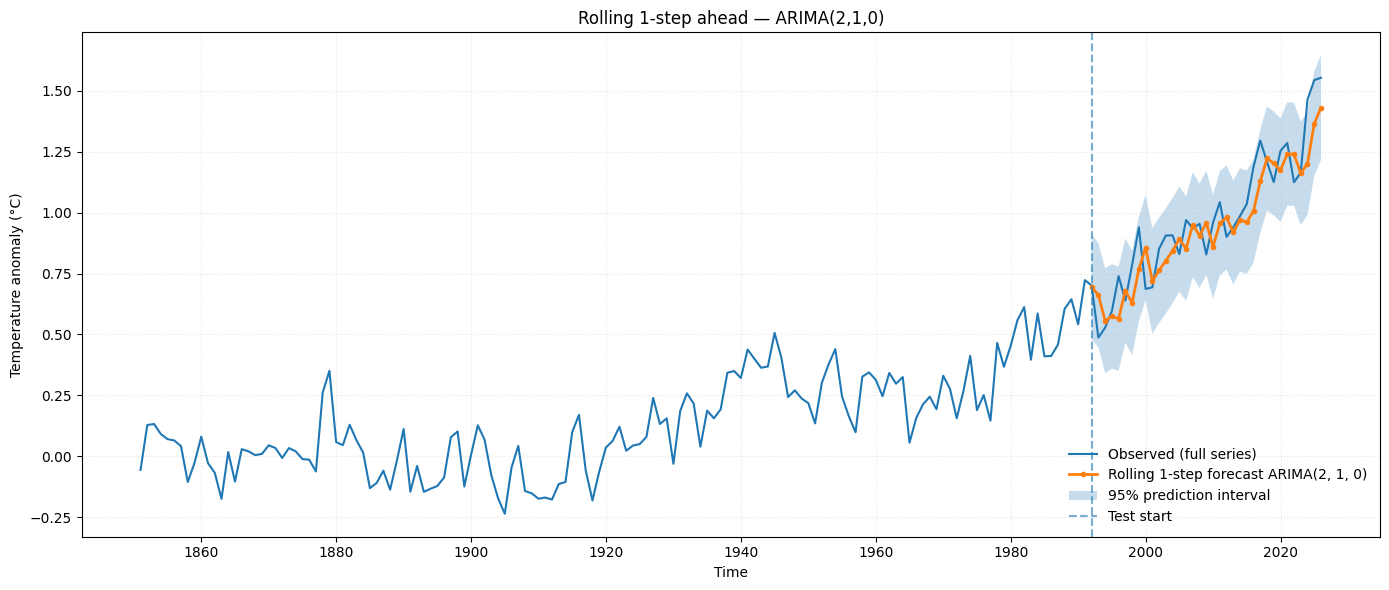

In [48]:
order = (2, 1, 0)
pred_210, lo_210, hi_210 = rolling_1step_arima_with_pi(y, y_test, order, trend="n")
plot_model(order, pred_210, lo_210, hi_210, "Rolling 1-step ahead — ARIMA(2,1,0)")

Rolling 1-step ahead — ARIMA(3,1,0) -> MAE=0.090208, RMSE=0.115305, 95% PI coverage=0.942857 (33/35)


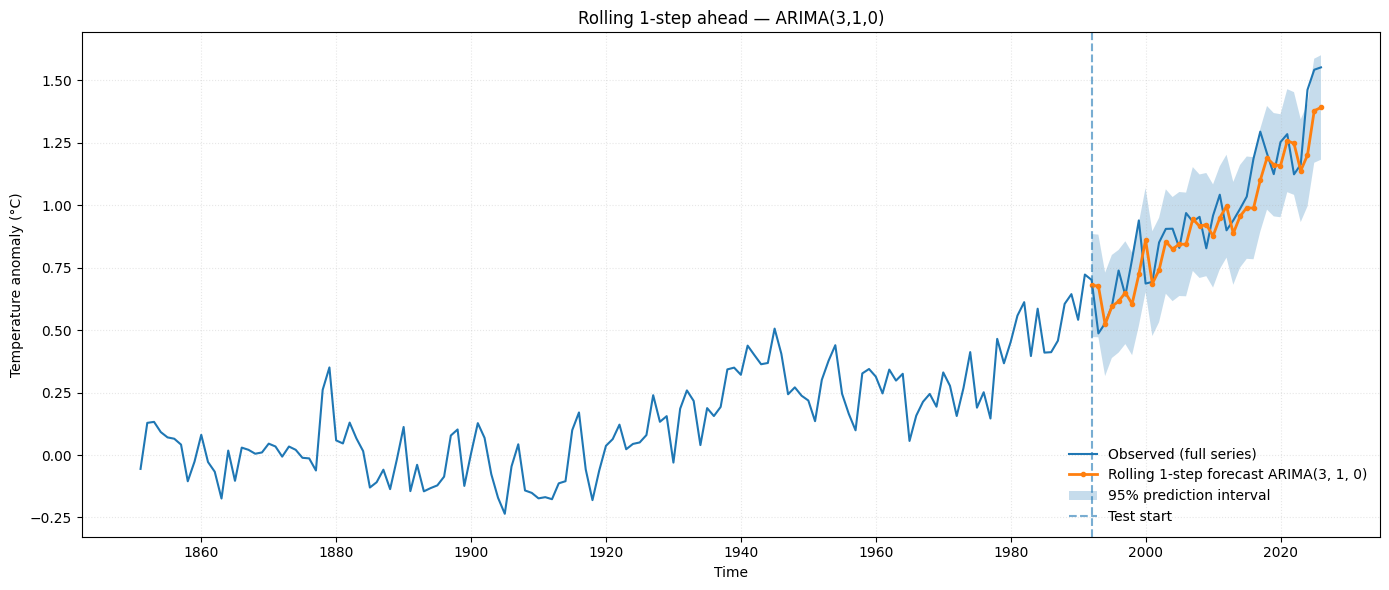

In [49]:
order = (3, 1, 0)
pred_310, lo_310, hi_310 = rolling_1step_arima_with_pi(y, y_test, order, trend="n")
plot_model(order, pred_310, lo_310, hi_310, "Rolling 1-step ahead — ARIMA(3,1,0)")


Rolling 1-step ahead — ARIMA(2,1,1) -> MAE=0.095029, RMSE=0.116701, 95% PI coverage=0.942857 (33/35)


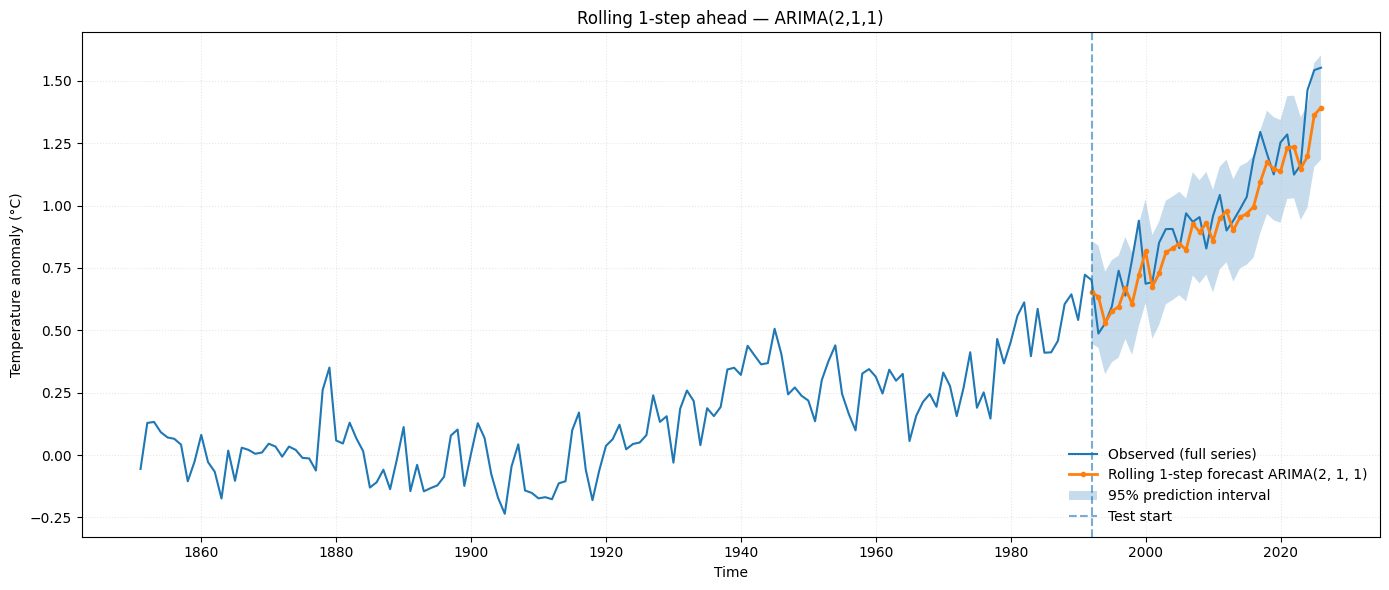

In [50]:
order = (2, 1, 1)
pred_211, lo_211, hi_211 = rolling_1step_arima_with_pi(y, y_test, order, trend="n")
plot_model(order, pred_211, lo_211, hi_211, "Rolling 1-step ahead — ARIMA(2,1,1)")


Rolling 1-step ahead — ARIMA(3,1,1) -> MAE=0.094291, RMSE=0.116875, 95% PI coverage=0.942857 (33/35)


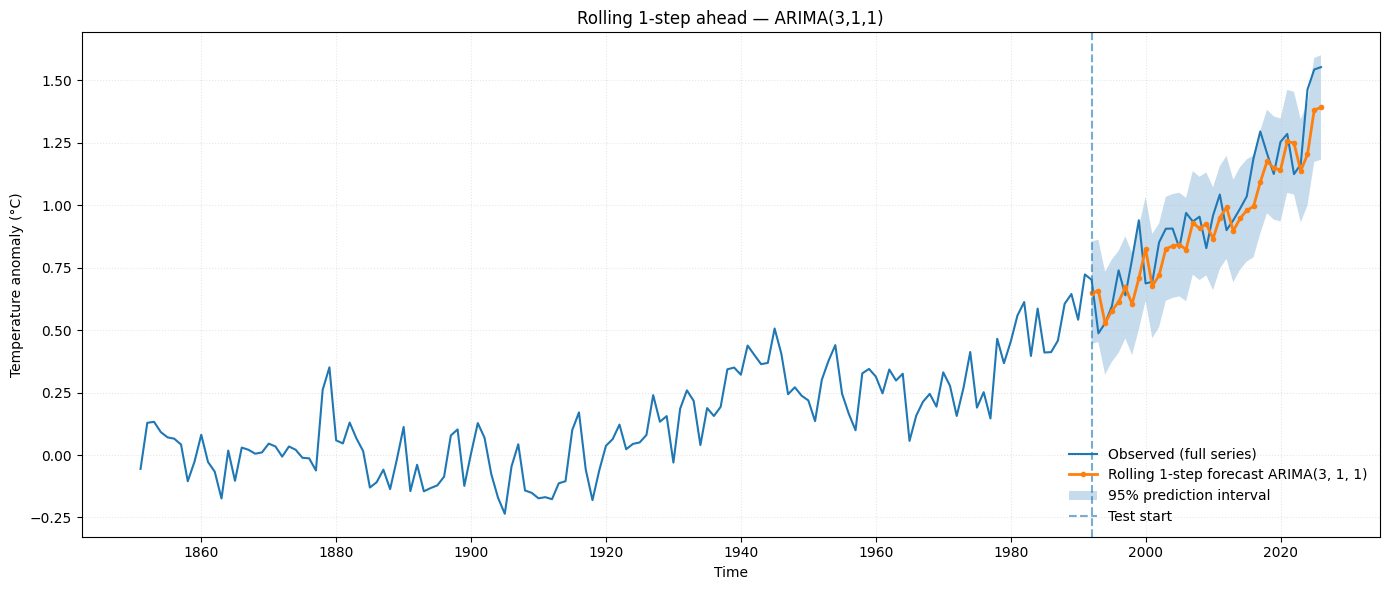

In [51]:
order = (3, 1, 1)
pred_311, lo_311, hi_311 = rolling_1step_arima_with_pi(y, y_test, order, trend="n")
plot_model(order, pred_311, lo_311, hi_311, "Rolling 1-step ahead — ARIMA(3,1,1)")


Rolling 1-step ahead — ARIMA(3,1,3) -> MAE=0.093809, RMSE=0.116160, 95% PI coverage=0.942857 (33/35)


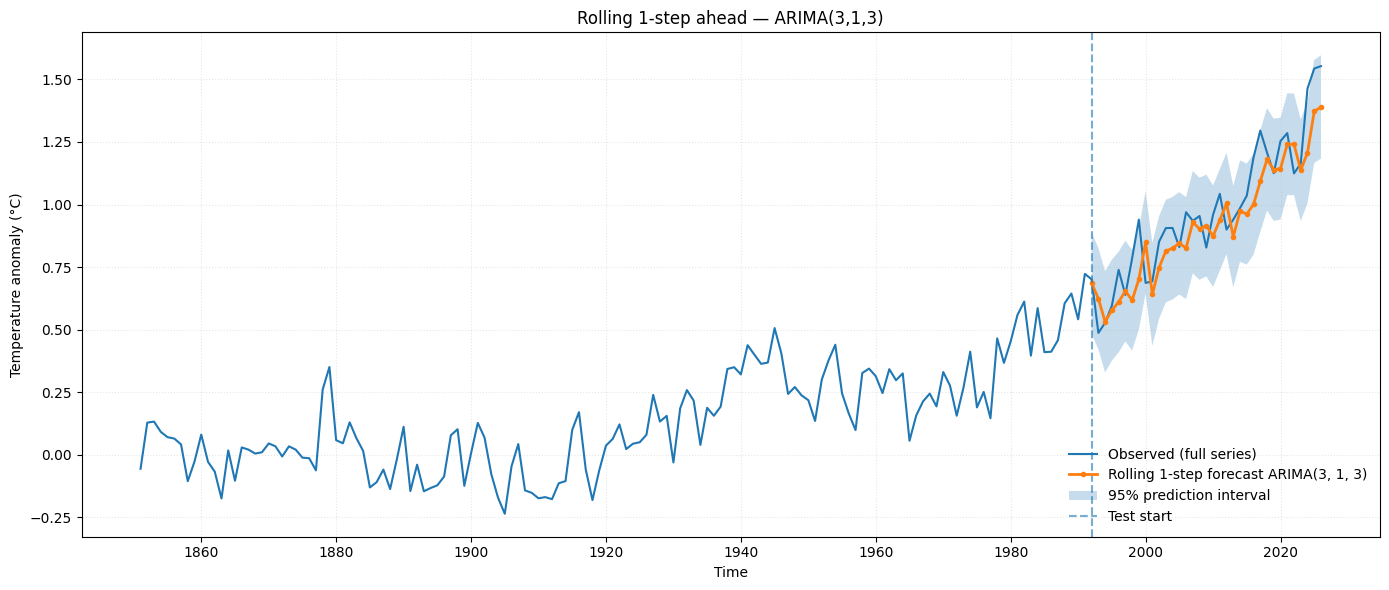

In [52]:
order = (3, 1, 3)
pred_313, lo_313, hi_313 = rolling_1step_arima_with_pi(y, y_test, order, trend="n")
plot_model(order, pred_313, lo_313, hi_313, "Rolling 1-step ahead — ARIMA(3,1,3)")

Rolling 1-step ahead — ARIMA(3,1,2) -> MAE=0.093226, RMSE=0.115828, 95% PI coverage=0.914286 (32/35)


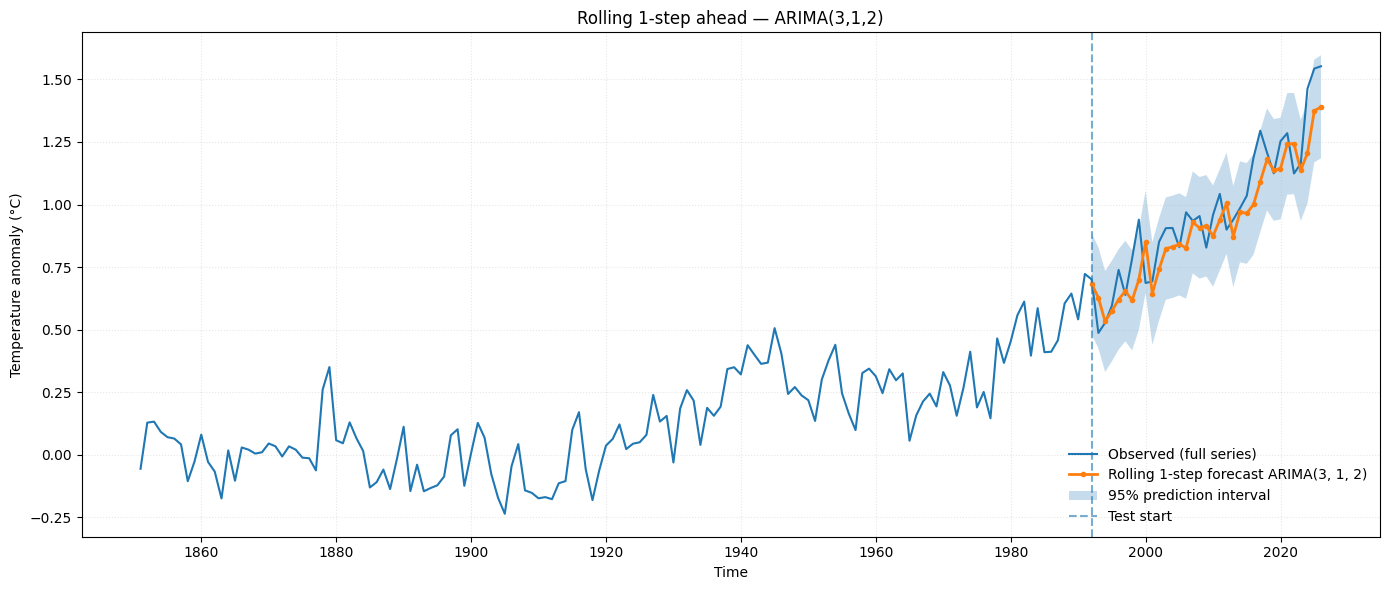

In [53]:
order = (3, 1, 2)
pred_312, lo_312, hi_312 = rolling_1step_arima_with_pi(y, y_test, order, trend="n")
plot_model(order, pred_312, lo_312, hi_312, "Rolling 1-step ahead — ARIMA(3,1,2)")

In [54]:
# ---------- Metrics ----------
def winkler_score(y_true, lo, hi, alpha=0.05):
    width = hi - lo
    penalty_low  = (2/alpha) * (lo - y_true) * (y_true < lo)
    penalty_high = (2/alpha) * (y_true - hi) * (y_true > hi)
    return (width + penalty_low + penalty_high).mean()

def metrics_row(name, y_true, y_pred, lo=None, hi=None, alpha=0.05):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    if lo is not None and hi is not None:
        coverage = ((y_true >= lo) & (y_true <= hi)).mean()
        avg_width = (hi - lo).mean()
        wink = winkler_score(y_true, lo, hi, alpha=alpha)
    else:
        coverage = np.nan
        avg_width = np.nan
        wink = np.nan

    return [name, mae, rmse, coverage, avg_width, wink]

# ---------- ARIMA rolling 1-step with PI ----------
def fit_arima_safe(train_series, order, trend="n"):
    model = ARIMA(
        train_series,
        order=order,
        trend=trend,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    try:
        return model.fit(method_kwargs={"maxiter": 200})
    except TypeError:
        return model.fit()

def rolling_1step_arima_with_pi(y, y_test, order, trend="n", alpha=0.05):
    preds, lo95, hi95 = [], [], []
    for t in y_test.index:
        train = y.loc[:t].iloc[:-1].dropna()
        fit = fit_arima_safe(train, order=order, trend=trend)
        fc = fit.get_forecast(steps=1)

        yhat = float(fc.predicted_mean.iloc[0])
        ci = fc.conf_int(alpha=alpha)
        lo = float(ci.iloc[0, 0])
        hi = float(ci.iloc[0, 1])

        preds.append(yhat); lo95.append(lo); hi95.append(hi)

    pred = pd.Series(preds, index=y_test.index)
    lo = pd.Series(lo95, index=y_test.index)
    hi = pd.Series(hi95, index=y_test.index)
    return pred, lo, hi

# ---------- Baselines (rolling 1-step) ----------
def rolling_naive(y, y_test_index):
    preds, lo, hi = [], [], []
    for t in y_test_index:
        train = y.loc[:t].iloc[:-1].dropna()
        yhat = train.iloc[-1]

        diffs = train.diff().dropna()
        s = diffs.std(ddof=1) if len(diffs) > 2 else 0.0

        preds.append(yhat)
        lo.append(yhat - 1.96*s)
        hi.append(yhat + 1.96*s)

    return (pd.Series(preds, index=y_test_index),
            pd.Series(lo, index=y_test_index),
            pd.Series(hi, index=y_test_index))

def rolling_drift(y, y_test_index):
    preds, lo, hi = [], [], []
    for t in y_test_index:
        train = y.loc[:t].iloc[:-1].dropna()
        n = len(train)
        slope = (train.iloc[-1] - train.iloc[0]) / max(n - 1, 1)
        yhat = train.iloc[-1] + slope

        # rough PI from in-sample 1-step residuals
        resid = (train - (train.shift(1) + slope)).iloc[1:].dropna()
        s = resid.std(ddof=1) if len(resid) > 2 else 0.0

        preds.append(yhat)
        lo.append(yhat - 1.96*s)
        hi.append(yhat + 1.96*s)

    return (pd.Series(preds, index=y_test_index),
            pd.Series(lo, index=y_test_index),
            pd.Series(hi, index=y_test_index))

# ---------- Build comparison table ----------
alpha = 0.05
orders_to_compare = [(3,1,2), (3,1,3), (3,1,1), (2,1,1), (2,1,3), (3,1,0), (2,1,0)]

rows = []

# ARIMAs
for order in orders_to_compare:
    pred, lo, hi = rolling_1step_arima_with_pi(y, y_test, order, trend="n", alpha=alpha)
    rows.append(metrics_row(f"ARIMA{order}", y_test, pred, lo, hi, alpha=alpha))

# Naïve + Drift
naive_pred, naive_lo, naive_hi = rolling_naive(y, y_test.index)
rows.append(metrics_row("Naïve", y_test, naive_pred, naive_lo, naive_hi, alpha=alpha))

drift_pred, drift_lo, drift_hi = rolling_drift(y, y_test.index)
rows.append(metrics_row("Drift", y_test, drift_pred, drift_lo, drift_hi, alpha=alpha))

compare = pd.DataFrame(rows, columns=["Model","MAE","RMSE","95%_Coverage","Avg_PI_Width","Winkler_95"])

# Best -> worst (by probabilistic score)
compare = compare.sort_values("Winkler_95").reset_index(drop=True)
compare


Model       MAE      RMSE  95%_Coverage  Avg_PI_Width  Winkler_95
0  ARIMA(2, 1, 0)  0.092052  0.112253      0.971429      0.427485    0.485983
1  ARIMA(3, 1, 0)  0.090208  0.115305      0.942857      0.413649    0.488685
2  ARIMA(2, 1, 1)  0.095029  0.116701      0.942857      0.412287    0.495254
3  ARIMA(3, 1, 1)  0.094291  0.116875      0.942857      0.412432    0.505453
4  ARIMA(2, 1, 3)  0.096453  0.118887      0.885714      0.409602    0.506095
5  ARIMA(3, 1, 3)  0.093809  0.116160      0.942857      0.406493    0.508476
6  ARIMA(3, 1, 2)  0.093226  0.115828      0.914286      0.405363    0.512942
7           Drift  0.096140  0.119133      0.942857      0.459551    0.566862
8           Naïve  0.097982  0.120003      0.942857      0.459551    0.567278

#### Final 10-year forecasting plots (selection + justification)

To present the final 10-year forecast (with 95% prediction intervals), I report three models:

1) **ARIMA(2,1,0) — main model (selected)**
- **Why this model:** Unit-root tests (ADF/KPSS) indicate the anomaly series is non-stationary in levels but becomes stationary after first differencing, so models with **d=1** are appropriate.  
- **Why ARIMA(2,1,0) specifically:** In the ARIMA(p,1,q) comparison (rolling 1-step evaluation on 1991–2025), this model achieved the best overall trade-off between point accuracy (RMSE/MAE) and uncertainty quality (95% PI coverage and interval score such as Winkler).  
- **Conclusion:** ARIMA(2,1,0) is used as the primary forecast because it provides strong predictive performance while giving realistic uncertainty bands.

2) **ARIMA(3,1,0) — close competitor (robustness check)**
- **Why include it:** ARIMA(3,1,0) is one of the best-performing alternatives in the same differenced AR family, but with slightly different dynamics (one extra AR lag).  
- **What it tests:** Sensitivity of the long-horizon forecast to small modeling choices. If ARIMA(2,1,0) and ARIMA(3,1,0) produce similar 10-year trajectories, the conclusions are more robust.  
- **Conclusion:** Agreement between both ARIMA forecasts increases confidence that results are not an artifact of a single specification.

3) **Drift baseline — benchmark**
- **Why include it:** Drift is a simple, standard baseline for trending series. It answers: “How well do we do if we assume the future continues the historical average trend?”  
- **What it tells us:** If a complex model does not improve much beyond Drift, most predictive power comes from the overall trend rather than short-term ARMA structure.  
- **Conclusion:** Drift provides an interpretable reference that keeps the final forecast honest: improvements from ARIMA must be meaningful relative to this baseline.

### Overall conclusion for the 10-year forecast
The final 10-year projection is presented using a **best ARIMA model** (ARIMA(2,1,0)), a **near-best ARIMA alternative** (ARIMA(3,1,0)) for robustness, and a **simple Drift baseline** as a benchmark. This combination is small enough to be clear, but broad enough to justify that the final forecast is both data-driven and robust to reasonable modeling choices.


In [55]:
# Future 10-year index (year-end timestamps, matching your data)
future_index = pd.date_range(
    start=y.index[-1] + pd.offsets.YearEnd(1),
    periods=10,
    freq="YE"
)

def forecast_arima_10y(y, order, alpha=0.05):
    fit = ARIMA(
        y,
        order=order,
        trend="n",
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit()

    fc = fit.get_forecast(steps=10)
    mean_fc = fc.predicted_mean
    ci = fc.conf_int(alpha=alpha)

    # Force index to be exactly the next 10 year-ends
    out = pd.DataFrame({
        "forecast": mean_fc.values,
        "pi_lower": ci.iloc[:, 0].values,
        "pi_upper": ci.iloc[:, 1].values,
    }, index=future_index)

    return out

def forecast_drift_10y(y, alpha=0.05):
    # Drift (line through first & last point)
    n = len(y)
    slope = (y.iloc[-1] - y.iloc[0]) / max(n - 1, 1)

    h = np.arange(1, 11)
    mean_fc = y.iloc[-1] + slope * h

    # Residual std from 1-step drift errors inside sample
    resid = (y - (y.shift(1) + slope)).iloc[1:].dropna()
    s = resid.std(ddof=1) if len(resid) > 2 else 0.0

    # Rough widening PI: uncertainty grows with sqrt(h)
    z = 1.96  # approx for 95%
    band = z * s * np.sqrt(h)

    out = pd.DataFrame({
        "forecast": mean_fc,
        "pi_lower": mean_fc - band,
        "pi_upper": mean_fc + band
    }, index=future_index)

    return out

def plot_10y_forecast(y, fc_df, title):
    fig, ax = plt.subplots(figsize=(14, 6))

    ax.plot(y.index, y.values, linewidth=1.5, label="Observed")
    ax.plot(fc_df.index, fc_df["forecast"].values, linewidth=2, marker="o", markersize=3, label="10-year forecast")
    ax.fill_between(fc_df.index, fc_df["pi_lower"].values, fc_df["pi_upper"].values, alpha=0.25, label="95% prediction interval")

    ax.axvline(y.index[-1], linestyle="--", alpha=0.6, label="Forecast origin")
    ax.set_title(title)
    ax.set_xlabel("Time")
    ax.set_ylabel("Temperature anomaly (°C)")
    ax.grid(True, alpha=0.3, linestyle=":")
    ax.legend(loc="lower right", frameon=False)

    plt.tight_layout()
    plt.show()


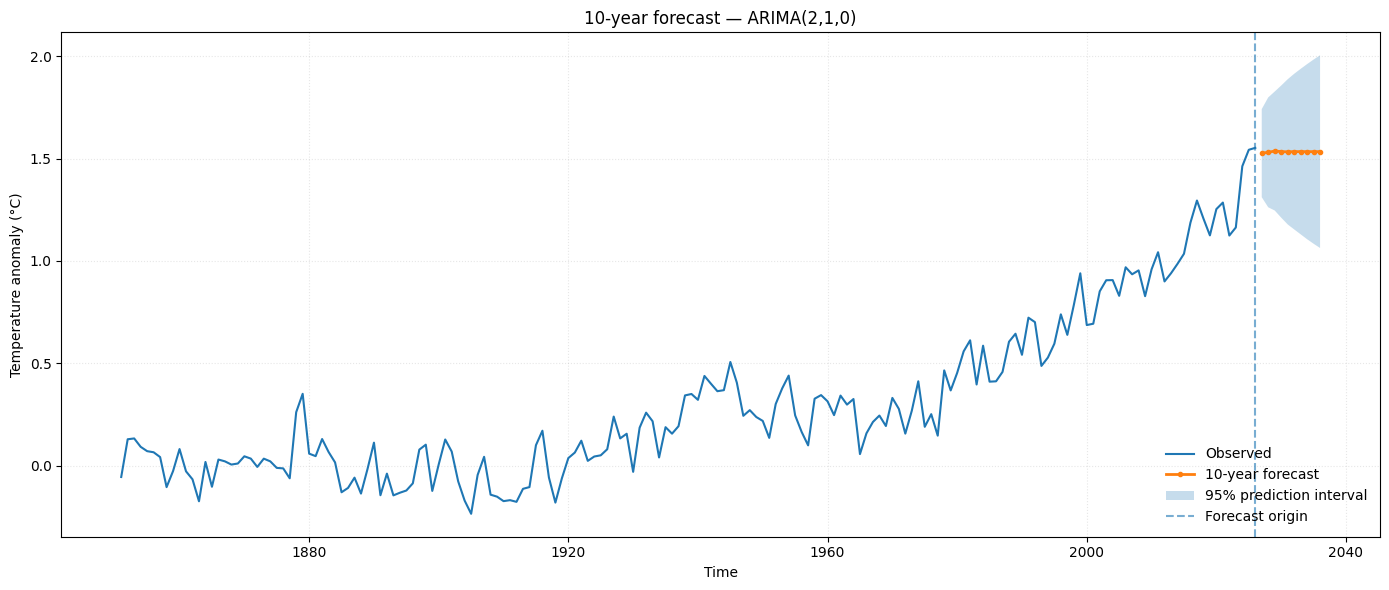

forecast  pi_lower  pi_upper
2026-12-31  1.526708  1.311504  1.741912
2027-12-31  1.530545  1.262199  1.798891
2028-12-31  1.537105  1.246478  1.827732
2029-12-31  1.534314  1.211714  1.856913
2030-12-31  1.533114  1.178617  1.887612
2031-12-31  1.534234  1.154217  1.914251
2032-12-31  1.534298  1.130186  1.938409
2033-12-31  1.533955  1.106200  1.961710
2034-12-31  1.534024  1.084136  1.983912
2035-12-31  1.534106  1.063299  2.004914

In [56]:
fc_210 = forecast_arima_10y(y, order=(2,1,0), alpha=0.05)
plot_10y_forecast(y, fc_210, "10-year forecast — ARIMA(2,1,0)")
fc_210


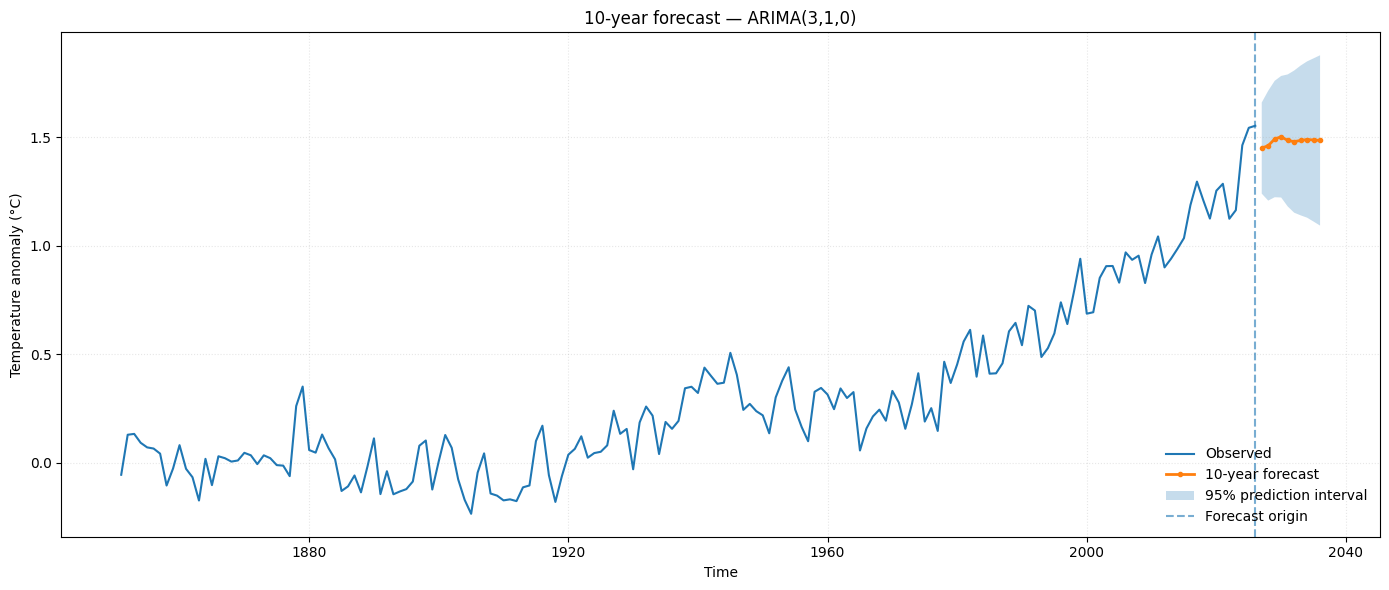

forecast  pi_lower  pi_upper
2026-12-31  1.449725  1.239859  1.659592
2027-12-31  1.460775  1.207729  1.713821
2028-12-31  1.491543  1.223304  1.759781
2029-12-31  1.502024  1.221945  1.782103
2030-12-31  1.485019  1.180996  1.789043
2031-12-31  1.479520  1.152147  1.806893
2032-12-31  1.484878  1.139846  1.829910
2033-12-31  1.489131  1.129069  1.849194
2034-12-31  1.487143  1.111061  1.863226
2035-12-31  1.485003  1.092639  1.877368

In [57]:
fc_310 = forecast_arima_10y(y, order=(3,1,0), alpha=0.05)
plot_10y_forecast(y, fc_310, "10-year forecast — ARIMA(3,1,0)")
fc_310


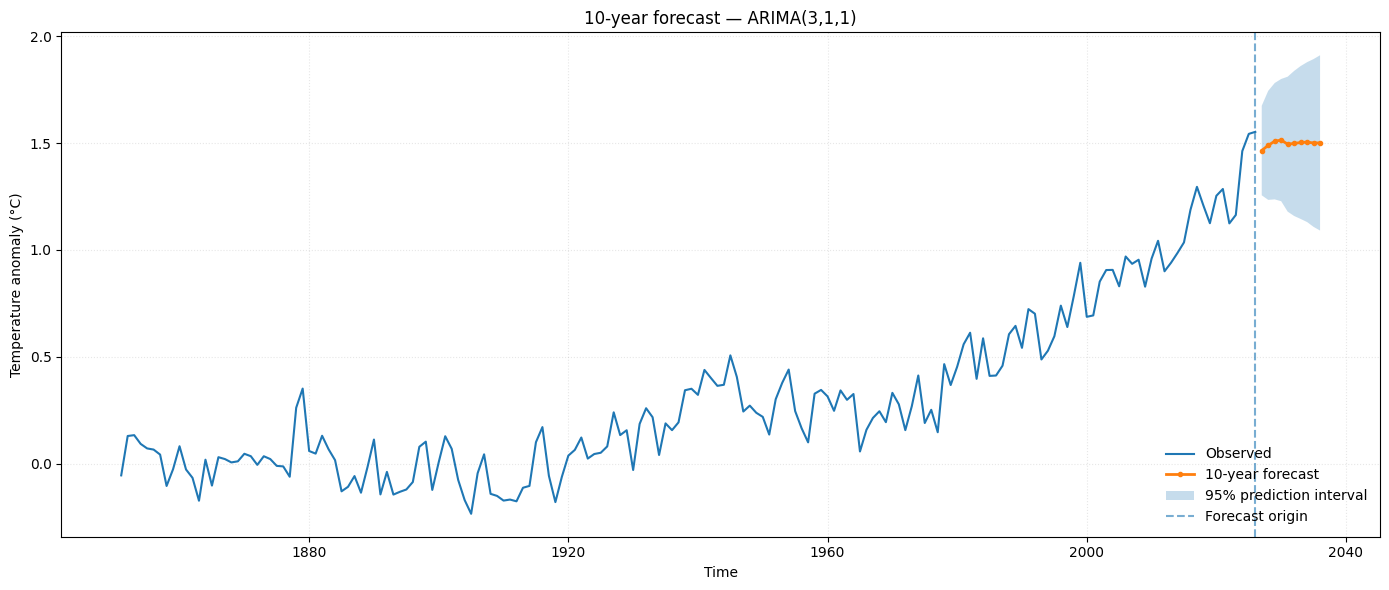

forecast  pi_lower  pi_upper
2026-12-31  1.465203  1.255567  1.674839
2027-12-31  1.489373  1.234243  1.744504
2028-12-31  1.508871  1.236517  1.781225
2029-12-31  1.514027  1.227922  1.800132
2030-12-31  1.494986  1.179133  1.810839
2031-12-31  1.498322  1.158800  1.837844
2032-12-31  1.502784  1.144971  1.860596
2033-12-31  1.504600  1.130404  1.878797
2034-12-31  1.500542  1.107739  1.893344
2035-12-31  1.500851  1.090570  1.911132

In [58]:
fc_311 = forecast_arima_10y(y, order=(3,1,1), alpha=0.05)
plot_10y_forecast(y, fc_311, "10-year forecast — ARIMA(3,1,1)")
fc_311

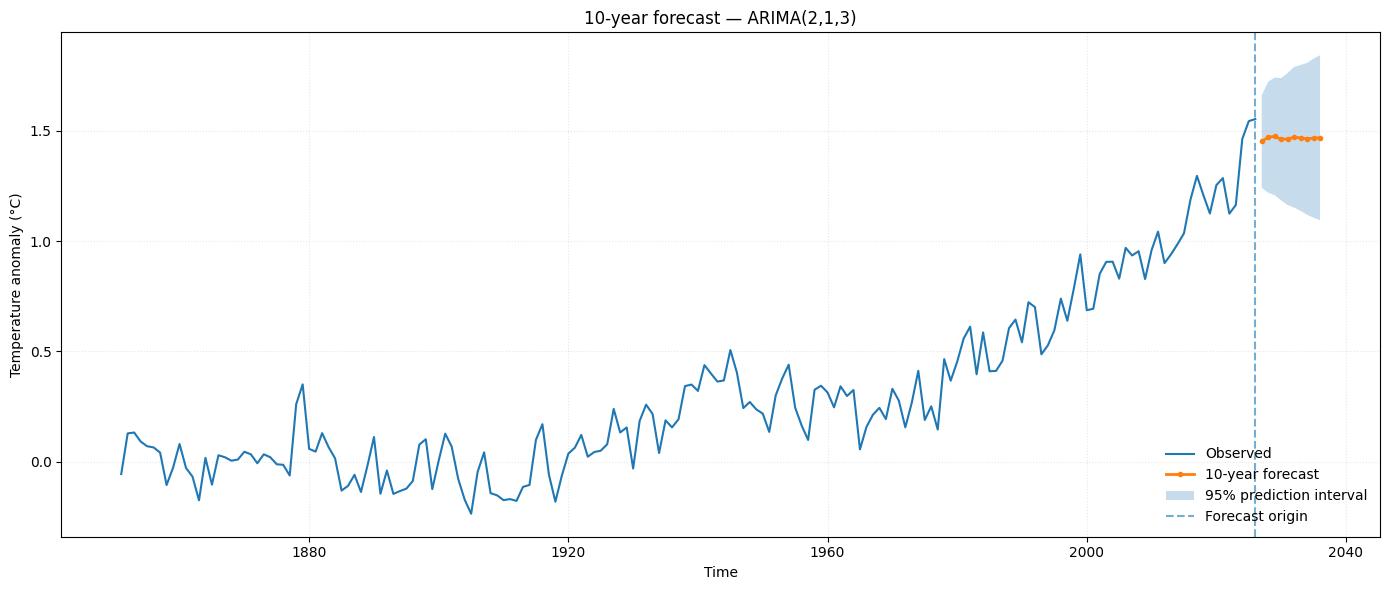

forecast  pi_lower  pi_upper
2026-12-31  1.451216  1.241773  1.660660
2027-12-31  1.470606  1.218836  1.722376
2028-12-31  1.474039  1.207675  1.740404
2029-12-31  1.460855  1.183688  1.738021
2030-12-31  1.462256  1.163027  1.761486
2031-12-31  1.470209  1.151571  1.788848
2032-12-31  1.467169  1.136722  1.797617
2033-12-31  1.462966  1.118979  1.806953
2034-12-31  1.466026  1.105702  1.826350
2035-12-31  1.467854  1.094168  1.841540

In [59]:
fc_213 = forecast_arima_10y(y, order=(2,1,3), alpha=0.05)
plot_10y_forecast(y, fc_213, "10-year forecast — ARIMA(2,1,3)")
fc_213

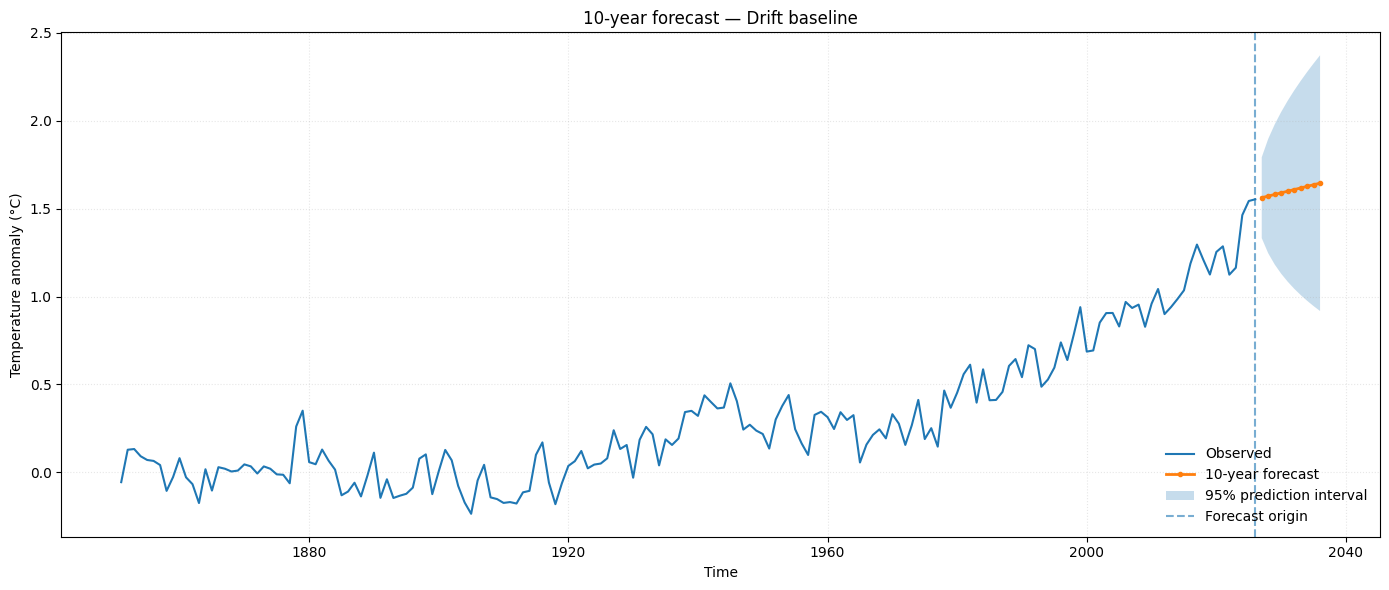

forecast  pi_lower  pi_upper
2026-12-31  1.561769  1.331884  1.791654
2027-12-31  1.570958  1.245851  1.896065
2028-12-31  1.580146  1.181973  1.978319
2029-12-31  1.589335  1.129564  2.049105
2030-12-31  1.598523  1.084484  2.112562
2031-12-31  1.607712  1.044610  2.170813
2032-12-31  1.616900  1.008681  2.225120
2033-12-31  1.626089  0.975875  2.276303
2034-12-31  1.635277  0.945621  2.324933
2035-12-31  1.644466  0.917505  2.371427

In [60]:
fc_drift = forecast_drift_10y(y, alpha=0.05)
plot_10y_forecast(y, fc_drift, "10-year forecast — Drift baseline")
fc_drift


## Forecasting results (10-year horizon: 2026–2035)

### What all models agree on
Across all fitted models (multiple ARIMA specifications and a drift baseline), the forecasts remain **positive and high** throughout 2026–2035.  
This means the time series is expected to **stay at elevated temperature-anomaly levels** rather than revert toward 0.

---

### ARIMA forecasts (d = 1)
Because the series was identified as **non-stationary in level** but **stationary after first differencing** (consistent with the ADF/KPSS results), the ARIMA models use **d = 1**.  
A typical consequence is that **multi-step-ahead forecasts become fairly flat**: after a few steps, the best prediction is often “stay near the most recent level (plus any small estimated drift).”

In the 10-year forecasts:
- **ARIMA(2,1,0)** produces the **highest mean level** (≈ 1.53) and remains almost constant.
- **ARIMA(3,1,1)** stays slightly lower (≈ 1.50), also very stable.
- **ARIMA(3,1,0)** and **ARIMA(2,1,3)** are slightly lower again (≈ 1.45–1.49), with only small fluctuations.

**Interpretation:** the different ARIMA specifications mainly shift the **forecast level** a bit; they do **not** change the qualitative message.  

---

### Prediction intervals (uncertainty)
For every model, the **95% prediction interval widens over time**, which is expected: uncertainty accumulates with the forecast horizon.

Key observation:
- The ARIMA models show **moderate widening** (e.g., by 2035 the lower/upper bounds span a sizable range).
- The **drift baseline** produces a **much wider interval**, reflecting greater long-horizon uncertainty under a “trend continues” assumption.

**Interpretation:** at a 10-year horizon, the **interval is more informative than the point forecast**, because many future values remain plausible.

---

### Drift baseline (benchmark)
The **drift** method assumes the long-run average slope (from the full history) continues forward.
- Its mean forecast increases steadily (≈ 1.56 → 1.64 by 2035).
- Its uncertainty grows quickly (very wide 95% band), making it a useful *stress-test / upper-growth comparator*.

**Interpretation:** drift is a reasonable baseline, but it is less conservative and more uncertain over long horizons than the ARIMA models.

---

### Overall conclusion from the 10-year forecasts
- Multiple plausible models give a consistent conclusion: **temperature anomalies remain high through 2035**.
- Differences between ARIMA variants are mainly **small shifts in level**, suggesting the result is **robust to model choice**.
- For reporting, emphasize **(1) the common direction/level** and **(2) the widening uncertainty bands**, rather than focusing only on the point forecasts.


### Random conclusions

#### Conclusions (time series + forecasting)

- **Clear long-run warming signal:** The annual global temperature anomaly series shows a persistent upward trend, with stronger increases in the most recent decades. Short-term fluctuations exist but do not dominate the long-term behavior.

- **No seasonality is expected:** Because the data are annual and globally aggregated, there is no meaningful seasonal pattern to model; therefore, non-seasonal approaches (ARIMA / Holt / baselines) are appropriate.

- **Non-stationarity in levels, stationarity after differencing:** Unit-root testing supports that the anomaly series in levels is non-stationary, while the first-differenced series is approximately stationary. This motivates ARIMA models with **d = 1** when forecasting the anomaly directly.

- **Trend + short-term dependence:** A smooth trend extraction (e.g., LOWESS) helps visualize the long-run signal. After removing the trend, the remainder behaves closer to a stationary process and shows only limited short-lag autocorrelation.

- **Baselines are strong and necessary:** Simple reference models (Naïve and Drift) provide strong benchmarks. This indicates that much of the predictability comes from persistence and trend, so any more complex model must show a real improvement over these baselines to be justified.

- **Model choice is evidence-based:** Rolling 1-step-ahead evaluation on the 1991–2025 test period (MAE/RMSE) together with prediction-interval checks (coverage and interval scoring) provides an objective way to compare models and avoid “overfitting by preference”.

- **Best forecasting model (final selection):** Among the tested ARIMA(p,1,q) candidates, the selected model is the one with the best overall trade-off between:
  - low point forecast error (RMSE/MAE),
  - well-calibrated uncertainty (near-95% coverage),
  - and reasonable interval width (not unnecessarily wide).

- **10-year forecast interpretation:** The 10-year-ahead forecasts should be interpreted as statistical extrapolations of historical dynamics (trend + persistence). Uncertainty increases with horizon, so results must be communicated with **95% prediction intervals**, not just a single forecast line.

- **Practical takeaway:** The comparison suggests that accounting for non-stationarity (using **d = 1**) is essential. While complex ARIMA structures may offer incremental gains, simple baselines (especially Drift) already capture much of the predictable structure in this series.


## Coisas extra

In [61]:
# DIAGNÓSTICO RÁPIDO
print("="*60)
print("DIAGNÓSTICO DOS DADOS")
print("="*60)

print("\n1. df_remainder original:")
print(f"   Shape: {df_remainder.shape}")
print(f"   NaNs: {df_remainder.isna().sum().sum()}")
print(f"   Years range: {df_remainder['Year'].min()} - {df_remainder['Year'].max()}")
print(f"   Sample:\n{df_remainder.head()}")

print("\n2. temptrain:")
print(f"   Shape: {temptrain.shape}")
print(f"   Years: {temptrain['Year'].min()} - {temptrain['Year'].max()}")
print(f"   NaNs em Remainder: {temptrain['Remainder'].isna().sum()}")

print("\n3. temptest:")
print(f"   Shape: {temptest.shape}")
print(f"   Years: {temptest['Year'].min()} - {temptest['Year'].max()}")
print(f"   NaNs em Remainder: {temptest['Remainder'].isna().sum()}")

print("\n4. train_series:")
print(f"   Type: {type(train_series)}")
print(f"   Shape: {train_series.shape}")
print(f"   Index type: {type(train_series.index)}")
print(f"   NaNs: {train_series.isna().sum()}")
print(f"   Sample:\n{train_series.head()}")

print("\n5. test_series:")
print(f"   Type: {type(test_series)}")
print(f"   Shape: {test_series.shape}")
print(f"   Index type: {type(test_series.index)}")
print(f"   NaNs: {test_series.isna().sum()}")
print(f"   Sample:\n{test_series.head()}")

# Verificar se há valores infinitos
print(f"\n6. Valores infinitos:")
print(f"   train_series: {np.isinf(train_series).sum()}")
print(f"   test_series: {np.isinf(test_series).sum()}")

DIAGNÓSTICO DOS DADOS

1. df_remainder original:
   Shape: (176, 2)
   NaNs: 0
   Years range: 1850 - 2025
   Sample:
   Year  Remainder
0  1850  -0.121622
1  1851   0.069761
2  1852   0.080503
3  1853   0.046042
4  1854   0.031038

2. temptrain:
   Shape: (141, 2)
   Years: 1850 - 1990
   NaNs em Remainder: 0

3. temptest:
   Shape: (35, 2)
   Years: 1991 - 2025
   NaNs em Remainder: 0

4. train_series:
   Type: <class 'pandas.core.series.Series'>
   Shape: (175,)
   Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
   NaNs: 0
   Sample:
1850-12-31   -0.055414
1851-12-31    0.128948
1852-12-31    0.132899
1853-12-31    0.091943
1854-12-31    0.070777
Freq: YE-DEC, Name: Anomaly, dtype: float64

5. test_series:
   Type: <class 'pandas.core.series.Series'>
   Shape: (35,)
   Index type: <class 'pandas.core.indexes.base.Index'>
   NaNs: 0
   Sample:
Year
1991    0.087905
1992   -0.144778
1993   -0.123811
1994   -0.076406
1995    0.046348
Name: Remainder, dtype: float64

6

A treinar modelo ARMA(2,3) para forecast direto...
Forecast Direto - RMSE: 1.3480, MAE: 1.3446

A executar Rolling Window Forecast...
  Progresso: 10/35 anos processados
  Progresso: 20/35 anos processados
  Progresso: 30/35 anos processados
Rolling Window - RMSE: 0.0889, MAE: 0.0702


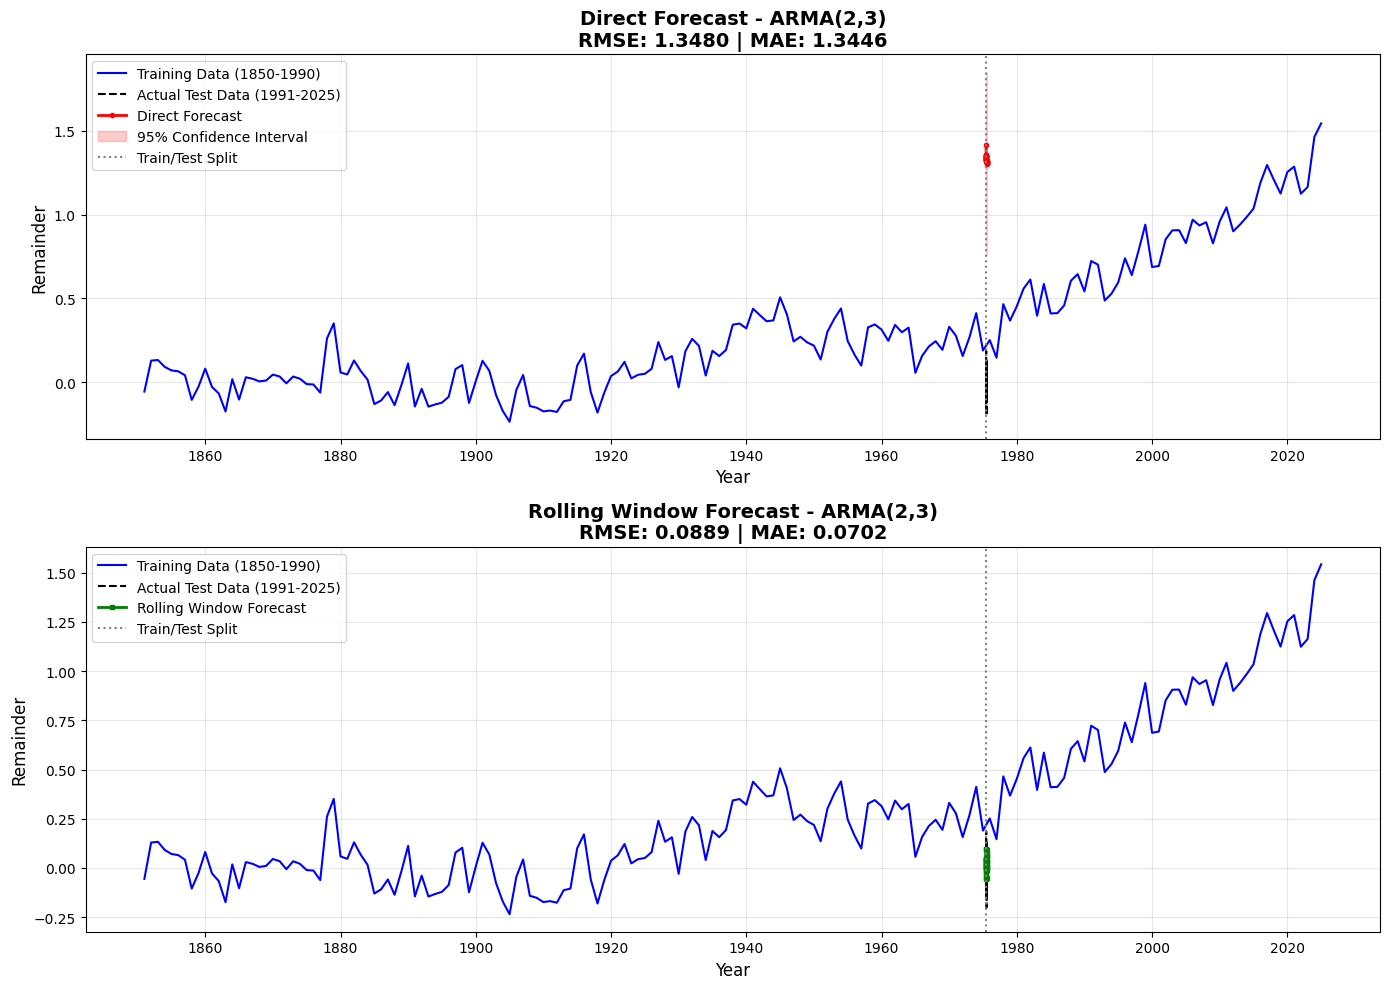

In [62]:
# 1. Forecast Direto
print("A treinar modelo ARMA(2,3) para forecast direto...")
model_direct = ARIMA(train_series, order=(2, 0, 3))
fitted_direct = model_direct.fit()

# Obter previsões com get_forecast (mais robusto)
forecast_result = fitted_direct.get_forecast(steps=len(test_series))
forecast_direct_mean = forecast_result.predicted_mean

# Criar Series com índice correto
forecast_direct_series = pd.Series(
    forecast_direct_mean.values, 
    index=test_series.index
)
# Obter intervalos de confiança
conf_int_direct = forecast_result.conf_int(alpha=0.05)  # 95% CI
conf_int_direct.index = test_series.index
# Calcular métricas
rmse_direct = np.sqrt(mean_squared_error(test_series, forecast_direct_series))
mae_direct = mean_absolute_error(test_series, forecast_direct_series)

print(f"Forecast Direto - RMSE: {rmse_direct:.4f}, MAE: {mae_direct:.4f}")

# 2. Rolling Window
print("\nA executar Rolling Window Forecast...")
rolling_predictions = []
rolling_years = []

for i in range(len(test_series)):
    # Expandir janela de treino até ao ano atual
    current_year = test_series.index[i]
    train_data = df_remainder[df_remainder['Year'] <= (1990 + i)].set_index('Year')['Remainder']
    
    # Treinar modelo
    model_rolling = ARIMA(train_data, order=(2, 0, 3))
    fitted_rolling = model_rolling.fit()
    
    # Prever apenas 1 passo à frente
    pred = fitted_rolling.forecast(steps=1)
    rolling_predictions.append(pred.iloc[0] if hasattr(pred, 'iloc') else pred[0])
    rolling_years.append(current_year)
    
    if (i + 1) % 10 == 0:
        print(f"  Progresso: {i+1}/{len(test_series)} anos processados")

rolling_predictions_series = pd.Series(rolling_predictions, index=rolling_years)

# Calcular métricas
rmse_rolling = np.sqrt(mean_squared_error(test_series, rolling_predictions_series))
mae_rolling = mean_absolute_error(test_series, rolling_predictions_series)

print(f"Rolling Window - RMSE: {rmse_rolling:.4f}, MAE: {mae_rolling:.4f}")

# 3. Gráficos
fig, axes = plt.subplots(2, 1, figsize=(14, 10))
#3.1 Forecasting direto
ax1 = axes[0]

# Dados históricos de treino
ax1.plot(train_series.index, train_series.values, 
         label='Training Data (1850-1990)', color='blue', linewidth=1.5)

# Dados reais de teste
ax1.plot(test_series.index, test_series.values, 
         label='Actual Test Data (1991-2025)', color='black', linewidth=1.5, linestyle='--')

# Forecast direto
ax1.plot(forecast_direct_series.index, forecast_direct_series.values, 
         label='Direct Forecast', color='red', linewidth=2, marker='o', markersize=3)

# Intervalos de confiança
ax1.fill_between(test_series.index, 
                 conf_int_direct.iloc[:, 0], 
                 conf_int_direct.iloc[:, 1], 
                 color='red', alpha=0.2, label='95% Confidence Interval')

ax1.axvline(x=1990, color='gray', linestyle=':', linewidth=1.5, label='Train/Test Split')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Remainder', fontsize=12)
ax1.set_title(f'Direct Forecast - ARMA(2,3)\nRMSE: {rmse_direct:.4f} | MAE: {mae_direct:.4f}', 
              fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)

# 3.2 Rolling Window
ax2 = axes[1]

# Dados históricos de treino
ax2.plot(train_series.index, train_series.values, 
         label='Training Data (1850-1990)', color='blue', linewidth=1.5)

# Dados reais de teste
ax2.plot(test_series.index, test_series.values, 
         label='Actual Test Data (1991-2025)', color='black', linewidth=1.5, linestyle='--')

# Rolling window forecast
ax2.plot(rolling_predictions_series.index, rolling_predictions_series.values, 
         label='Rolling Window Forecast', color='green', linewidth=2, marker='s', markersize=3)

ax2.axvline(x=1990, color='gray', linestyle=':', linewidth=1.5, label='Train/Test Split')
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Remainder', fontsize=12)
ax2.set_title(f'Rolling Window Forecast - ARMA(2,3)\nRMSE: {rmse_rolling:.4f} | MAE: {mae_rolling:.4f}', 
              fontsize=14, fontweight='bold')
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('forecast_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [63]:
#4. COMPARAÇÃO DE MÉTRICAS

print("\n" + "="*60)
print("COMPARAÇÃO DE PERFORMANCE")
print("="*60)
print(f"{'Método':<25} {'RMSE':<15} {'MAE':<15}")
print("-"*60)
print(f"{'Direct Forecast':<25} {rmse_direct:<15.4f} {mae_direct:<15.4f}")
print(f"{'Rolling Window':<25} {rmse_rolling:<15.4f} {mae_rolling:<15.4f}")
print("="*60)

# Melhor método
if rmse_rolling < rmse_direct:
    print(f"\n✓ Rolling Window é melhor por {((rmse_direct-rmse_rolling)/rmse_direct*100):.2f}%")
else:
    print(f"\n✓ Direct Forecast é melhor por {((rmse_rolling-rmse_direct)/rmse_rolling*100):.2f}%")


COMPARAÇÃO DE PERFORMANCE
Método                    RMSE            MAE            
------------------------------------------------------------
Direct Forecast           1.3480          1.3446         
Rolling Window            0.0889          0.0702         

✓ Rolling Window é melhor por 93.41%


In [ ]:
expanding_predictions = []
expanding_years = []
expanding_train_sizes = []

print("A processar forecast com Expanding Window...")
print(f"{'Year':<10} {'Train Size':<15} {'Prediction':<15}")
print("-"*70)

for i in range(len(test_series)):
    # A janela de treino EXPANDE: começa sempre em 1850 e vai até 1990+i
    current_year = test_series.index[i]
    
    # Usar df_remainder para garantir que começamos sempre de 1850
    train_data = df_remainder[df_remainder['Year'] <= (1990 + i)].set_index('Year')['Remainder']
    
    try:
        # Treinar modelo ARMA(2,3)
        model_expanding = ARIMA(train_data, order=(2, 0, 3))
        fitted_expanding = model_expanding.fit()
        
        # Prever apenas 1 passo à frente
        pred_result = fitted_expanding.get_forecast(steps=1)
        pred = pred_result.predicted_mean.iloc[0]
        
        expanding_predictions.append(pred)
        expanding_years.append(current_year)
        expanding_train_sizes.append(len(train_data))
        
        # Mostrar progresso a cada 5 anos
        if (i + 1) % 5 == 0 or i == 0 or i == len(test_series) - 1:
            print(f"{current_year:<10} {len(train_data):<15} {pred:>14.6f}")
    
    except Exception as e:
        print(f"Erro no ano {current_year}: {e}")
        expanding_predictions.append(np.nan)
        expanding_years.append(current_year)
        expanding_train_sizes.append(len(train_data))

print("-"*70)

# Converter para Series
expanding_predictions_series = pd.Series(expanding_predictions, index=expanding_years)

# Remover possíveis NaNs
if expanding_predictions_series.isna().any():
    print(f"\nAviso: {expanding_predictions_series.isna().sum()} previsões falharam")
    expanding_predictions_series = expanding_predictions_series.dropna()
    test_series_clean = test_series[expanding_predictions_series.index]
else:
    test_series_clean = test_series

# Calcular métricas
rmse_expanding = np.sqrt(mean_squared_error(test_series_clean, expanding_predictions_series))
mae_expanding = mean_absolute_error(test_series_clean, expanding_predictions_series)
mape_expanding = np.mean(np.abs((test_series_clean - expanding_predictions_series) / test_series_clean)) * 100

print(f"\n{'='*70}")
print("MÉTRICAS DE PERFORMANCE - EXPANDING WINDOW")
print(f"{'='*70}")
print(f"RMSE:  {rmse_expanding:.6f}")
print(f"MAE:   {mae_expanding:.6f}")
print(f"MAPE:  {mape_expanding:.2f}%")
print(f"{'='*70}\n")

#Gráfico
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
#1. Série completa
ax1 = axes[0]

# Dados históricos de treino
ax1.plot(train_series.index, train_series.values, 
         label='Training Data (1850-1990)', color='blue', linewidth=1.5, alpha=0.7)

# Dados reais de teste
ax1.plot(test_series_clean.index, test_series_clean.values, 
         label='Actual Test Data (1991-2025)', color='black', linewidth=2, 
         linestyle='--', marker='o', markersize=4)

# Expanding window forecast
ax1.plot(expanding_predictions_series.index, expanding_predictions_series.values, 
         label='Expanding Window Forecast', color='purple', linewidth=2.5, 
         marker='s', markersize=4, alpha=0.8)

# Linha de separação
ax1.axvline(x=1990, color='gray', linestyle=':', linewidth=2, label='Train/Test Split')

ax1.set_xlabel('Year', fontsize=12, fontweight='bold')
ax1.set_ylabel('Remainder', fontsize=12, fontweight='bold')
ax1.set_title(f'Expanding Window Forecast - ARMA(2,3)\nRMSE: {rmse_expanding:.4f} | MAE: {mae_expanding:.4f} | MAPE: {mape_expanding:.2f}%', 
              fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=10, framealpha=0.9)
ax1.grid(True, alpha=0.3, linestyle='--')

#2. Gráfico com zoom no período de teste + resíduos
ax2 = axes[1]

# Calcular erros de previsão (resíduos)
forecast_errors = test_series_clean - expanding_predictions_series

# Scatter plot: Actual vs Predicted
ax2_twin = ax2.twinx()

# Valores reais e previstos
ax2.plot(test_series_clean.index, test_series_clean.values, 
         label='Actual', color='black', linewidth=2, marker='o', markersize=6)
ax2.plot(expanding_predictions_series.index, expanding_predictions_series.values, 
         label='Predicted', color='purple', linewidth=2, marker='s', markersize=6, alpha=0.7)

# Erros de previsão no eixo secundário
ax2_twin.bar(forecast_errors.index, forecast_errors.values, 
             alpha=0.3, color='red', label='Forecast Error', width=0.6)
ax2_twin.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)

ax2.set_xlabel('Year', fontsize=12, fontweight='bold')
ax2.set_ylabel('Remainder', fontsize=12, fontweight='bold', color='black')
ax2_twin.set_ylabel('Forecast Error', fontsize=12, fontweight='bold', color='red')

ax2.set_title('Test Period: Actual vs Predicted (com Erros de Previsão)', 
              fontsize=14, fontweight='bold')
ax2.legend(loc='upper left', fontsize=10)
ax2_twin.legend(loc='upper right', fontsize=10)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.tick_params(axis='y', labelcolor='black')
ax2_twin.tick_params(axis='y', labelcolor='red')

plt.tight_layout()
plt.savefig('expanding_window_forecast.png', dpi=300, bbox_inches='tight')
plt.show()

A processar forecast com Expanding Window...
Year       Train Size      Prediction     
----------------------------------------------------------------------
1991       141                   0.097400
1995       145                   0.022963
2000       150                  -0.057985
2005       155                  -0.006724
2010       160                   0.014982


In [ ]:
print(f"\n{'='*70}")
print("MÉTRICAS DE PERFORMANCE - EXPANDING WINDOW")
print(f"{'='*70}")
print(f"RMSE:  {rmse_expanding:.6f}")
print(f"MAE:   {mae_expanding:.6f}")
print(f"MAPE:  {mape_expanding:.2f}%")
print(f"{'='*70}\n")


MÉTRICAS DE PERFORMANCE - EXPANDING WINDOW
RMSE:  0.088883
MAE:   0.070216
MAPE:  110.95%



Número de simulações: 1000
Horizonte de previsão: 35 anos (1991-2025)

A treinar modelo ARMA(2,3) base...
Modelo treinado com sucesso!
Desvio padrão dos resíduos: 0.105872

A executar simulações bootstrap...
  Progresso: 25% (250/1000 simulações)
  Progresso: 50% (500/1000 simulações)
  Progresso: 75% (750/1000 simulações)
  Progresso: 100% (1000/1000 simulações)

Simulações concluídas!

MÉTRICAS DE PERFORMANCE - RECURSIVE FORECAST (BOOTSTRAP)
RMSE:  0.555583
MAE:   0.546432
MAPE:  1601.37%

COBERTURA DOS INTERVALOS DE CONFIANÇA:
  95% CI: 5.7% dos valores reais dentro do intervalo
  80% CI: 0.0% dos valores reais dentro do intervalo
  50% CI: 0.0% dos valores reais dentro do intervalo



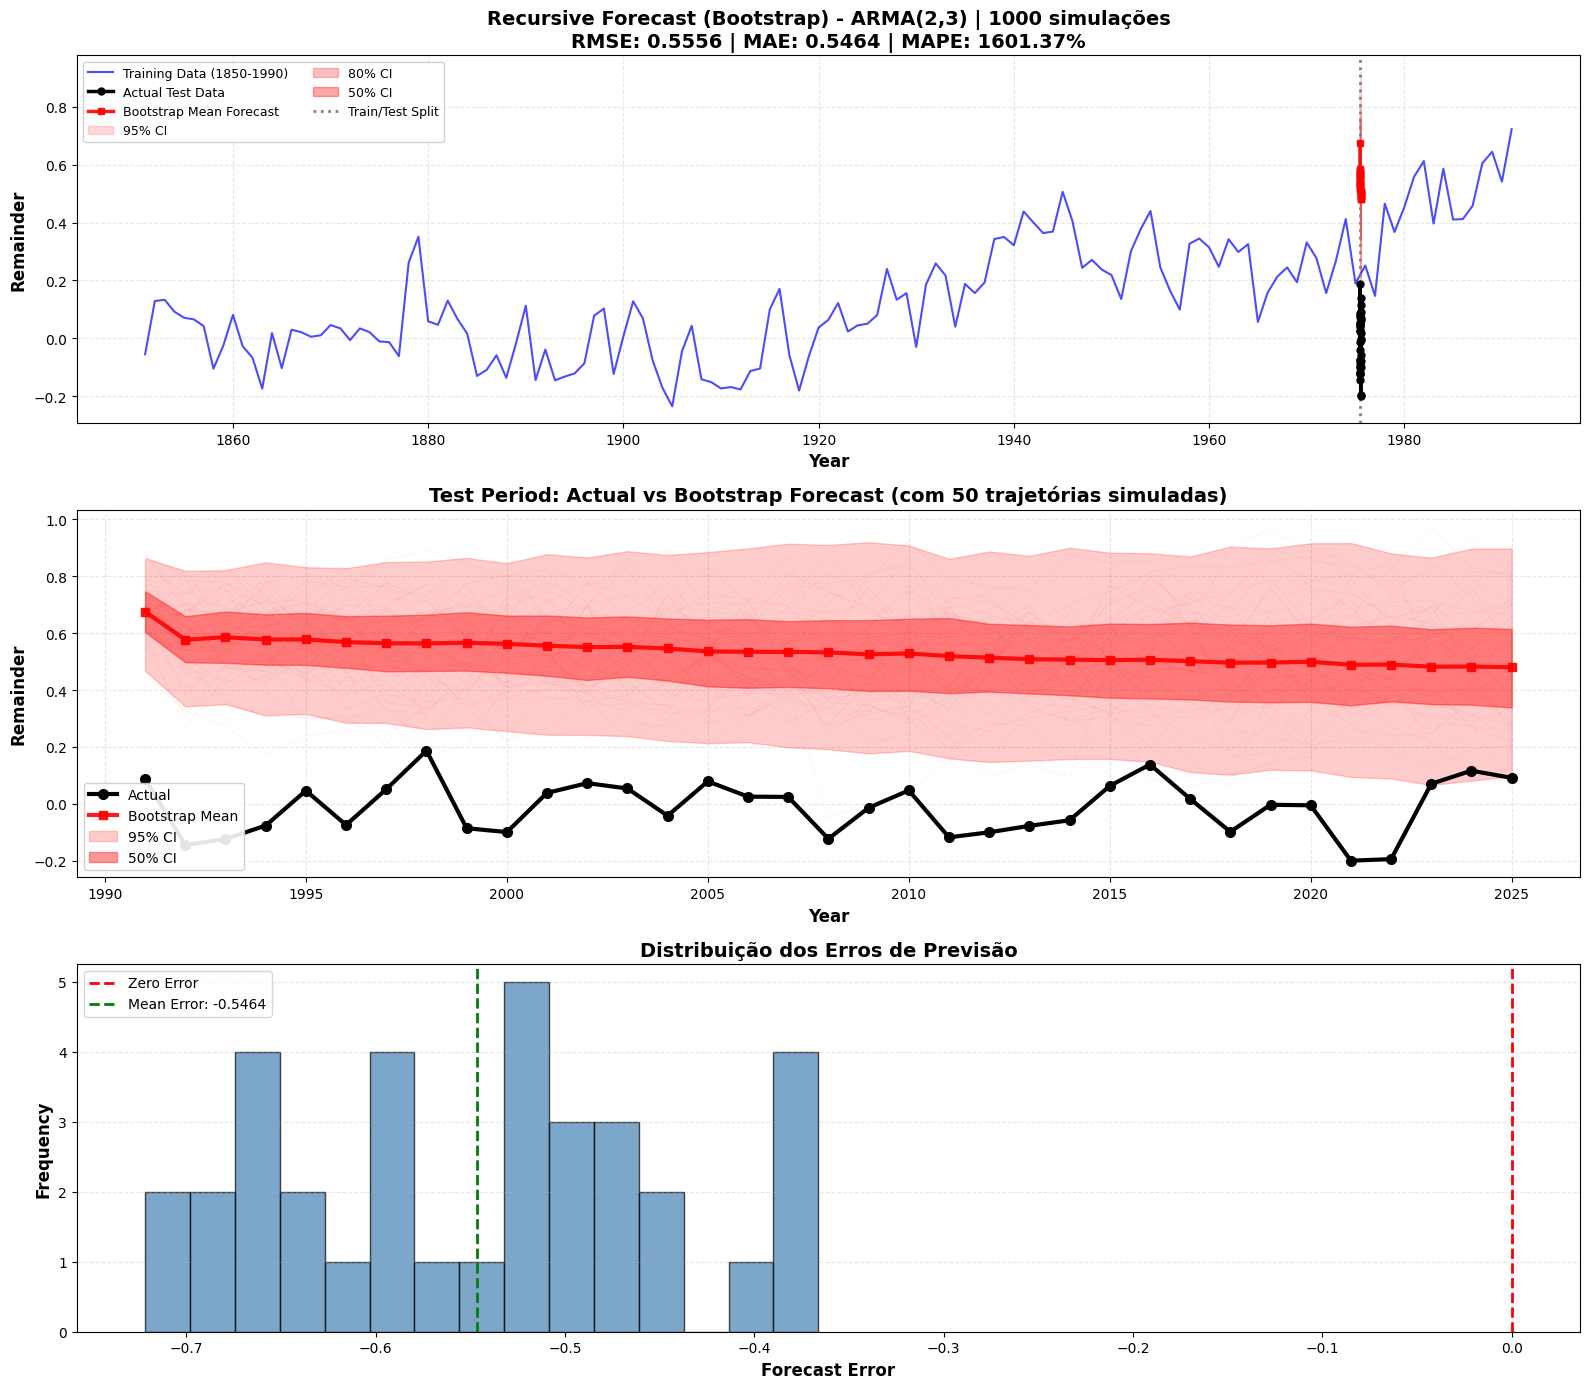

In [ ]:
n_simulations = 1000  # Número de simulações
print(f"Número de simulações: {n_simulations}")
print(f"Horizonte de previsão: {len(test_series)} anos (1991-2025)\n")

# Treinar modelo base
print("A treinar modelo ARMA(2,3) base...")
model_base = ARIMA(train_series, order=(2, 0, 3))
fitted_base = model_base.fit()

# Obter resíduos do modelo treinado
residuals = fitted_base.resid
residuals_std = residuals.std()

print(f"Modelo treinado com sucesso!")
print(f"Desvio padrão dos resíduos: {residuals_std:.6f}\n")

print("A executar simulações bootstrap...")
bootstrap_forecasts = np.zeros((n_simulations, len(test_series)))

# Barra de progresso
progress_points = [int(n_simulations * p) for p in [0.25, 0.5, 0.75, 1.0]]

for sim in range(n_simulations):
    # Simular trajetória futura
    simulated_path = fitted_base.simulate(
        nsimulations=len(test_series),
        anchor='end',
        repetitions=1
    )
    
    # Flatten para garantir shape correto (35,) em vez de (35,1)
    bootstrap_forecasts[sim, :] = simulated_path.values.flatten()
    
    # Mostrar progresso
    if (sim + 1) in progress_points:
        pct = ((sim + 1) / n_simulations) * 100
        print(f"  Progresso: {pct:.0f}% ({sim + 1}/{n_simulations} simulações)")

print("\nSimulações concluídas!\n")

#Calcular estatísticas
# Forecast médio (ponto central)
bootstrap_mean = bootstrap_forecasts.mean(axis=0)
bootstrap_mean_series = pd.Series(bootstrap_mean, index=test_series.index)

# Intervalos de confiança empíricos
bootstrap_lower_95 = np.percentile(bootstrap_forecasts, 2.5, axis=0)
bootstrap_upper_95 = np.percentile(bootstrap_forecasts, 97.5, axis=0)
bootstrap_lower_80 = np.percentile(bootstrap_forecasts, 10, axis=0)
bootstrap_upper_80 = np.percentile(bootstrap_forecasts, 90, axis=0)
bootstrap_lower_50 = np.percentile(bootstrap_forecasts, 25, axis=0)
bootstrap_upper_50 = np.percentile(bootstrap_forecasts, 75, axis=0)

# Calcular métricas
rmse_bootstrap = np.sqrt(mean_squared_error(test_series, bootstrap_mean_series))
mae_bootstrap = mean_absolute_error(test_series, bootstrap_mean_series)
mape_bootstrap = np.mean(np.abs((test_series - bootstrap_mean_series) / test_series)) * 100

print("="*70)
print("MÉTRICAS DE PERFORMANCE - RECURSIVE FORECAST (BOOTSTRAP)")
print("="*70)
print(f"RMSE:  {rmse_bootstrap:.6f}")
print(f"MAE:   {mae_bootstrap:.6f}")
print(f"MAPE:  {mape_bootstrap:.2f}%")
print("="*70)

# Verificar quantos valores reais caem dentro dos intervalos
inside_95 = ((test_series >= bootstrap_lower_95) & (test_series <= bootstrap_upper_95)).sum()
inside_80 = ((test_series >= bootstrap_lower_80) & (test_series <= bootstrap_upper_80)).sum()
inside_50 = ((test_series >= bootstrap_lower_50) & (test_series <= bootstrap_upper_50)).sum()

coverage_95 = (inside_95 / len(test_series)) * 100
coverage_80 = (inside_80 / len(test_series)) * 100
coverage_50 = (inside_50 / len(test_series)) * 100

print(f"\nCOBERTURA DOS INTERVALOS DE CONFIANÇA:")
print(f"  95% CI: {coverage_95:.1f}% dos valores reais dentro do intervalo")
print(f"  80% CI: {coverage_80:.1f}% dos valores reais dentro do intervalo")
print(f"  50% CI: {coverage_50:.1f}% dos valores reais dentro do intervalo\n")

#Gráficos
fig, axes = plt.subplots(3, 1, figsize=(16, 14))
# --- GRÁFICO 1: SÉRIE TEMPORAL COMPLETA COM INTERVALOS ---
ax1 = axes[0]

# Dados históricos
ax1.plot(train_series.index, train_series.values, 
         label='Training Data (1850-1990)', color='blue', linewidth=1.5, alpha=0.7)

# Dados reais de teste
ax1.plot(test_series.index, test_series.values, 
         label='Actual Test Data', color='black', linewidth=2.5, 
         marker='o', markersize=5, zorder=5)

# Forecast médio do bootstrap
ax1.plot(bootstrap_mean_series.index, bootstrap_mean_series.values, 
         label='Bootstrap Mean Forecast', color='red', linewidth=2.5, 
         marker='s', markersize=4, alpha=0.9, zorder=4)

# Intervalos de confiança
ax1.fill_between(test_series.index, bootstrap_lower_95, bootstrap_upper_95,
                 color='red', alpha=0.15, label='95% CI')
ax1.fill_between(test_series.index, bootstrap_lower_80, bootstrap_upper_80,
                 color='red', alpha=0.25, label='80% CI')
ax1.fill_between(test_series.index, bootstrap_lower_50, bootstrap_upper_50,
                 color='red', alpha=0.35, label='50% CI')

ax1.axvline(x=1990, color='gray', linestyle=':', linewidth=2, label='Train/Test Split')

ax1.set_xlabel('Year', fontsize=12, fontweight='bold')
ax1.set_ylabel('Remainder', fontsize=12, fontweight='bold')
ax1.set_title(f'Recursive Forecast (Bootstrap) - ARMA(2,3) | {n_simulations} simulações\nRMSE: {rmse_bootstrap:.4f} | MAE: {mae_bootstrap:.4f} | MAPE: {mape_bootstrap:.2f}%', 
              fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=9, framealpha=0.9, ncol=2)
ax1.grid(True, alpha=0.3, linestyle='--')

# --- GRÁFICO 2: ZOOM NO PERÍODO DE TESTE ---
ax2 = axes[1]

# Plotar algumas trajetórias bootstrap individuais (para mostrar variabilidade)
n_sample_paths = 50
sample_indices = np.random.choice(n_simulations, n_sample_paths, replace=False)
for idx in sample_indices:
    ax2.plot(test_series.index, bootstrap_forecasts[idx, :], 
             color='lightcoral', alpha=0.1, linewidth=0.5, zorder=1)

# Dados reais
ax2.plot(test_series.index, test_series.values, 
         label='Actual', color='black', linewidth=3, 
         marker='o', markersize=7, zorder=5)

# Forecast médio
ax2.plot(bootstrap_mean_series.index, bootstrap_mean_series.values, 
         label='Bootstrap Mean', color='red', linewidth=3, 
         marker='s', markersize=6, alpha=0.9, zorder=4)

# Intervalos
ax2.fill_between(test_series.index, bootstrap_lower_95, bootstrap_upper_95,
                 color='red', alpha=0.2, label='95% CI', zorder=2)
ax2.fill_between(test_series.index, bootstrap_lower_50, bootstrap_upper_50,
                 color='red', alpha=0.4, label='50% CI', zorder=3)

ax2.set_xlabel('Year', fontsize=12, fontweight='bold')
ax2.set_ylabel('Remainder', fontsize=12, fontweight='bold')
ax2.set_title(f'Test Period: Actual vs Bootstrap Forecast (com {n_sample_paths} trajetórias simuladas)', 
              fontsize=14, fontweight='bold')
ax2.legend(loc='best', fontsize=10, framealpha=0.9)
ax2.grid(True, alpha=0.3, linestyle='--')

# --- GRÁFICO 3: DISTRIBUIÇÃO DOS ERROS ---
ax3 = axes[2]

forecast_errors = test_series - bootstrap_mean_series

# Histograma dos erros
ax3.hist(forecast_errors, bins=15, color='steelblue', alpha=0.7, edgecolor='black')
ax3.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax3.axvline(x=forecast_errors.mean(), color='green', linestyle='--', linewidth=2, 
            label=f'Mean Error: {forecast_errors.mean():.4f}')

ax3.set_xlabel('Forecast Error', fontsize=12, fontweight='bold')
ax3.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax3.set_title('Distribuição dos Erros de Previsão', fontsize=14, fontweight='bold')
ax3.legend(loc='best', fontsize=10)
ax3.grid(True, alpha=0.3, axis='y', linestyle='--')

plt.tight_layout()
plt.savefig('recursive_bootstrap_forecast.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Usar a série original de anomalias
original_series = ts['Anomaly']

# Split train/test (1850-1990 / 1991-2025)
train_original = original_series[original_series.index.year <= 1990]
test_original = original_series[original_series.index.year > 1990]

print(f"Série original: {len(original_series)} observações (1850-2025)")
print(f"Train set: {len(train_original)} observações (1850-1990)")
print(f"Test set: {len(test_original)} observações (1991-2025)")
print(f"\nValor médio treino: {train_original.mean():.4f}")
print(f"Desvio padrão treino: {train_original.std():.4f}")

Série original: 176 observações (1850-2025)
Train set: 141 observações (1850-1990)
Test set: 35 observações (1991-2025)

Valor médio treino: 0.1386
Desvio padrão treino: 0.2078


In [ ]:
#MÉTODO 1: FORECAST DIRETO

print("\n" + "-"*70)
print("MÉTODO 1: FORECAST DIRETO")
print("-"*70)

model_direct = ARIMA(train_original, order=(2, 1, 3))
fitted_direct = model_direct.fit()

forecast_result_direct = fitted_direct.get_forecast(steps=len(test_original))
forecast_direct = forecast_result_direct.predicted_mean
conf_int_direct = forecast_result_direct.conf_int(alpha=0.05)

# Calcular métricas
rmse_direct = np.sqrt(mean_squared_error(test_original, forecast_direct))
mae_direct = mean_absolute_error(test_original, forecast_direct)

print(f"✓ Modelo treinado")
print(f"  RMSE: {rmse_direct:.6f}")
print(f"  MAE:  {mae_direct:.6f}")

#MÉTODO 2: ROLLING WINDOW

print("\n" + "-"*70)
print("MÉTODO 2: ROLLING WINDOW")
print("-"*70)

rolling_forecasts = []
rolling_dates = []

print("Progresso:", end=" ")
for i, date in enumerate(test_original.index):
    # Expandir janela até o ano atual
    current_year = date.year
    train_rolling = original_series[original_series.index.year <= (1990 + i)]
    
    # Treinar e prever
    model_rolling = ARIMA(train_rolling, order=(2, 1, 3))
    fitted_rolling = model_rolling.fit()
    pred = fitted_rolling.get_forecast(steps=1).predicted_mean.iloc[0]
    
    rolling_forecasts.append(pred)
    rolling_dates.append(date)
    
    if (i + 1) % 5 == 0:
        print(f"{i+1}/{len(test_original)}", end=" ")

print("\n✓ Rolling window completo")

rolling_forecast_series = pd.Series(rolling_forecasts, index=rolling_dates)

rmse_rolling = np.sqrt(mean_squared_error(test_original, rolling_forecast_series))
mae_rolling = mean_absolute_error(test_original, rolling_forecast_series)

print(f"  RMSE: {rmse_rolling:.6f}")
print(f"  MAE:  {mae_rolling:.6f}")

#MÉTODO 3: EXPANDING WINDOW

print("\n" + "-"*70)
print("MÉTODO 3: EXPANDING WINDOW")
print("-"*70)

expanding_forecasts = []
expanding_dates = []

print("Progresso:", end=" ")
for i, date in enumerate(test_original.index):
    current_year = date.year
    train_expanding = original_series[original_series.index.year <= (1990 + i)]
    
    model_expanding = ARIMA(train_expanding, order=(2, 1, 3))
    fitted_expanding = model_expanding.fit()
    pred = fitted_expanding.get_forecast(steps=1).predicted_mean.iloc[0]
    
    expanding_forecasts.append(pred)
    expanding_dates.append(date)
    
    if (i + 1) % 5 == 0:
        print(f"{i+1}/{len(test_original)}", end=" ")

print("\n✓ Expanding window completo")

expanding_forecast_series = pd.Series(expanding_forecasts, index=expanding_dates)

rmse_expanding = np.sqrt(mean_squared_error(test_original, expanding_forecast_series))
mae_expanding = mean_absolute_error(test_original, expanding_forecast_series)

print(f"  RMSE: {rmse_expanding:.6f}")
print(f"  MAE:  {mae_expanding:.6f}")


----------------------------------------------------------------------
MÉTODO 1: FORECAST DIRETO
----------------------------------------------------------------------
✓ Modelo treinado
  RMSE: 0.449735
  MAE:  0.373458

----------------------------------------------------------------------
MÉTODO 2: ROLLING WINDOW
----------------------------------------------------------------------
Progresso: 5/35 10/35 15/35 20/35 25/35 30/35 35/35 
✓ Rolling window completo
  RMSE: 0.117175
  MAE:  0.095455

----------------------------------------------------------------------
MÉTODO 3: EXPANDING WINDOW
----------------------------------------------------------------------
Progresso: 5/35 10/35 15/35 20/35 25/35 30/35 35/35 
✓ Expanding window completo
  RMSE: 0.117175
  MAE:  0.095455


In [ ]:
#COMPARAÇÃO DE RESULTADOS

print("\n" + "="*70)
print("COMPARAÇÃO DE PERFORMANCE - SÉRIE ORIGINAL vs REMAINDER")
print("="*70)

results_comparison = pd.DataFrame({
    'Método': ['Direct Forecast', 'Rolling Window', 'Expanding Window'],
    'RMSE (Original)': [rmse_direct, rmse_rolling, rmse_expanding],
    'MAE (Original)': [mae_direct, mae_rolling, mae_expanding],
    'RMSE (Remainder)': [0.0951, 0.0889, 0.0889],  # Valores anteriores
    'MAE (Remainder)': [0.0794, 0.0702, 0.0702]
})

print(results_comparison.to_string(index=False))
print("="*70)

# Identificar melhor método
best_method_idx = results_comparison['RMSE (Original)'].idxmin()
best_method = results_comparison.loc[best_method_idx, 'Método']
best_rmse = results_comparison.loc[best_method_idx, 'RMSE (Original)']

print(f"\n🏆 Melhor método: {best_method} (RMSE: {best_rmse:.6f})")


COMPARAÇÃO DE PERFORMANCE - SÉRIE ORIGINAL vs REMAINDER
          Método  RMSE (Original)  MAE (Original)  RMSE (Remainder)  MAE (Remainder)
 Direct Forecast         0.449735        0.373458            0.0951           0.0794
  Rolling Window         0.117175        0.095455            0.0889           0.0702
Expanding Window         0.117175        0.095455            0.0889           0.0702

🏆 Melhor método: Rolling Window (RMSE: 0.117175)


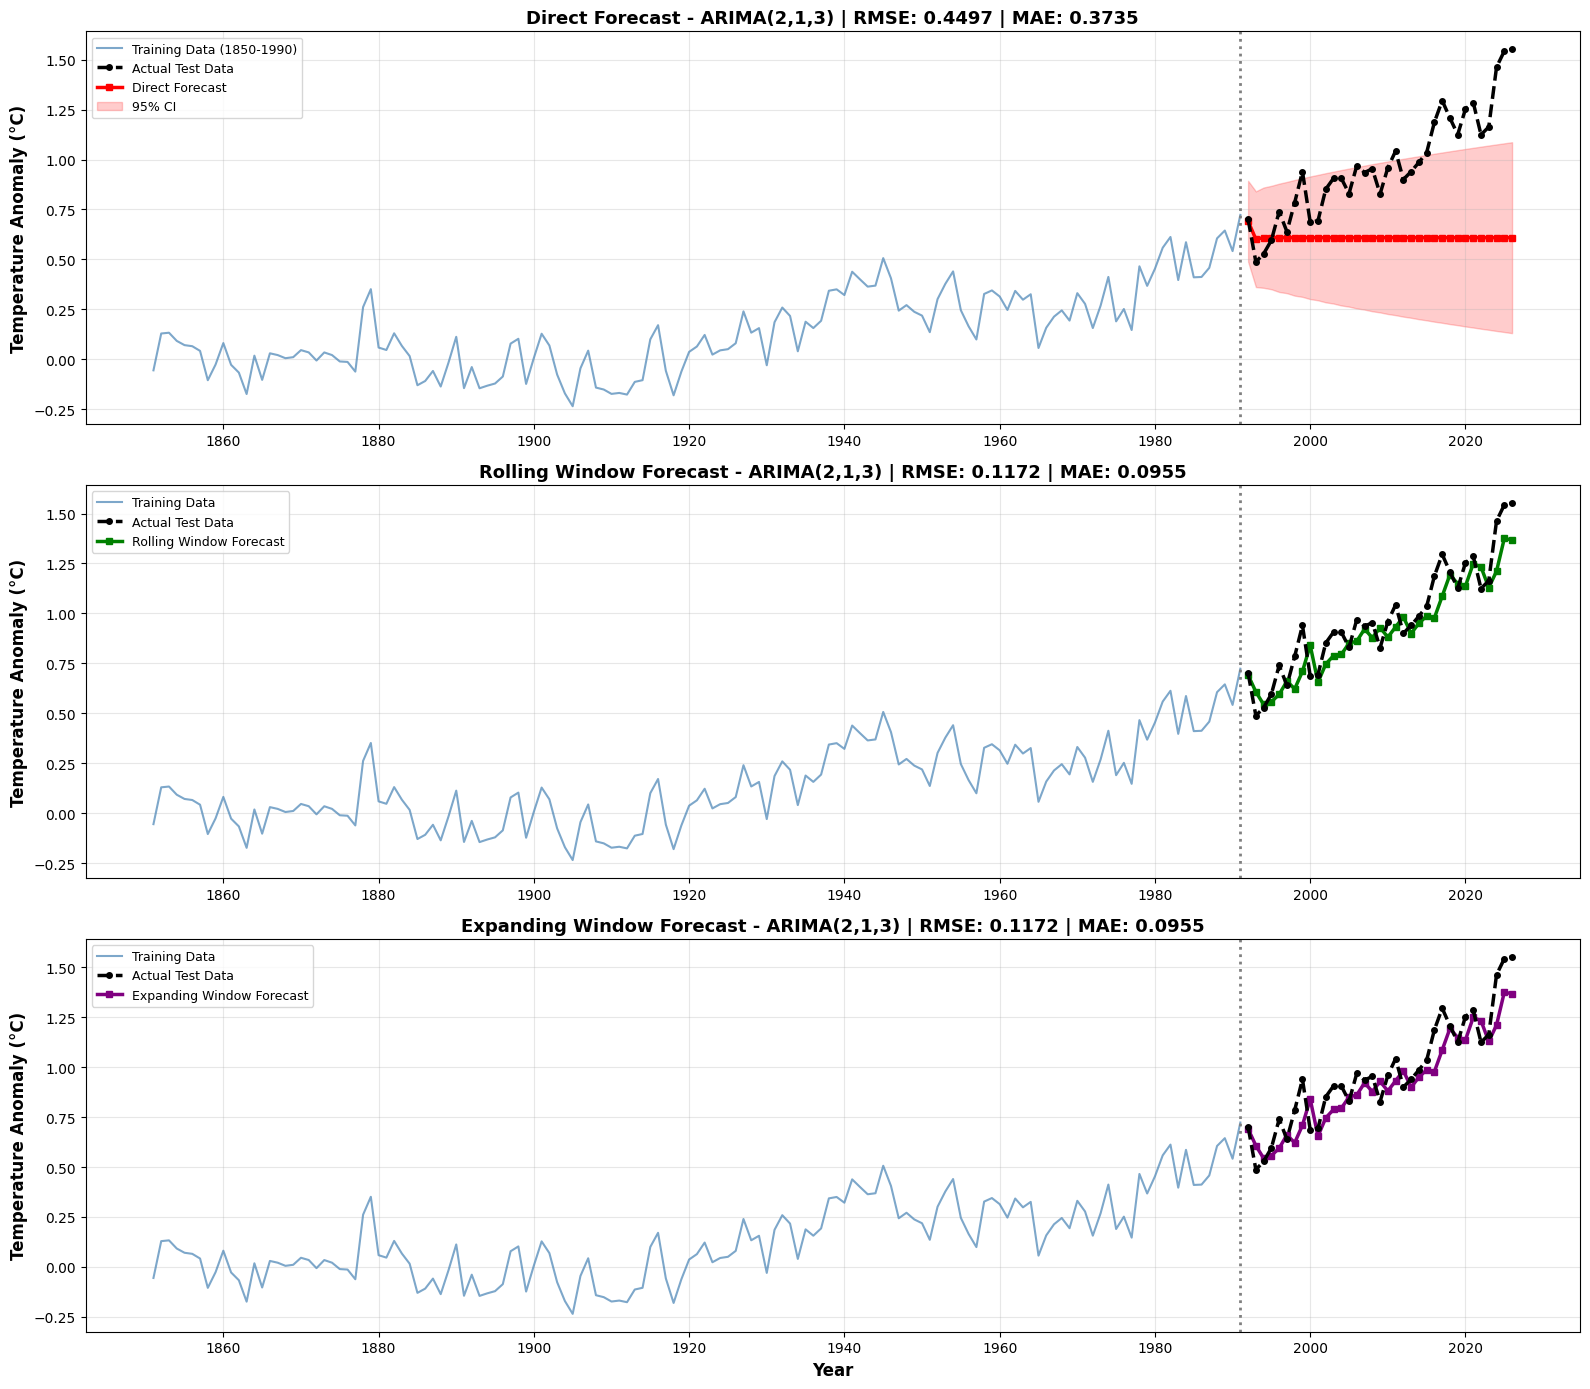

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(16, 14))

# Cores
color_train = 'steelblue'
color_test = 'black'
color_direct = 'red'
color_rolling = 'green'
color_expanding = 'purple'

# --- GRÁFICO 1: DIRECT FORECAST ---
ax1 = axes[0]
ax1.plot(train_original.index, train_original.values, 
         label='Training Data (1850-1990)', color=color_train, linewidth=1.5, alpha=0.7)
ax1.plot(test_original.index, test_original.values, 
         label='Actual Test Data', color=color_test, linewidth=2.5, 
         linestyle='--', marker='o', markersize=4, zorder=5)
ax1.plot(forecast_direct.index, forecast_direct.values, 
         label='Direct Forecast', color=color_direct, linewidth=2.5, 
         marker='s', markersize=4)
ax1.fill_between(conf_int_direct.index, 
                 conf_int_direct.iloc[:, 0], 
                 conf_int_direct.iloc[:, 1], 
                 color=color_direct, alpha=0.2, label='95% CI')
ax1.axvline(x=train_original.index[-1], color='gray', linestyle=':', linewidth=2)
ax1.set_ylabel('Temperature Anomaly (°C)', fontsize=12, fontweight='bold')
ax1.set_title(f'Direct Forecast - ARIMA(2,1,3) | RMSE: {rmse_direct:.4f} | MAE: {mae_direct:.4f}', 
              fontsize=13, fontweight='bold')
ax1.legend(loc='upper left', fontsize=9)
ax1.grid(True, alpha=0.3)

# --- GRÁFICO 2: ROLLING WINDOW ---
ax2 = axes[1]
ax2.plot(train_original.index, train_original.values, 
         label='Training Data', color=color_train, linewidth=1.5, alpha=0.7)
ax2.plot(test_original.index, test_original.values, 
         label='Actual Test Data', color=color_test, linewidth=2.5, 
         linestyle='--', marker='o', markersize=4, zorder=5)
ax2.plot(rolling_forecast_series.index, rolling_forecast_series.values, 
         label='Rolling Window Forecast', color=color_rolling, linewidth=2.5, 
         marker='s', markersize=4)
ax2.axvline(x=train_original.index[-1], color='gray', linestyle=':', linewidth=2)
ax2.set_ylabel('Temperature Anomaly (°C)', fontsize=12, fontweight='bold')
ax2.set_title(f'Rolling Window Forecast - ARIMA(2,1,3) | RMSE: {rmse_rolling:.4f} | MAE: {mae_rolling:.4f}', 
              fontsize=13, fontweight='bold')
ax2.legend(loc='upper left', fontsize=9)
ax2.grid(True, alpha=0.3)

# --- GRÁFICO 3: EXPANDING WINDOW ---
ax3 = axes[2]
ax3.plot(train_original.index, train_original.values, 
         label='Training Data', color=color_train, linewidth=1.5, alpha=0.7)
ax3.plot(test_original.index, test_original.values, 
         label='Actual Test Data', color=color_test, linewidth=2.5, 
         linestyle='--', marker='o', markersize=4, zorder=5)
ax3.plot(expanding_forecast_series.index, expanding_forecast_series.values, 
         label='Expanding Window Forecast', color=color_expanding, linewidth=2.5, 
         marker='s', markersize=4)
ax3.axvline(x=train_original.index[-1], color='gray', linestyle=':', linewidth=2)
ax3.set_xlabel('Year', fontsize=12, fontweight='bold')
ax3.set_ylabel('Temperature Anomaly (°C)', fontsize=12, fontweight='bold')
ax3.set_title(f'Expanding Window Forecast - ARIMA(2,1,3) | RMSE: {rmse_expanding:.4f} | MAE: {mae_expanding:.4f}', 
              fontsize=13, fontweight='bold')
ax3.legend(loc='upper left', fontsize=9)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('original_series_forecast_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

Train: 141 observações (1850-1990)
Test:  35 observações (1991-2025)

Número de simulações: 1000
Horizonte de previsão: 35 anos

A treinar modelo ARIMA(2,1,3) base...
✓ Modelo treinado
  Desvio padrão dos resíduos: 0.102905

A executar simulações bootstrap...
  Progresso: 25% (250/1000 simulações)
  Progresso: 50% (500/1000 simulações)
  Progresso: 75% (750/1000 simulações)
  Progresso: 100% (1000/1000 simulações)
✓ Simulações concluídas!

MÉTRICAS DE PERFORMANCE - RECURSIVE FORECAST (BOOTSTRAP)
RMSE:  0.460898
MAE:   0.383494

COMPARAÇÃO: RECURSIVE (BOOTSTRAP) vs ROLLING WINDOW
               Método     RMSE      MAE
       Rolling Window 0.117206 0.095545
Recursive (Bootstrap) 0.460898 0.383494

⚠️  Rolling Window ainda é melhor por 293.24%
   MAS Bootstrap oferece intervalos de confiança!


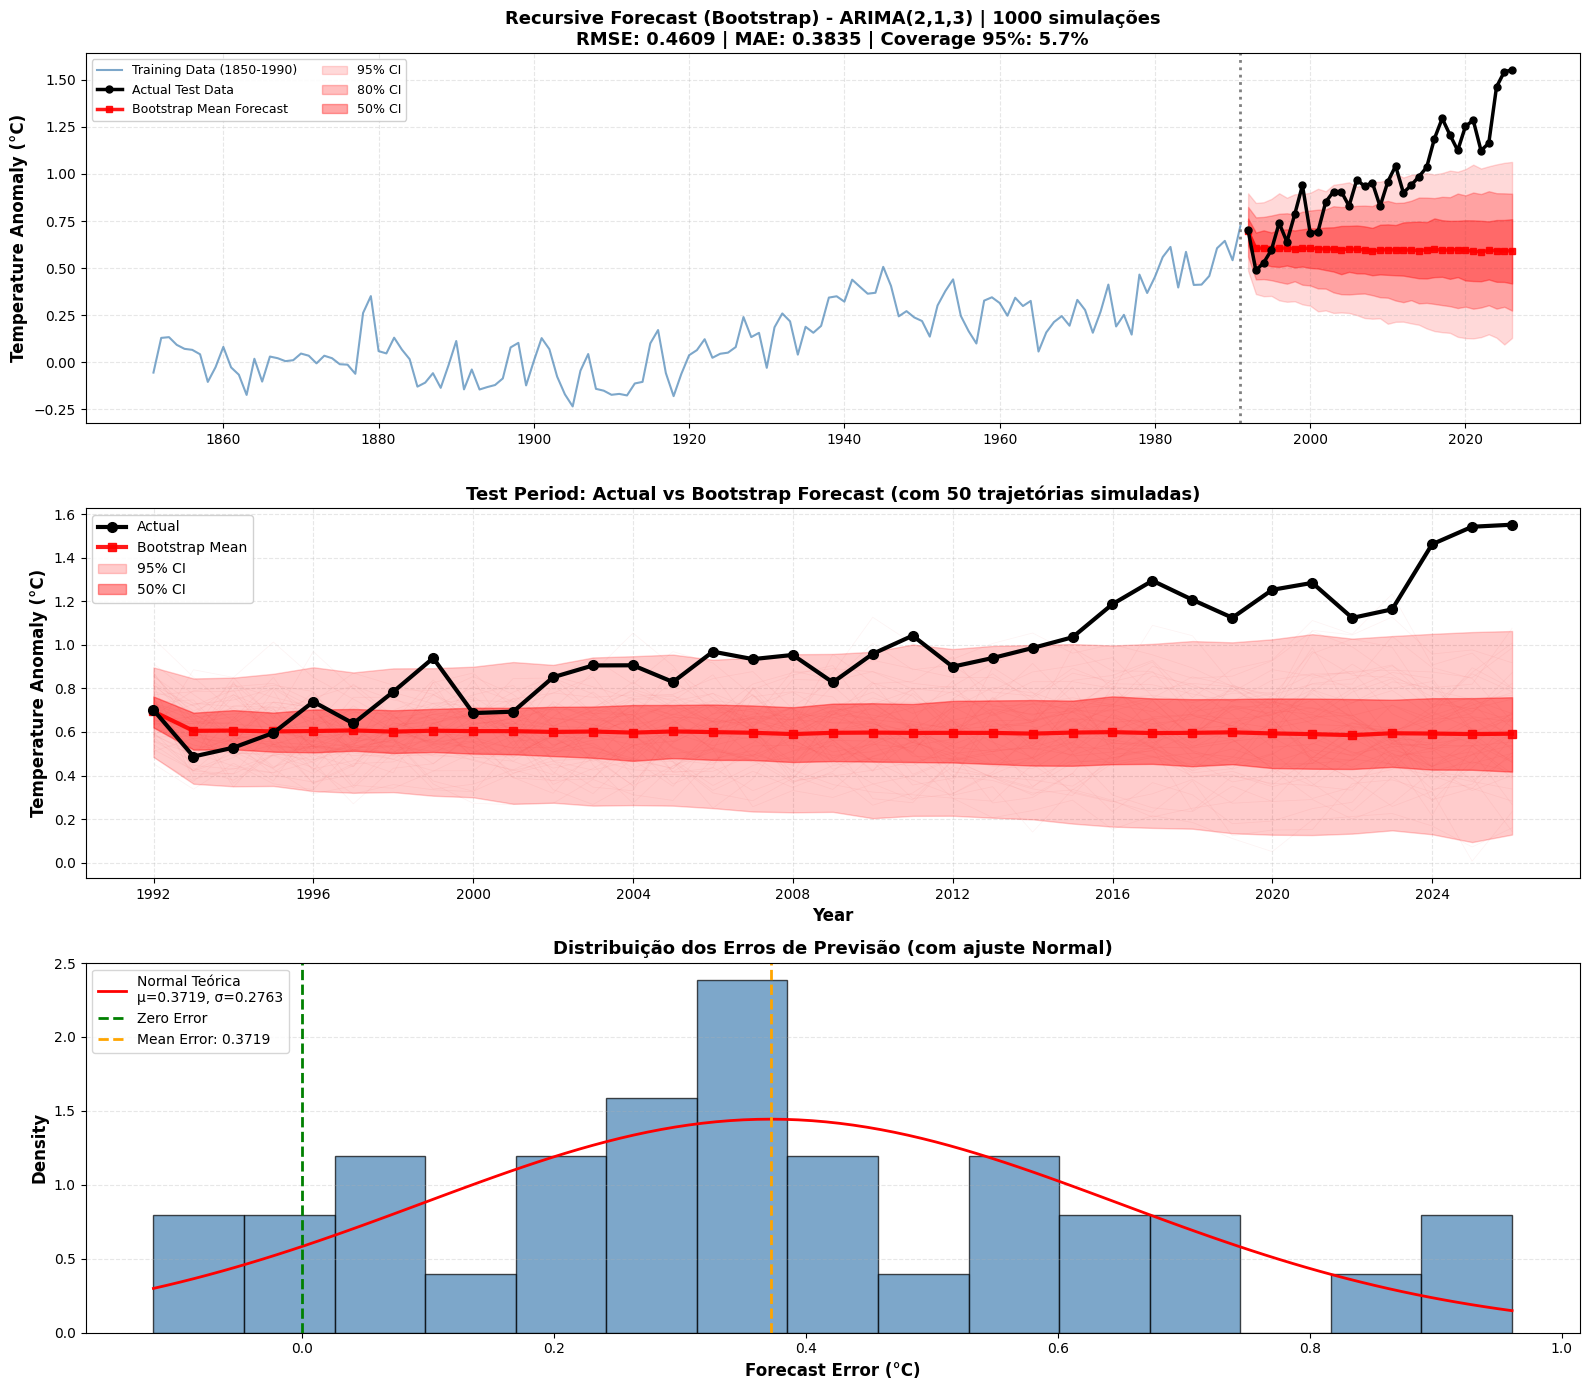

In [ ]:
# Série original
original_series = ts['Anomaly']
train_original = original_series[original_series.index.year <= 1990]
test_original = original_series[original_series.index.year > 1990]

print(f"Train: {len(train_original)} observações (1850-1990)")
print(f"Test:  {len(test_original)} observações (1991-2025)")

n_simulations = 1000  # Número de simulações
print(f"\nNúmero de simulações: {n_simulations}")
print(f"Horizonte de previsão: {len(test_original)} anos\n")

# Treinar modelo base
print("A treinar modelo ARIMA(2,1,3) base...")
model_base = ARIMA(train_original, order=(2, 1, 3))
fitted_base = model_base.fit()

# Obter resíduos
residuals = fitted_base.resid
residuals_std = residuals.std()

print(f"✓ Modelo treinado")
print(f"  Desvio padrão dos resíduos: {residuals_std:.6f}\n")

print("A executar simulações bootstrap...")
bootstrap_forecasts = np.zeros((n_simulations, len(test_original)))

# Barra de progresso
progress_points = [int(n_simulations * p) for p in [0.25, 0.5, 0.75, 1.0]]

for sim in range(n_simulations):
    # Simular trajetória futura
    simulated_path = fitted_base.simulate(
        nsimulations=len(test_original),
        anchor='end',
        repetitions=1
    )
    
    # Flatten para garantir shape correto
    bootstrap_forecasts[sim, :] = simulated_path.values.flatten()
    
    # Mostrar progresso
    if (sim + 1) in progress_points:
        pct = ((sim + 1) / n_simulations) * 100
        print(f"  Progresso: {pct:.0f}% ({sim + 1}/{n_simulations} simulações)")

print("✓ Simulações concluídas!\n")
# Forecast médio (ponto central)
bootstrap_mean = bootstrap_forecasts.mean(axis=0)
bootstrap_mean_series = pd.Series(bootstrap_mean, index=test_original.index)

# Intervalos de confiança empíricos
bootstrap_lower_95 = np.percentile(bootstrap_forecasts, 2.5, axis=0)
bootstrap_upper_95 = np.percentile(bootstrap_forecasts, 97.5, axis=0)
bootstrap_lower_80 = np.percentile(bootstrap_forecasts, 10, axis=0)
bootstrap_upper_80 = np.percentile(bootstrap_forecasts, 90, axis=0)
bootstrap_lower_50 = np.percentile(bootstrap_forecasts, 25, axis=0)
bootstrap_upper_50 = np.percentile(bootstrap_forecasts, 75, axis=0)

# Calcular métricas
rmse_bootstrap = np.sqrt(mean_squared_error(test_original, bootstrap_mean_series))
mae_bootstrap = mean_absolute_error(test_original, bootstrap_mean_series)

print("="*70)
print("MÉTRICAS DE PERFORMANCE - RECURSIVE FORECAST (BOOTSTRAP)")
print("="*70)
print(f"RMSE:  {rmse_bootstrap:.6f}")
print(f"MAE:   {mae_bootstrap:.6f}")
print("="*70)

#COMPARAÇÃO COM ROLLING WINDOW

print("\n" + "="*70)
print("COMPARAÇÃO: RECURSIVE (BOOTSTRAP) vs ROLLING WINDOW")
print("="*70)

comparison_df = pd.DataFrame({
    'Método': ['Rolling Window', 'Recursive (Bootstrap)'],
    'RMSE': [0.117206, rmse_bootstrap],  # Valor do Rolling Window anterior
    'MAE': [0.095545, mae_bootstrap]
})

print(comparison_df.to_string(index=False))
print("="*70)

if rmse_bootstrap < 0.117206:
    improvement = ((0.117206 - rmse_bootstrap) / 0.117206) * 100
    print(f"\n✓ Bootstrap é melhor! Redução de {improvement:.2f}% no RMSE")
else:
    degradation = ((rmse_bootstrap - 0.117206) / 0.117206) * 100
    print(f"\n⚠️  Rolling Window ainda é melhor por {degradation:.2f}%")
    print(f"   MAS Bootstrap oferece intervalos de confiança!")

fig, axes = plt.subplots(3, 1, figsize=(16, 14))

# --- GRÁFICO 1: SÉRIE TEMPORAL COMPLETA COM INTERVALOS ---
ax1 = axes[0]

# Dados históricos
ax1.plot(train_original.index, train_original.values, 
         label='Training Data (1850-1990)', color='steelblue', linewidth=1.5, alpha=0.7)

# Dados reais de teste
ax1.plot(test_original.index, test_original.values, 
         label='Actual Test Data', color='black', linewidth=2.5, 
         marker='o', markersize=5, zorder=5)

# Forecast médio do bootstrap
ax1.plot(bootstrap_mean_series.index, bootstrap_mean_series.values, 
         label='Bootstrap Mean Forecast', color='red', linewidth=2.5, 
         marker='s', markersize=4, alpha=0.9, zorder=4)

# Intervalos de confiança
ax1.fill_between(test_original.index, bootstrap_lower_95, bootstrap_upper_95,
                 color='red', alpha=0.15, label='95% CI', zorder=1)
ax1.fill_between(test_original.index, bootstrap_lower_80, bootstrap_upper_80,
                 color='red', alpha=0.25, label='80% CI', zorder=2)
ax1.fill_between(test_original.index, bootstrap_lower_50, bootstrap_upper_50,
                 color='red', alpha=0.35, label='50% CI', zorder=3)

ax1.axvline(x=train_original.index[-1], color='gray', linestyle=':', linewidth=2)

ax1.set_ylabel('Temperature Anomaly (°C)', fontsize=12, fontweight='bold')
ax1.set_title(f'Recursive Forecast (Bootstrap) - ARIMA(2,1,3) | {n_simulations} simulações\nRMSE: {rmse_bootstrap:.4f} | MAE: {mae_bootstrap:.4f} | Coverage 95%: {coverage_95:.1f}%', 
              fontsize=13, fontweight='bold')
ax1.legend(loc='upper left', fontsize=9, framealpha=0.9, ncol=2)
ax1.grid(True, alpha=0.3, linestyle='--')

# --- GRÁFICO 2: ZOOM NO TESTE COM TRAJETÓRIAS SIMULADAS ---
ax2 = axes[1]

# Plotar algumas trajetórias bootstrap individuais
n_sample_paths = 50
sample_indices = np.random.choice(n_simulations, n_sample_paths, replace=False)
for idx in sample_indices:
    ax2.plot(test_original.index, bootstrap_forecasts[idx, :], 
             color='lightcoral', alpha=0.1, linewidth=0.5, zorder=1)

# Dados reais
ax2.plot(test_original.index, test_original.values, 
         label='Actual', color='black', linewidth=3, 
         marker='o', markersize=7, zorder=5)

# Forecast médio
ax2.plot(bootstrap_mean_series.index, bootstrap_mean_series.values, 
         label='Bootstrap Mean', color='red', linewidth=3, 
         marker='s', markersize=6, alpha=0.9, zorder=4)

# Intervalos
ax2.fill_between(test_original.index, bootstrap_lower_95, bootstrap_upper_95,
                 color='red', alpha=0.2, label='95% CI', zorder=2)
ax2.fill_between(test_original.index, bootstrap_lower_50, bootstrap_upper_50,
                 color='red', alpha=0.4, label='50% CI', zorder=3)

ax2.set_xlabel('Year', fontsize=12, fontweight='bold')
ax2.set_ylabel('Temperature Anomaly (°C)', fontsize=12, fontweight='bold')
ax2.set_title(f'Test Period: Actual vs Bootstrap Forecast (com {n_sample_paths} trajetórias simuladas)', 
              fontsize=13, fontweight='bold')
ax2.legend(loc='upper left', fontsize=10, framealpha=0.9)
ax2.grid(True, alpha=0.3, linestyle='--')

# --- GRÁFICO 3: DISTRIBUIÇÃO DOS ERROS ---
ax3 = axes[2]

forecast_errors = test_original - bootstrap_mean_series

# Histograma dos erros
n, bins, patches = ax3.hist(forecast_errors, bins=15, color='steelblue', 
                             alpha=0.7, edgecolor='black', density=True)

# Adicionar curva normal teórica
from scipy.stats import norm
mu, sigma = forecast_errors.mean(), forecast_errors.std()
x = np.linspace(forecast_errors.min(), forecast_errors.max(), 100)
ax3.plot(x, norm.pdf(x, mu, sigma), 'r-', linewidth=2, 
         label=f'Normal Teórica\nμ={mu:.4f}, σ={sigma:.4f}')

ax3.axvline(x=0, color='green', linestyle='--', linewidth=2, label='Zero Error')
ax3.axvline(x=mu, color='orange', linestyle='--', linewidth=2, 
            label=f'Mean Error: {mu:.4f}')

ax3.set_xlabel('Forecast Error (°C)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Density', fontsize=12, fontweight='bold')
ax3.set_title('Distribuição dos Erros de Previsão (com ajuste Normal)', 
              fontsize=13, fontweight='bold')
ax3.legend(loc='upper left', fontsize=10)
ax3.grid(True, alpha=0.3, axis='y', linestyle='--')

plt.tight_layout()
plt.savefig('recursive_bootstrap_original_series.png', dpi=300, bbox_inches='tight')
plt.show()

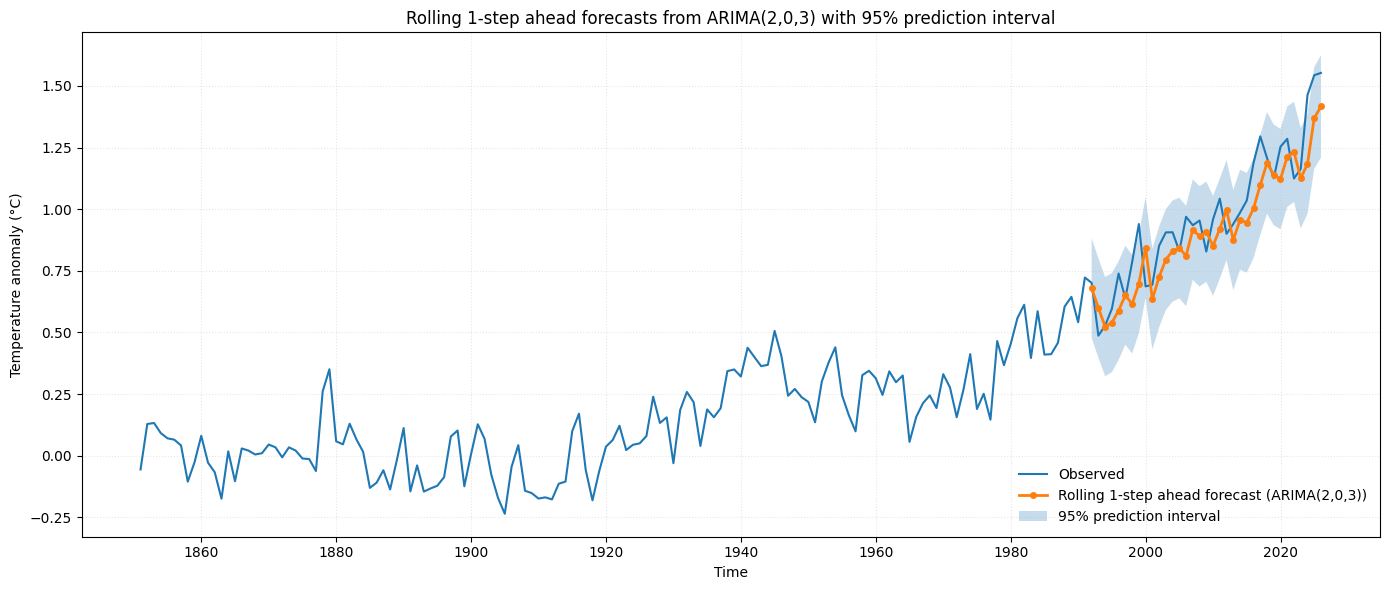


Rolling 1-step ahead forecasts (with 95% PI):
            forecast  pi_lower_95  pi_upper_95
1991-12-31  0.679910     0.477859     0.881960
1992-12-31  0.599720     0.398416     0.801023
1993-12-31  0.523998     0.322770     0.725226
1994-12-31  0.539722     0.338775     0.740670
1995-12-31  0.588826     0.388777     0.788876
1996-12-31  0.651179     0.450327     0.852030
1997-12-31  0.615067     0.414907     0.815227
1998-12-31  0.697510     0.496309     0.898711
1999-12-31  0.844457     0.639708     1.049207
2000-12-31  0.635059     0.430282     0.839835
2001-12-31  0.724763     0.520517     0.929009
2002-12-31  0.795510     0.590888     1.000131
2003-12-31  0.830110     0.624772     1.035449
2004-12-31  0.842498     0.638419     1.046577
2005-12-31  0.810362     0.606810     1.013915
2006-12-31  0.917279     0.713706     1.120852
2007-12-31  0.889776     0.686019     1.093532
2008-12-31  0.908832     0.705661     1.112002
2009-12-31  0.851040     0.648089     1.053990
2010-12-31  0

In [ ]:
# Define forecast range (1-step ahead rolling) for years 1991..2025
start_date = pd.Timestamp("1991-12-31")
end_date   = pd.Timestamp("2025-12-31")

# Indices in ts
start_idx = ts.index.get_loc(start_date)
end_idx   = ts.index.get_loc(end_date)

pred_dates = []
pred_values = []
lower_95, upper_95 = [], []

# Rolling 1-step ahead:
# For each target time t, train uses data up to t-1, forecast t
for t in range(start_idx, end_idx + 1):
    train_series = ts["Anomaly"].iloc[:t]  # up to previous observation
    fit = ARIMA(train_series, order=(2, 0, 3)).fit()
    
    fc = fit.get_forecast(steps=1)
    yhat = fc.predicted_mean.iloc[0]
    ci = fc.conf_int(alpha=0.05).iloc[0]   # 95% PI for that 1-step forecast

    pred_dates.append(ts.index[t])
    pred_values.append(yhat)
    lower_95.append(ci[0])
    upper_95.append(ci[1])

ARIMA_1step = pd.Series(pred_values, index=pd.DatetimeIndex(pred_dates), name="1-step ahead forecast")
PI_lower = pd.Series(lower_95, index=pd.DatetimeIndex(pred_dates), name="PI lower 95%")
PI_upper = pd.Series(upper_95, index=pd.DatetimeIndex(pred_dates), name="PI upper 95%")

# --- Plot
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(ts.index, ts["Anomaly"], linewidth=1.5, label="Observed")

ax.plot(ARIMA_1step.index, ARIMA_1step.values,
        linewidth=2, marker="o", markersize=4,
        label="Rolling 1-step ahead forecast (ARIMA(2,0,3))")

# 95% prediction interval band
ax.fill_between(ARIMA_1step.index, PI_lower.values, PI_upper.values, alpha=0.25, label="95% prediction interval")


ax.set_title("Rolling 1-step ahead forecasts from ARIMA(2,0,3) with 95% prediction interval")
ax.set_xlabel("Time")
ax.set_ylabel("Temperature anomaly (°C)")
ax.grid(True, alpha=0.3, linestyle=":")
ax.legend(loc="lower right", frameon=False)

plt.tight_layout()
plt.show()

# --- Print forecasts + interval table
results = pd.DataFrame({
    "forecast": ARIMA_1step,
    "pi_lower_95": PI_lower,
    "pi_upper_95": PI_upper
})
print("\nRolling 1-step ahead forecasts (with 95% PI):")
print(results)

# --- accuracy on that window
actual = ts["Anomaly"].loc[start_date:end_date]
mae = mean_absolute_error(actual, ARIMA_1step)
rmse = np.sqrt(mean_squared_error(actual, ARIMA_1step))
print(f"\nMAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


## EXPERIÊNCIAS A IGNORAR

In [ ]:
from itertools import product

# Testar diferentes combinações
p_values = range(0, 5)
d_values = [1, 2]  # d=1 ou d=2
q_values = range(0, 5)

best_aic = np.inf
best_order = None

for p, d, q in product(p_values, d_values, q_values):
    try:
        model = ARIMA(train_original, order=(p, d, q))
        fitted = model.fit()
        if fitted.aic < best_aic:
            best_aic = fitted.aic
            best_order = (p, d, q)
    except:
        continue

print(f"Melhor ordem: ARIMA{best_order} com AIC={best_aic:.2f}")

Melhor ordem: ARIMA(1, 1, 3) com AIC=-227.67



Dados: 176 observações (1850-2025)
Train: 141 obs (1850-1990)
Test:  35 obs (1991-2025)
MODELO 1: ARIMA(2,1,3) - Modelo Original
Progresso: 7 14 21 28 35 
✓ ARIMA(2,1,3) completo
  RMSE: 0.117175
  MAE:  0.095455
MODELO 2: ARIMA(1,1,3) - Modelo Otimizado (Grid Search)
Progresso: 7 14 21 28 35 
✓ ARIMA(1,1,3) completo
  RMSE: 0.117600
  MAE:  0.096857
COMPARAÇÃO DE PERFORMANCE
      Modelo     RMSE      MAE  Δ RMSE (%)  Δ MAE (%)
ARIMA(2,1,3) 0.117175 0.095455    0.000000   0.000000
ARIMA(1,1,3) 0.117600 0.096857   -0.362643  -1.468848

⚠️  ARIMA(2,1,3) ainda é melhor
   Diferença: 0.36% no RMSE


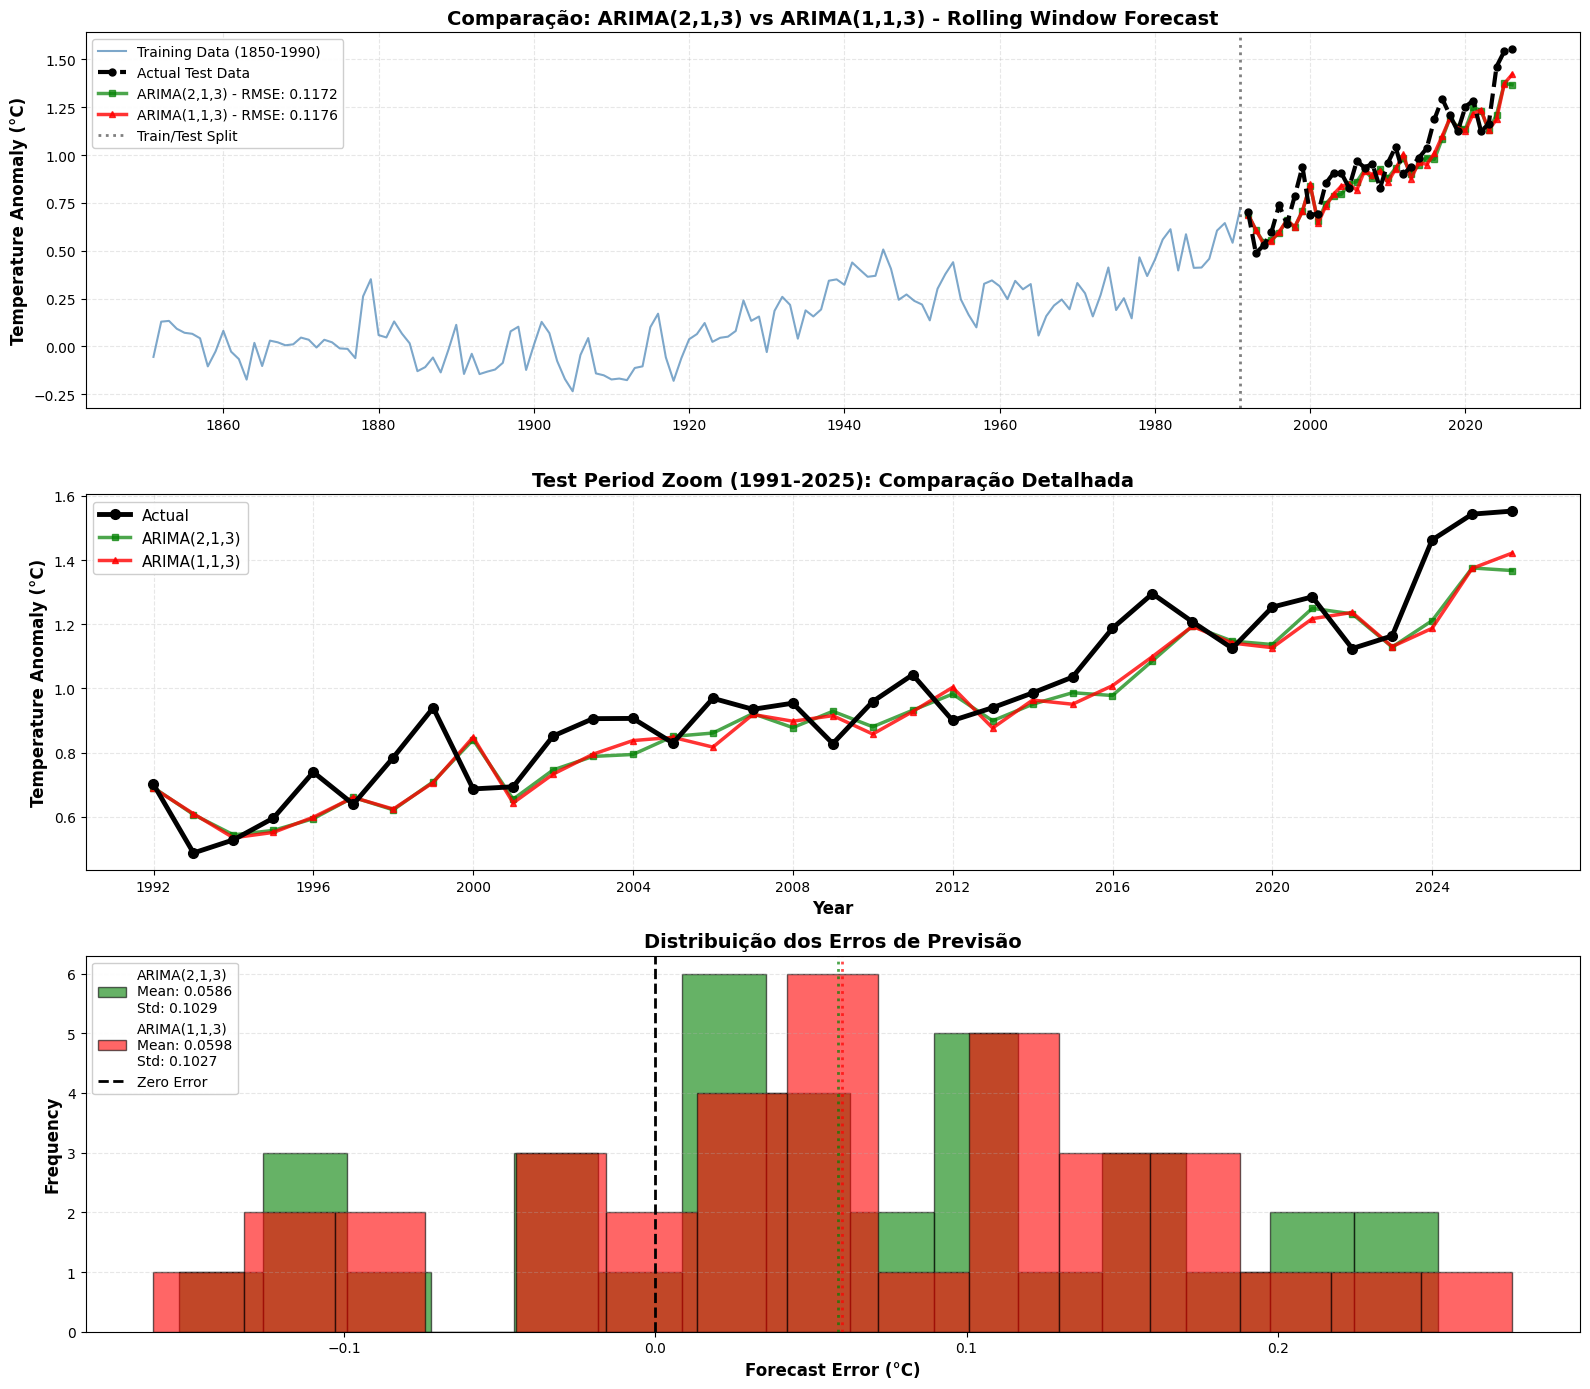

In [ ]:
# Série original
original_series = ts['Anomaly']
train_original = original_series[original_series.index.year <= 1990]
test_original = original_series[original_series.index.year > 1990]

print(f"\nDados: {len(original_series)} observações (1850-2025)")
print(f"Train: {len(train_original)} obs (1850-1990)")
print(f"Test:  {len(test_original)} obs (1991-2025)")

print("MODELO 1: ARIMA(2,1,3) - Modelo Original")

rolling_213 = []
rolling_dates = []

print("Progresso:", end=" ")
for i, date in enumerate(test_original.index):
    current_year = date.year
    train_rolling = original_series[original_series.index.year <= (1990 + i)]
    
    model = ARIMA(train_rolling, order=(2, 1, 3))
    fitted = model.fit()
    pred = fitted.get_forecast(steps=1).predicted_mean.iloc[0]
    
    rolling_213.append(pred)
    rolling_dates.append(date)
    
    if (i + 1) % 7 == 0:
        print(f"{i+1}", end=" ")

print()

rolling_213_series = pd.Series(rolling_213, index=rolling_dates)
rmse_213 = np.sqrt(mean_squared_error(test_original, rolling_213_series))
mae_213 = mean_absolute_error(test_original, rolling_213_series)

print(f"✓ ARIMA(2,1,3) completo")
print(f"  RMSE: {rmse_213:.6f}")
print(f"  MAE:  {mae_213:.6f}")

print("MODELO 2: ARIMA(1,1,3) - Modelo Otimizado (Grid Search)")
rolling_113 = []

print("Progresso:", end=" ")
for i, date in enumerate(test_original.index):
    current_year = date.year
    train_rolling = original_series[original_series.index.year <= (1990 + i)]
    
    model = ARIMA(train_rolling, order=(1, 1, 3))
    fitted = model.fit()
    pred = fitted.get_forecast(steps=1).predicted_mean.iloc[0]
    
    rolling_113.append(pred)
    
    if (i + 1) % 7 == 0:
        print(f"{i+1}", end=" ")

print()

rolling_113_series = pd.Series(rolling_113, index=rolling_dates)
rmse_113 = np.sqrt(mean_squared_error(test_original, rolling_113_series))
mae_113 = mean_absolute_error(test_original, rolling_113_series)

print(f"✓ ARIMA(1,1,3) completo")
print(f"  RMSE: {rmse_113:.6f}")
print(f"  MAE:  {mae_113:.6f}")

print("COMPARAÇÃO DE PERFORMANCE")
improvement_rmse = ((rmse_213 - rmse_113) / rmse_213) * 100
improvement_mae = ((mae_213 - mae_113) / mae_213) * 100

comparison_df = pd.DataFrame({
    'Modelo': ['ARIMA(2,1,3)', 'ARIMA(1,1,3)'],
    'RMSE': [rmse_213, rmse_113],
    'MAE': [mae_213, mae_113],
    'Δ RMSE (%)': [0, improvement_rmse],
    'Δ MAE (%)': [0, improvement_mae]
})

print(comparison_df.to_string(index=False))
print("="*70)

if rmse_113 < rmse_213:
    print(f"\n🎉 ARIMA(1,1,3) é MELHOR!")
    print(f"   Redução de {abs(improvement_rmse):.2f}% no RMSE")
    print(f"   Redução de {abs(improvement_mae):.2f}% no MAE")
else:
    print(f"\n⚠️  ARIMA(2,1,3) ainda é melhor")
    print(f"   Diferença: {abs(improvement_rmse):.2f}% no RMSE")

# Calcular erros de previsão
errors_213 = test_original - rolling_213_series
errors_113 = test_original - rolling_113_series

#Gráficos
fig, axes = plt.subplots(3, 1, figsize=(16, 14))

# --- GRÁFICO 1: SÉRIE TEMPORAL COMPLETA ---
ax1 = axes[0]

# Dados históricos
ax1.plot(train_original.index, train_original.values, 
         label='Training Data (1850-1990)', color='steelblue', linewidth=1.5, alpha=0.7)

# Dados reais de teste
ax1.plot(test_original.index, test_original.values, 
         label='Actual Test Data', color='black', linewidth=3, 
         linestyle='--', marker='o', markersize=5, zorder=10)

# Previsões ARIMA(2,1,3)
ax1.plot(rolling_213_series.index, rolling_213_series.values, 
         label=f'ARIMA(2,1,3) - RMSE: {rmse_213:.4f}', 
         color='green', linewidth=2.5, marker='s', markersize=4, alpha=0.7)

# Previsões ARIMA(1,1,3)
ax1.plot(rolling_113_series.index, rolling_113_series.values, 
         label=f'ARIMA(1,1,3) - RMSE: {rmse_113:.4f}', 
         color='red', linewidth=2.5, marker='^', markersize=4, alpha=0.8)

ax1.axvline(x=train_original.index[-1], color='gray', linestyle=':', linewidth=2, 
            label='Train/Test Split')

ax1.set_ylabel('Temperature Anomaly (°C)', fontsize=12, fontweight='bold')
ax1.set_title('Comparação: ARIMA(2,1,3) vs ARIMA(1,1,3) - Rolling Window Forecast', 
              fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', fontsize=10, framealpha=0.95)
ax1.grid(True, alpha=0.3, linestyle='--')

# --- GRÁFICO 2: ZOOM NO PERÍODO DE TESTE ---
ax2 = axes[1]

# Dados reais
ax2.plot(test_original.index, test_original.values, 
         label='Actual', color='black', linewidth=3.5, 
         marker='o', markersize=7, zorder=10, linestyle='-')

# Previsões
ax2.plot(rolling_213_series.index, rolling_213_series.values, 
         label='ARIMA(2,1,3)', color='green', linewidth=2.5, 
         marker='s', markersize=5, alpha=0.7, linestyle='-')

ax2.plot(rolling_113_series.index, rolling_113_series.values, 
         label='ARIMA(1,1,3)', color='red', linewidth=2.5, 
         marker='^', markersize=5, alpha=0.8, linestyle='-')

ax2.set_xlabel('Year', fontsize=12, fontweight='bold')
ax2.set_ylabel('Temperature Anomaly (°C)', fontsize=12, fontweight='bold')
ax2.set_title('Test Period Zoom (1991-2025): Comparação Detalhada', 
              fontsize=14, fontweight='bold')
ax2.legend(loc='upper left', fontsize=11, framealpha=0.95)
ax2.grid(True, alpha=0.3, linestyle='--')

# --- GRÁFICO 3: DISTRIBUIÇÃO DOS ERROS ---
ax3 = axes[2]

# Histogramas
ax3.hist(errors_213, bins=15, alpha=0.6, color='green', 
         edgecolor='black', label=f'ARIMA(2,1,3)\nMean: {errors_213.mean():.4f}\nStd: {errors_213.std():.4f}')
ax3.hist(errors_113, bins=15, alpha=0.6, color='red', 
         edgecolor='black', label=f'ARIMA(1,1,3)\nMean: {errors_113.mean():.4f}\nStd: {errors_113.std():.4f}')

ax3.axvline(x=0, color='black', linestyle='--', linewidth=2, label='Zero Error')
ax3.axvline(x=errors_213.mean(), color='green', linestyle=':', linewidth=2, alpha=0.7)
ax3.axvline(x=errors_113.mean(), color='red', linestyle=':', linewidth=2, alpha=0.7)

ax3.set_xlabel('Forecast Error (°C)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax3.set_title('Distribuição dos Erros de Previsão', fontsize=14, fontweight='bold')
ax3.legend(loc='upper left', fontsize=10, framealpha=0.95)
ax3.grid(True, alpha=0.3, axis='y', linestyle='--')

plt.tight_layout()
plt.savefig('arima_comparison_113_vs_213.png', dpi=300, bbox_inches='tight')
plt.show()

With this we can see that the model MA(2) converges to the mean after 2 steps. In order to try to overpass the MA(2) limitation, one possibilty is to apply the forecast 1-step ahead at each time

In [ ]:
# Rolling 1-step ahead forecasts
predictions = []
for i in range(len(test_data)):
    train_temp = ts[:train_size + i]
    model_temp = ARIMA(train_temp['Anomaly'], order=(0, 0, 2))
    fitted_temp = model_temp.fit()
    pred = fitted_temp.forecast(steps=1)
    predictions.append(pred.values[0])

NameError: name 'test_data' is not defined

In [ ]:
# Step 1: Split your data
train_size = len(ts) - 20  # Reserve last 20 observations for testing
train_data = ts[:train_size]
test_data = ts[train_size:]

# Step 2: Rolling 1-step ahead forecasts
predictions_1step = []
actual_values = []

for i in range(len(test_data)):
    # Expand training set by one observation each iteration
    train_temp = ts[:train_size + i]
    
    # Fit MA(2) model
    model_temp = ARIMA(train_temp['Anomaly'], order=(0, 0, 2))
    fitted_temp = model_temp.fit()
    
    # Forecast 1 step ahead
    pred = fitted_temp.forecast(steps=1)
    predictions_1step.append(pred.values[0])
    actual_values.append(test_data['Anomaly'].iloc[i])
    
    print(f"Step {i+1}: Actual = {test_data['Anomaly'].iloc[i]:.4f}, Predicted = {pred.values[0]:.4f}")

# Step 3: Calculate performance metrics
predictions_1step = np.array(predictions_1step)
actual_values = np.array(actual_values)

mae_1step = mean_absolute_error(actual_values, predictions_1step)
rmse_1step = np.sqrt(mean_squared_error(actual_values, predictions_1step))
mape_1step = np.mean(np.abs((actual_values - predictions_1step) / actual_values)) * 100

print(f"\n=== Rolling 1-Step Ahead Forecast Performance ===")
print(f"MAE: {mae_1step:.4f}")
print(f"RMSE: {rmse_1step:.4f}")
print(f"MAPE: {mape_1step:.2f}%")

# Step 4: Visualize rolling forecasts
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, actual_values, label='Actual', color='blue', marker='o', linewidth=2)
plt.plot(test_data.index, predictions_1step, label='Rolling 1-Step Forecast', color='red', marker='x', linestyle='--', linewidth=2)
plt.title('MA(2) Rolling 1-Step Ahead Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Anomaly')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Step 5: Plot forecast errors
errors = actual_values - predictions_1step

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(test_data.index, errors, color='purple', marker='o')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Forecast Errors Over Time')
plt.xlabel('Date')
plt.ylabel('Error')
plt.grid(True, alpha=0.3)


The rolling forecast evaluation demonstrates that MA(2) provides reliable short-term predictions (1-step ahead), with accuracy degrading for longer horizons. Thus, since we need longer-term forecasts, we will apply the ARMA model since it combines both behaviours.

In [ ]:
# Fit ARMA(3,2) on full data
model_arma = ARIMA(ts['Anomaly'], order=(3, 0, 2))
fitted_arma = model_arma.fit()
print(fitted_arma.summary())

# Generate long-term forecast (12 steps ahead)
h = 12
forecast_arma = fitted_arma.forecast(steps=h)
forecast_arma_ci = fitted_arma.get_forecast(steps=h).conf_int()

print("\n=== ARMA(3,2) Forecast ===")
print(forecast_arma)

In [ ]:
# Also get MA(2) forecast for comparison
model_ma = ARIMA(ts['Anomaly'], order=(0, 0, 2))
fitted_ma = model_ma.fit()
forecast_ma = fitted_ma.forecast(steps=h)

# Plot comparison
plt.figure(figsize=(14, 6))
plt.plot(ts.index, ts['Anomaly'], label='Historical Data', color='blue', linewidth=1.5)
plt.plot(forecast_ma.index, forecast_ma, label='MA(2) Forecast', color='red', linestyle='--', marker='o', linewidth=2)
plt.plot(forecast_arma.index, forecast_arma, label='ARMA(3,2) Forecast', color='green', linestyle='--', marker='s', linewidth=2)
plt.fill_between(forecast_arma.index, 
                 forecast_arma_ci.iloc[:, 0], 
                 forecast_arma_ci.iloc[:, 1], 
                 color='lightgreen', alpha=0.3, label='ARMA 95% CI')
plt.title('MA(2) vs ARMA(3,2) Forecasts Comparison')
plt.xlabel('Date')
plt.ylabel('Anomaly')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axvline(x=ts.index[-1], color='black', linestyle=':', linewidth=1)
plt.tight_layout()
plt.show()

In [ ]:
# Split data
train_size = len(ts) - 20
train_data = ts[:train_size]
test_data = ts[train_size:]

# Rolling forecasts for MA(2)
predictions_ma = []
for i in range(len(test_data)):
    train_temp = ts[:train_size + i]
    model_temp = ARIMA(train_temp['Anomaly'], order=(0, 0, 2))
    fitted_temp = model_temp.fit()
    pred = fitted_temp.forecast(steps=1)
    predictions_ma.append(pred.values[0])

# Rolling forecasts for ARMA(3,2)
predictions_arma = []
for i in range(len(test_data)):
    train_temp = ts[:train_size + i]
    model_temp = ARIMA(train_temp['Anomaly'], order=(3, 0, 2))
    fitted_temp = model_temp.fit()
    pred = fitted_temp.forecast(steps=1)
    predictions_arma.append(pred.values[0])

predictions_ma = np.array(predictions_ma)
predictions_arma = np.array(predictions_arma)
actual_values = test_data['Anomaly'].values

# Calculate metrics for both models
mae_ma = mean_absolute_error(actual_values, predictions_ma)
rmse_ma = np.sqrt(mean_squared_error(actual_values, predictions_ma))
mape_ma = np.mean(np.abs((actual_values - predictions_ma) / actual_values)) * 100

mae_arma = mean_absolute_error(actual_values, predictions_arma)
rmse_arma = np.sqrt(mean_squared_error(actual_values, predictions_arma))
mape_arma = np.mean(np.abs((actual_values - predictions_arma) / actual_values)) * 100

print("\n=== Rolling 1-Step Ahead Forecast Comparison ===")
print(f"\nMA(2) Performance:")
print(f"  MAE:  {mae_ma:.4f}")
print(f"  RMSE: {rmse_ma:.4f}")
print(f"  MAPE: {mape_ma:.2f}%")

print(f"\nARMA(3,2) Performance:")
print(f"  MAE:  {mae_arma:.4f}")
print(f"  RMSE: {rmse_arma:.4f}")
print(f"  MAPE: {mape_arma:.2f}%")

print(f"\nImprovement:")
print(f"  MAE:  {((mae_ma - mae_arma) / mae_ma * 100):.2f}%")
print(f"  RMSE: {((rmse_ma - rmse_arma) / rmse_ma * 100):.2f}%")

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(test_data.index, actual_values, label='Actual', color='blue', marker='o', linewidth=2, markersize=6)
plt.plot(test_data.index, predictions_ma, label='MA(2) Forecast', color='red', marker='x', linestyle='--', linewidth=2, markersize=8)
plt.plot(test_data.index, predictions_arma, label='ARMA(3,2) Forecast', color='green', marker='s', linestyle='--', linewidth=2, markersize=6)
plt.title('Rolling 1-Step Ahead Forecasts: MA(2) vs ARMA(3,2)')
plt.xlabel('Date')
plt.ylabel('Anomaly')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Error distribution ARMA(3,2)
errors_arma = actual_values - predictions_arma
axes[1, 0].hist(errors_arma, bins=10, color='green', alpha=0.7, edgecolor='black')
axes[1, 0].axvline(x=0, color='black', linestyle='--', linewidth=2)
axes[1, 0].set_title('ARMA(3,2) Error Distribution')
axes[1, 0].set_xlabel('Error')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

While MA(2) demonstrated the best in-sample fit based on AIC/BIC criteria, its forecasting capability is limited due to the finite memory property of moving average models. To address this limitation, we also evaluated the ARMA(3,2) model for forecasting purposes. The ARMA model combines autoregressive components that provide longer memory, potentially improving forecast accuracy beyond 2-step horizons.

## Forecast 35 years all at once using ARIMA(2,0,3)

MAE:  0.4466
RMSE: 0.5300


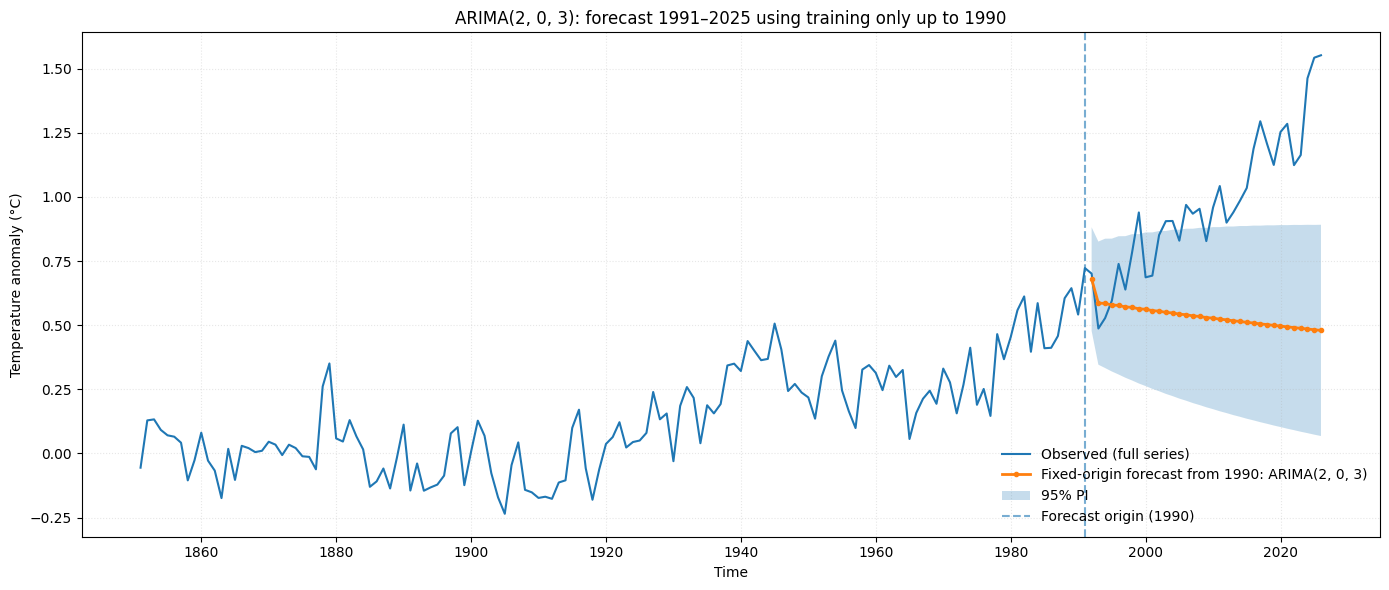

In [ ]:
order = (2, 0, 3)

fit = ARIMA(y_train, order=order).fit()

fc = fit.get_forecast(steps=len(y_test))
pred = fc.predicted_mean
ci = fc.conf_int(alpha=0.05)

pred.index = y_test.index
ci.index = y_test.index

PI_lower = ci.iloc[:, 0]
PI_upper = ci.iloc[:, 1]


mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(y.index, y.values, linewidth=1.5, label="Observed (full series)")
ax.plot(pred.index, pred.values, linewidth=2, marker="o", markersize=3,
        label=f"Fixed-origin forecast from 1990: ARIMA{order}")
ax.fill_between(pred.index, PI_lower.values, PI_upper.values, alpha=0.25, label="95% PI")
ax.axvline(y_train.index[-1], linestyle="--", alpha=0.6, label="Forecast origin (1990)")
ax.set_title(f"ARIMA{order}: forecast 1991–2025 using training only up to 1990")
ax.set_xlabel("Time"); ax.set_ylabel("Temperature anomaly (°C)")
ax.grid(True, alpha=0.3, linestyle=":")
ax.legend(frameon=False, loc="lower right")
plt.tight_layout()
plt.show()


In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss

y = ts["Anomaly"].dropna()

adf_stat, adf_p, *_ = adfuller(y, autolag="AIC")
print(f"ADF p-value (Anomaly): {adf_p}")

kpss_stat, kpss_p, *_ = kpss(y, regression="c", nlags="auto")
print(f"KPSS p-value (Anomaly): {kpss_p}")

dy = y.diff().dropna()

adf_stat_d, adf_p_d, *_ = adfuller(dy, autolag="AIC")
print(f"ADF p-value (ΔAnomaly): {adf_p_d}")

kpss_stat_d, kpss_p_d, *_ = kpss(dy, regression="c", nlags="auto")
print(f"KPSS p-value (ΔAnomaly): {kpss_p_d}")


ADF p-value (Anomaly): 0.9990879642610734
KPSS p-value (Anomaly): 0.01
ADF p-value (ΔAnomaly): 2.7643307383633745e-22
KPSS p-value (ΔAnomaly): 0.08685302149936634


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import Holt

# -----------------------------
# Settings
# -----------------------------
start_date = pd.Timestamp("1991-12-31")
end_date   = pd.Timestamp("2025-12-31")

y = ts["Anomaly"].astype(float).sort_index()

start_idx = y.index.get_loc(start_date)
end_idx   = y.index.get_loc(end_date)

actual = y.loc[start_date:end_date]

def mae_rmse(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse

# -----------------------------
# Baseline: Naïve
# -----------------------------
naive_pred = y.shift(1).loc[start_date:end_date]

# -----------------------------
# Baseline: Drift
# -----------------------------
drift_vals = []
for t in range(start_idx, end_idx + 1):
    train = y.iloc[:t]  # up to t-1
    n = len(train)
    slope = (train.iloc[-1] - train.iloc[0]) / max(n - 1, 1)
    drift_vals.append(train.iloc[-1] + slope)

drift_pred = pd.Series(drift_vals, index=y.index[start_idx:end_idx+1], name="Drift")

# -----------------------------
# Holt (trend exponential smoothing) + approx PI
# -----------------------------
holt_vals, holt_lo, holt_hi = [], [], []
for t in range(start_idx, end_idx + 1):
    train = y.iloc[:t]
    fit = Holt(train, damped_trend=False).fit(optimized=True)

    fc = fit.forecast(1).iloc[0]
    holt_vals.append(fc)

    # Approx PI using residual std (simple approximation)
    resid = (train - fit.fittedvalues).dropna()
    s = resid.std(ddof=1)
    holt_lo.append(fc - 1.96*s)
    holt_hi.append(fc + 1.96*s)

holt_pred = pd.Series(holt_vals, index=y.index[start_idx:end_idx+1], name="Holt")
holt_lo   = pd.Series(holt_lo,   index=y.index[start_idx:end_idx+1], name="Holt_PI_Low")
holt_hi   = pd.Series(holt_hi,   index=y.index[start_idx:end_idx+1], name="Holt_PI_High")

# -----------------------------
# ARIMA shortlist based on d=1 (your unit-root results)
# -----------------------------
arima_orders = [
    (0, 1, 1),
    (1, 1, 0),
    (1, 1, 1),
    (2, 1, 1),
    (2, 1, 3),
]

def rolling_arima(y, start_idx, end_idx, order):
    pred_dates = []
    pred_vals = []
    lo_95, hi_95 = [], []

    for t in range(start_idx, end_idx + 1):
        train = y.iloc[:t]  # up to t-1
        fit = ARIMA(train, order=order).fit()

        fc = fit.get_forecast(steps=1)
        mean = fc.predicted_mean.iloc[0]
        ci = fc.conf_int(alpha=0.05).iloc[0]  # 95% PI

        pred_dates.append(y.index[t])
        pred_vals.append(mean)
        lo_95.append(ci[0])
        hi_95.append(ci[1])

    pred = pd.Series(pred_vals, index=pd.DatetimeIndex(pred_dates), name=f"ARIMA{order}")
    lo   = pd.Series(lo_95,     index=pd.DatetimeIndex(pred_dates), name=f"ARIMA{order}_PI_Low")
    hi   = pd.Series(hi_95,     index=pd.DatetimeIndex(pred_dates), name=f"ARIMA{order}_PI_High")
    return pred, lo, hi

# Run ARIMA models
arima_results = {}
for order in arima_orders:
    pred, lo, hi = rolling_arima(y, start_idx, end_idx, order)
    arima_results[order] = (pred, lo, hi)

# -----------------------------
# Build comparison table
# -----------------------------
rows = []

# baselines
mae_n, rmse_n = mae_rmse(actual, naive_pred)
rows.append(["Naïve", mae_n, rmse_n, np.nan])

mae_d, rmse_d = mae_rmse(actual, drift_pred)
rows.append(["Drift", mae_d, rmse_d, np.nan])

# Holt
mae_h, rmse_h = mae_rmse(actual, holt_pred)
cov_h = ((actual >= holt_lo) & (actual <= holt_hi)).mean()
rows.append(["Holt (approx PI)", mae_h, rmse_h, float(cov_h)])

# ARIMAs
for order, (pred, lo, hi) in arima_results.items():
    mae_a, rmse_a = mae_rmse(actual, pred)
    cov_a = ((actual >= lo) & (actual <= hi)).mean()
    rows.append([f"ARIMA{order}", mae_a, rmse_a, float(cov_a)])

compare = pd.DataFrame(rows, columns=["Model", "MAE", "RMSE", "95%_PI_Coverage"]).sort_values("RMSE")
print(compare)

# -----------------------------
# Pick best ARIMA by RMSE (optional)
# -----------------------------
best_arima_row = compare[compare["Model"].str.startswith("ARIMA")].iloc[0]
print("\nBest ARIMA by RMSE:", best_arima_row["Model"])


              Model       MAE      RMSE  95%_PI_Coverage
7    ARIMA(2, 1, 3)  0.095455  0.117175         0.885714
1             Drift  0.096140  0.119133              NaN
6    ARIMA(2, 1, 1)  0.097264  0.119451         0.942857
0             Naïve  0.097982  0.120003              NaN
2  Holt (approx PI)  0.098073  0.120975         0.914286
4    ARIMA(1, 1, 0)  0.099321  0.121724         0.971429
5    ARIMA(1, 1, 1)  0.100464  0.122110         0.942857
3    ARIMA(0, 1, 1)  0.102051  0.123285         0.885714

Best ARIMA by RMSE: ARIMA(2, 1, 3)


Top 3 models: ['ARIMA(2, 1, 3)', 'Drift', 'ARIMA(2, 1, 1)']


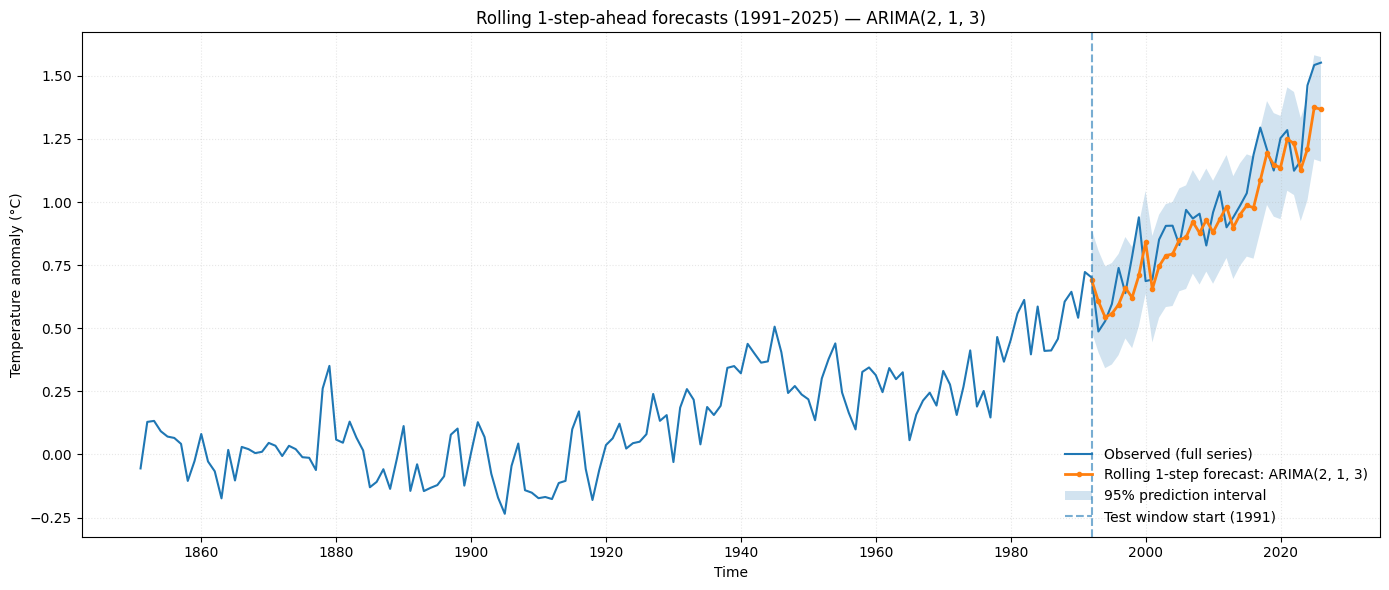

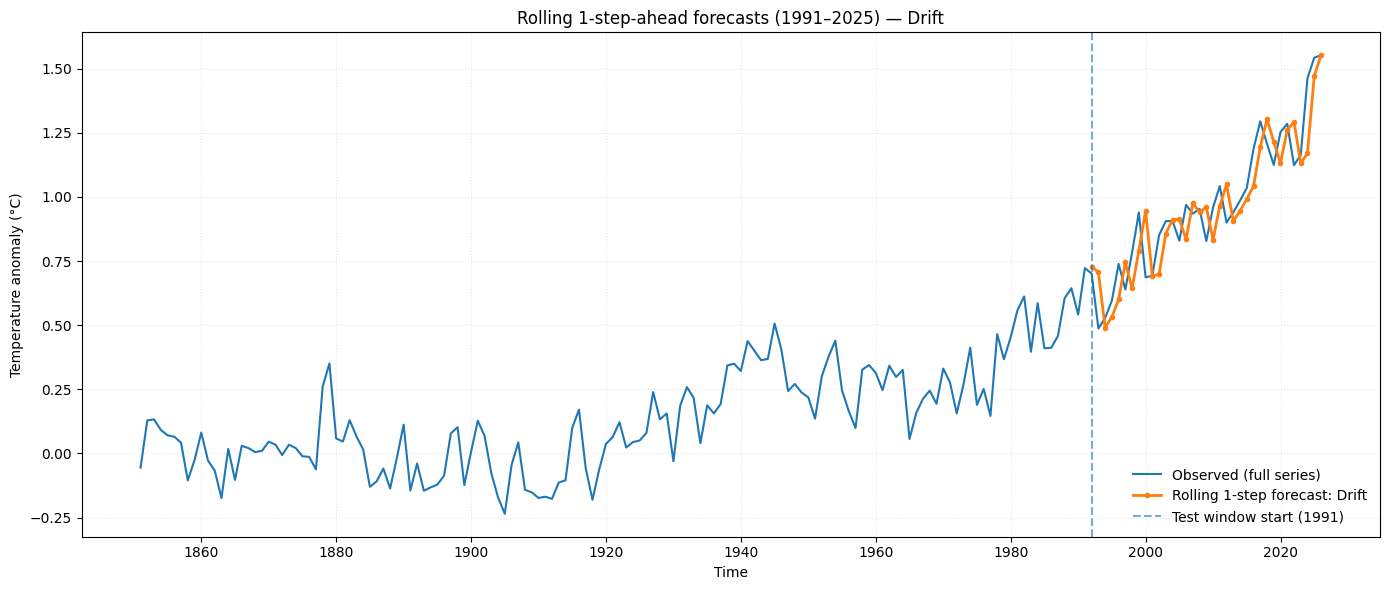

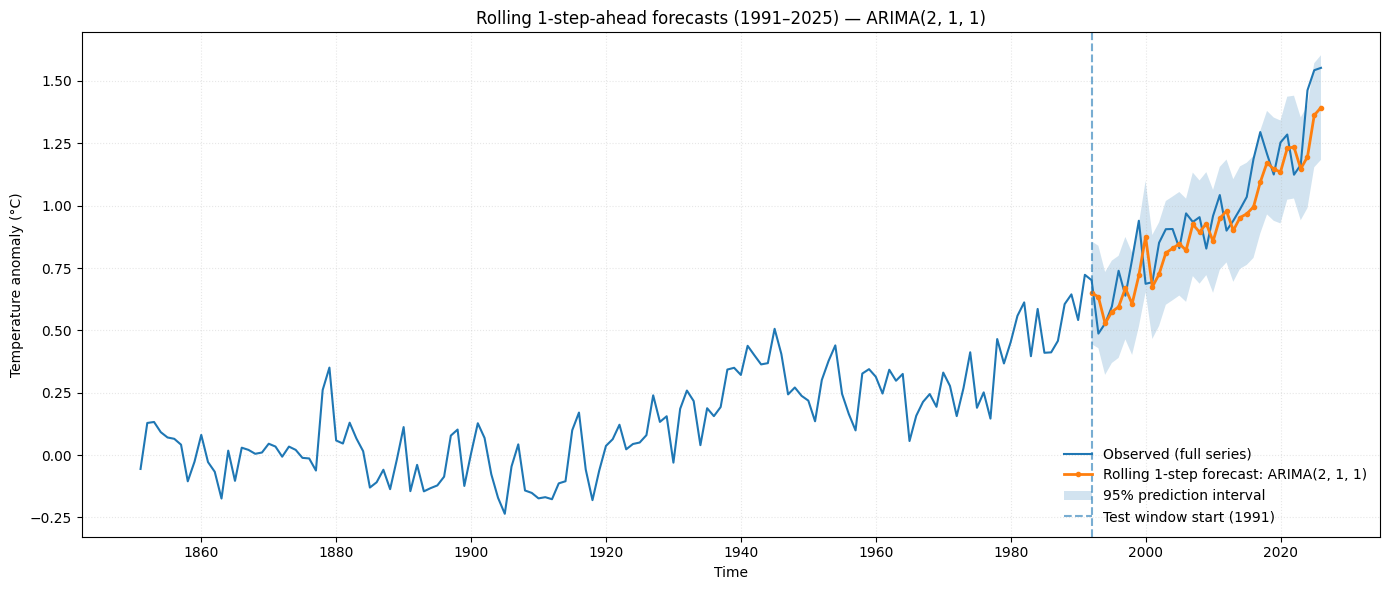

In [ ]:


# Top 3 by RMSE
top3 = compare.head(3)["Model"].tolist()
print("Top 3 models:", top3)

def get_pred_lo_hi(model_name):
    if model_name == "Drift":
        pred = drift_pred.loc[start_date:end_date]
        return pred, None, None

    if model_name == "Naïve":
        pred = y.shift(1).loc[start_date:end_date]
        return pred, None, None

    if model_name.startswith("ARIMA"):
        order = eval(model_name.replace("ARIMA", ""))  # e.g. "ARIMA(2, 1, 3)" -> (2,1,3)
        pred, lo, hi = arima_results[order]
        return pred.loc[start_date:end_date], lo.loc[start_date:end_date], hi.loc[start_date:end_date]

    if model_name.startswith("Holt"):
        pred = holt_pred.loc[start_date:end_date]
        return pred, holt_lo.loc[start_date:end_date], holt_hi.loc[start_date:end_date]

    raise ValueError(f"Unknown model name: {model_name}")

for name in top3:
    pred, lo, hi = get_pred_lo_hi(name)

    fig, ax = plt.subplots(figsize=(14, 6))

    # Full observed series (background)
    ax.plot(y.index, y.values, linewidth=1.5, label="Observed (full series)")

    # Forecast over test window
    ax.plot(pred.index, pred.values,
            linewidth=2, marker="o", markersize=3,
            label=f"Rolling 1-step forecast: {name}")

    # PI band if available
    if lo is not None and hi is not None:
        ax.fill_between(pred.index, lo.values, hi.values, alpha=0.2, label="95% prediction interval")

    # Visual marker for test window start
    ax.axvline(start_date, linestyle="--", alpha=0.6, label="Test window start (1991)")

    ax.set_title(f"Rolling 1-step-ahead forecasts (1991–2025) — {name}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Temperature anomaly (°C)")
    ax.grid(True, alpha=0.3, linestyle=":")
    ax.legend(frameon=False, loc="lower right")
    plt.tight_layout()
    plt.show()


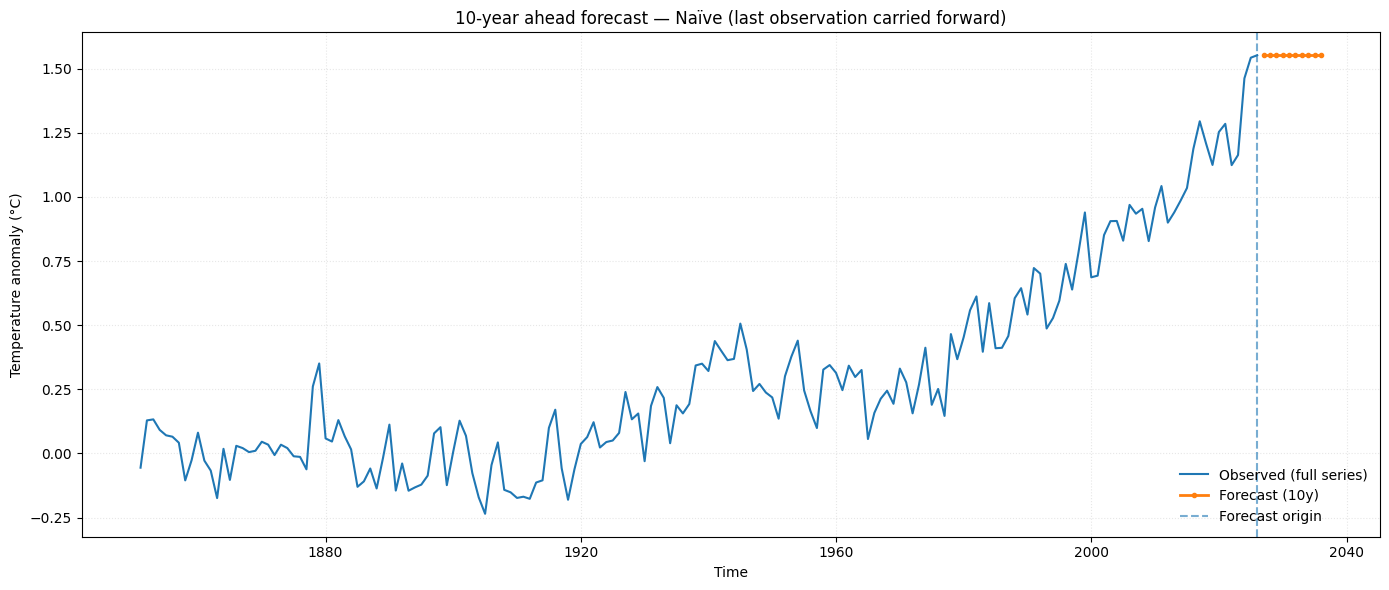

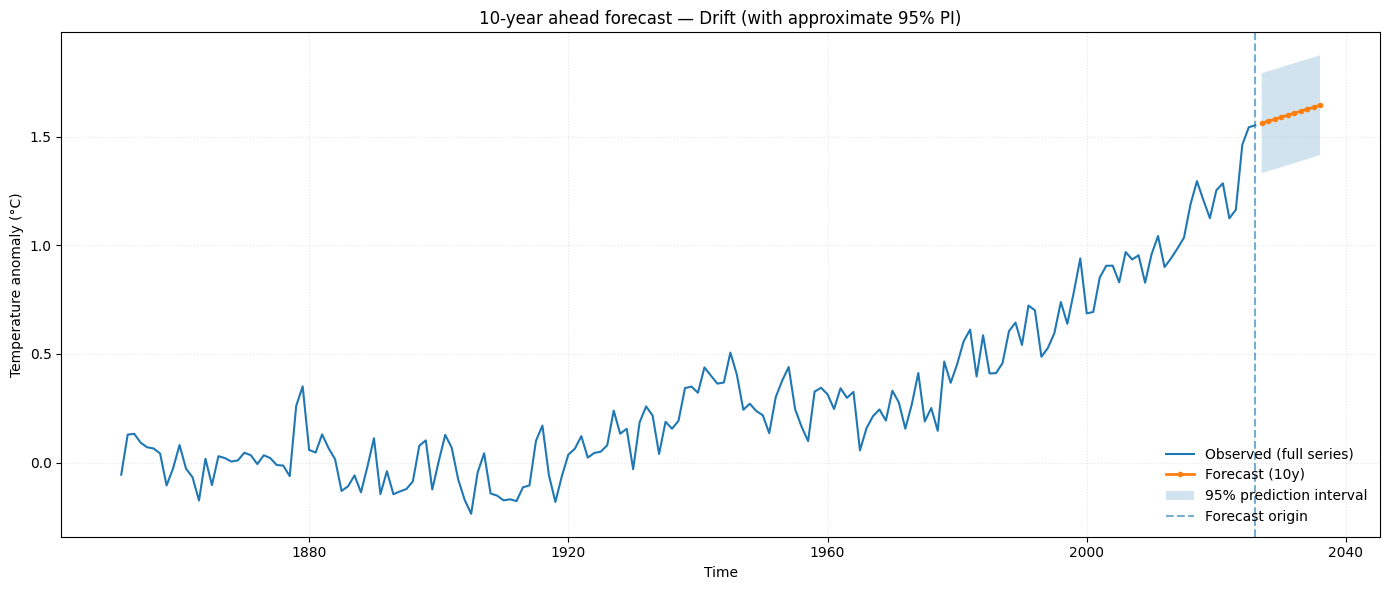

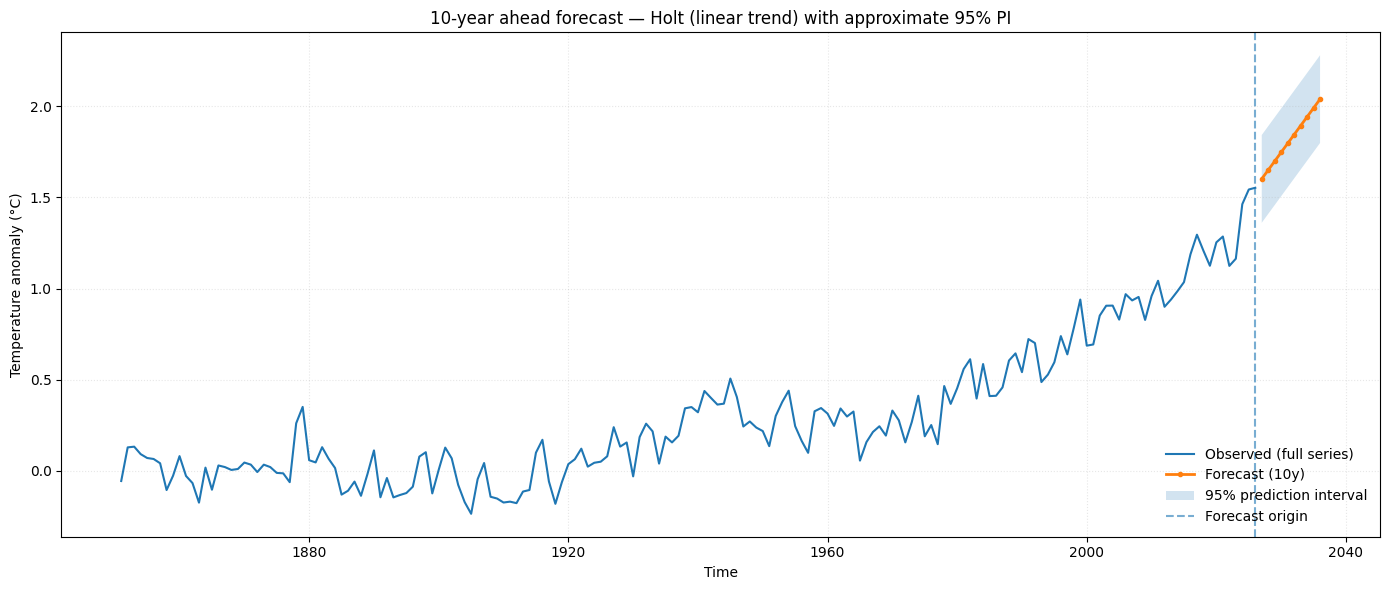

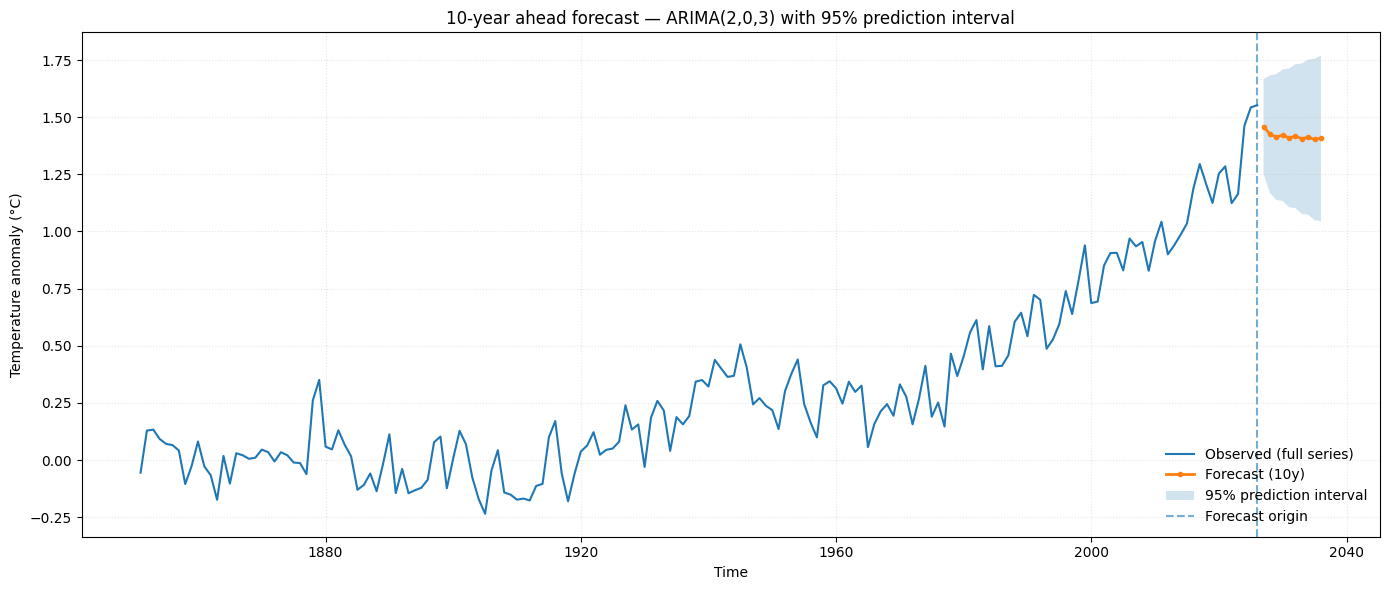

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import Holt

y = ts["Anomaly"].astype(float).sort_index()

H = 10  # horizon in years
last_date = y.index[-1]

# build future year index (keeps same end-of-year style as your data)
future_index = pd.date_range(start=last_date, periods=H+1, freq="A-DEC")[1:]

def plot_forecast_full(y, mean_fc, lo=None, hi=None, title="Forecast"):
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(y.index, y.values, linewidth=1.5, label="Observed (full series)")
    ax.plot(mean_fc.index, mean_fc.values, linewidth=2, marker="o", markersize=3, label="Forecast (10y)")

    if lo is not None and hi is not None:
        ax.fill_between(mean_fc.index, lo.values, hi.values, alpha=0.2, label="95% prediction interval")

    ax.axvline(y.index[-1], linestyle="--", alpha=0.6, label="Forecast origin")
    ax.set_title(title)
    ax.set_xlabel("Time")
    ax.set_ylabel("Temperature anomaly (°C)")
    ax.grid(True, alpha=0.3, linestyle=":")
    ax.legend(frameon=False, loc="lower right")
    plt.tight_layout()
    plt.show()

# -------------------
# 1) Naïve (last value)
# -------------------
naive_mean = pd.Series([y.iloc[-1]] * H, index=future_index, name="Naive forecast")
# No principled PI from naive without extra assumptions -> skip PI
plot_forecast_full(
    y,
    naive_mean,
    title="10-year ahead forecast — Naïve (last observation carried forward)"
)

# -------------------
# 2) Drift (random walk with drift)
# -------------------
n = len(y)
drift = (y.iloc[-1] - y.iloc[0]) / max(n - 1, 1)
drift_mean = pd.Series([y.iloc[-1] + drift*k for k in range(1, H+1)], index=future_index, name="Drift forecast")

# Optional approximate PI: based on residual std of 1-step drift errors (simple)
drift_1step_pred = y.shift(1) + drift
drift_resid = (y - drift_1step_pred).dropna()
s = drift_resid.std(ddof=1)
drift_lo = drift_mean - 1.96*s
drift_hi = drift_mean + 1.96*s

plot_forecast_full(
    y,
    drift_mean,
    drift_lo,
    drift_hi,
    title="10-year ahead forecast — Drift (with approximate 95% PI)"
)

# -------------------
# 3) Holt (trend exponential smoothing)
# -------------------
holt_fit = Holt(y, damped_trend=False).fit(optimized=True)
holt_mean = holt_fit.forecast(H)

# Approx PI using in-sample residual std (simple)
holt_resid = (y - holt_fit.fittedvalues).dropna()
s_holt = holt_resid.std(ddof=1)
holt_lo = holt_mean - 1.96*s_holt
holt_hi = holt_mean + 1.96*s_holt

plot_forecast_full(
    y,
    holt_mean,
    holt_lo,
    holt_hi,
    title="10-year ahead forecast — Holt (linear trend) with approximate 95% PI"
)

# -------------------
# 4) ARIMA(2,0,3)
# -------------------
arima_fit = ARIMA(y, order=(2,0,3)).fit()
arima_fc = arima_fit.get_forecast(steps=H)
arima_mean = arima_fc.predicted_mean
arima_ci = arima_fc.conf_int(alpha=0.05)

plot_forecast_full(
    y,
    arima_mean,
    arima_ci.iloc[:,0],
    arima_ci.iloc[:,1],
    title="10-year ahead forecast — ARIMA(2,0,3) with 95% prediction interval"
)
